# 1. Hard SVM with 2 features and 10 samples

In [1]:

from sklearn import datasets
from sklearn.preprocessing import LabelEncoder
import pandas as pd
from sklearn.utils import shuffle
data = datasets.load_breast_cancer()
from sklearn.preprocessing import StandardScaler

import jax.numpy as jnp
from jax import grad as fgrad
from jax import jit, vmap, jacfwd, jacrev, device_put
import numpy as np
from numpy.linalg import norm
import torch
import torch.nn as nn
from torch.optim import Adam
import torch.nn.functional as F
from torch.autograd import grad
from scipy.integrate import solve_ivp
np.set_printoptions(suppress=True)
from matplotlib import pyplot as plt
import random
import jax

from copy import deepcopy

CUDA = torch.cuda.is_available()
mse = nn.MSELoss(reduction='none')
NUMERICAL_METHOD = 'RK45'

seed = 23

random.seed(seed)
# Set seed for NumPy
np.random.seed(seed)
# Set seed for PyTorch
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU
# Set seed for JAX
key = jax.random.PRNGKey(seed)

In [2]:
def select_n_points(data_X, data_y, n):
    # Check if n is even
    if n % 2 != 0:
        raise ValueError("n must be an even number to select equal points from both classes.")

    # Separate the data into two classes: +1 and -1
    class_pos = data_X[data_y == 1]  # Class +1
    class_neg = data_X[data_y == -1]  # Class -1

    # Check if enough points exist in both classes
    if len(class_pos) < n // 2 or len(class_neg) < n // 2:
        raise ValueError("Not enough data points in one or both classes to select n points.")

    # Randomly select n//2 points from each class
    selected_pos = class_pos[np.random.choice(len(class_pos), n // 2, replace=False)]
    selected_neg = class_neg[np.random.choice(len(class_neg), n // 2, replace=False)]

    # Combine the selected points and their labels
    selected_X = np.vstack((selected_pos, selected_neg))
    selected_y = np.hstack((np.ones(n // 2), -np.ones(n // 2)))

    # Shuffle the selected points and labels
    selected_X, selected_y = shuffle(selected_X, selected_y, random_state=42)

    return selected_X, selected_y

In [3]:
X = data.data 
y = data.target
feature_names = data.feature_names

X = pd.DataFrame(X, columns=feature_names) 
# Select only the desired features
data_X = X[['mean radius', 'mean concave points']].to_numpy()

# Encode y to be +1 and -1
le = LabelEncoder()
data_y = le.fit_transform(y)
data_y[data_y == 0] = -1  # Replace 0 with -1

[Text(0.5, 0, 'sepal length (cm)'), Text(0, 0.5, 'sepal width (cm)')]

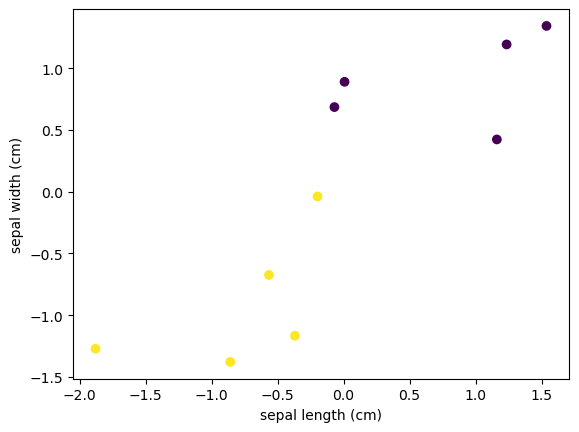

In [4]:
n = 10
selected_X, selected_y = select_n_points(data_X, data_y, n)
scaler = StandardScaler()
selected_X = scaler.fit_transform(selected_X)
_, ax = plt.subplots()
scatter = ax.scatter(selected_X[:, 0], selected_X[:, 1], c=selected_y)
ax.set(xlabel='sepal length (cm)', ylabel='sepal width (cm)')

In [5]:
# Define the plotting function
def plot_svm_decision_boundary(X, y, w, b, feature_x_idx, feature_y_idx):
    plt.figure(figsize=(8, 6))
    
    # Plot the two classes
    plt.scatter(X[y > 0][:, feature_x_idx], X[y > 0][:, feature_y_idx], c='b', label='Iris versicolor')
    plt.scatter(X[y < 0][:, feature_x_idx], X[y < 0][:, feature_y_idx], c='r', label='Iris setosa')

    # Plot decision boundary
    x_min, x_max = X[:, feature_x_idx].min() - 1, X[:, feature_x_idx].max() + 1
    y_min, y_max = X[:, feature_y_idx].min() - 1, X[:, feature_y_idx].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                         np.arange(y_min, y_max, 0.02))
    
    # Use only the selected features for the decision boundary
    grid = np.c_[xx.ravel(), yy.ravel()]
    Z = np.dot(grid, w[[feature_x_idx, feature_y_idx]]) + b
    Z = Z.reshape(xx.shape)
    
    plt.contour(xx, yy, Z, colors='k', levels=[0], alpha=0.5, linestyles=['-'])
    plt.contour(xx, yy, Z, colors='k', levels=[-1, 1], alpha=0.5, linestyles=['--'])
    
    plt.xlabel(f'mean radius')
    plt.ylabel(f'mean concave points')
    plt.legend()
    plt.title('Soft Margin SVM Decision Boundary')
    plt.show()
    
# Define the modified plotting function to plot two decision boundaries
def plot_svm_decision_boundary_confrontation(X, y, w_1, b_1, w_2, b_2, feature_x_idx, feature_y_idx):
    plt.figure(figsize=(8, 6))
    
    # Plot the two classes
    plt.scatter(X[y > 0][:, feature_x_idx], X[y > 0][:, feature_y_idx], c='b', label='Iris versicolor')
    plt.scatter(X[y < 0][:, feature_x_idx], X[y < 0][:, feature_y_idx], c='r', label='Iris setosa')

    # Create mesh grid for decision boundaries
    x_min, x_max = X[:, feature_x_idx].min() - 1, X[:, feature_x_idx].max() + 1
    y_min, y_max = X[:, feature_y_idx].min() - 1, X[:, feature_y_idx].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                         np.arange(y_min, y_max, 0.02))
    
    grid = np.c_[xx.ravel(), yy.ravel()]
    
    # First model's decision boundary (Ground Truth) in orange with highlight effect (thicker and transparent)
    Z1 = np.dot(grid, w_1[[feature_x_idx, feature_y_idx]]) + b_1
    Z1 = Z1.reshape(xx.shape)
    ground_truth = plt.contour(xx, yy, Z1, colors='purple', levels=[0], alpha=0.3, linewidths=5, linestyles=['-'])
    plt.contour(xx, yy, Z1, colors='purple', levels=[-1, 1], alpha=0.3, linewidths=3, linestyles=['--'])
    
    # Second model's decision boundary (ODE Solution) in purple
    Z2 = np.dot(grid, w_2[[feature_x_idx, feature_y_idx]]) + b_2
    Z2 = Z2.reshape(xx.shape)
    ode_solution = plt.contour(xx, yy, Z2, colors='green', levels=[0], alpha=0.8, linewidths=2, linestyles=['-'])
    plt.contour(xx, yy, Z2, colors='green', levels=[-1, 1], alpha=0.8, linewidths=1.5, linestyles=['--'])
    
    # Add the two main lines to the legend
    h1, _ = ground_truth.legend_elements()
    h2, _ = ode_solution.legend_elements()
    legend_elements = [h1[0], h2[0], 
                       plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='b', markersize=10),
                       plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='r', markersize=10)]
    legend_labels = ['Ground Truth', 'ODE Solution', 'Iris versicolor', 'Iris setosa']
    plt.legend(legend_elements, legend_labels, loc='upper right')
    
    # Add labels, title, and show the plot
    plt.xlabel(f'mean radius')
    plt.ylabel(f'mean concave points')
    plt.title('SVM Decision Boundaries')
    plt.show()

In [6]:
def adjust_label_positions(positions, min_distance=0.02):
    """Adjust vertical positions of labels to avoid overlap."""
    sorted_positions = sorted(enumerate(positions), key=lambda x: x[1])
    adjusted_positions = positions.copy()
    
    for i in range(1, len(sorted_positions)):
        curr_idx, curr_pos = sorted_positions[i]
        prev_idx, prev_pos = sorted_positions[i-1]
        
        if curr_pos - prev_pos < min_distance:
            adjusted_positions[curr_idx] = prev_pos + min_distance
    
    return adjusted_positions

def plot_ode_system(t_values, y_values):
    plt.figure(figsize=(8, 6))
    # Enable LaTeX rendering
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif')

    # Plot each line and prepare label information
    labels = [f'w_{i}' for i in range(1,3)] + ['b'] + [f'u_{i}' for i in range(1, 11)]
    colors = plt.cm.rainbow(np.linspace(0, 1, len(labels)))
    label_positions = []

    for i, (label, color) in enumerate(zip(labels, colors)):
        line = plt.plot(t_values, y_values[i, :], label=label, color=color)[0]
        label_positions.append(y_values[i, -1])

    # Adjust label positions
    y_min, y_max = np.min(y_values), np.max(y_values)
    y_range = y_max - y_min
    min_distance = 0.02 * y_range  # 2% of y-range as minimum distance
    adjusted_positions = adjust_label_positions(label_positions, min_distance)

    # Add adjusted labels with increased font size and space
    fontsize = 14  # Adjust the font size here
    x_offset = 1  # Space to move the label away from the line
    
    for i, (label, color, position) in enumerate(zip(labels[:3], colors[:3], adjusted_positions[:3])):
        math_label = f"${label}$"  # Add space with LaTeX's \quad
        x_end = t_values[-1]
        plt.text(x_end + x_offset, position, f' {math_label}', verticalalignment='center', 
                 horizontalalignment='left', color=color, fontsize=fontsize)

    plt.xlabel('Time', fontsize=fontsize)
    plt.ylabel('y(t)', fontsize=fontsize)
    plt.title('ODE System Solution', fontsize=fontsize)
    plt.grid(False)

    # Adjust the plot limits to make room for labels
    plt.xlim(t_values[0], t_values[-1] * 1.1)  # Extend x-axis by 10%
    plt.ylim(y_min - 0.1 * y_range, y_max + 0.1 * y_range)  # Extend y-axis by 10% on both ends

    plt.tight_layout()
    plt.show()

Time: 0.02553725242614746
Optimal objective value: 3.709515859318608
SCS solver iterations: 225
SCS solve time: 0.0032035
SCS setup time: 0.0063315739999999995
Optimal w:  [-0.56744205 -2.66402709]
Optimal b:  [0.78484479]
Dual variables (Lagrange multipliers): [ 0.07477805  0.         -0.          0.          3.63473733  0.
  0.          0.          3.7095154   0.        ]
Constraints: [-0.00000003 -3.1030004  -2.6627164  -1.903482   -0.00000004 -4.239632
 -2.0918639  -3.9456851   0.00000006 -0.58877146  0.00000001  0.
 -0.00000001  0.00000001  0.00000001 -0.         -0.00000002 -0.
 -0.00000003 -0.00000002]


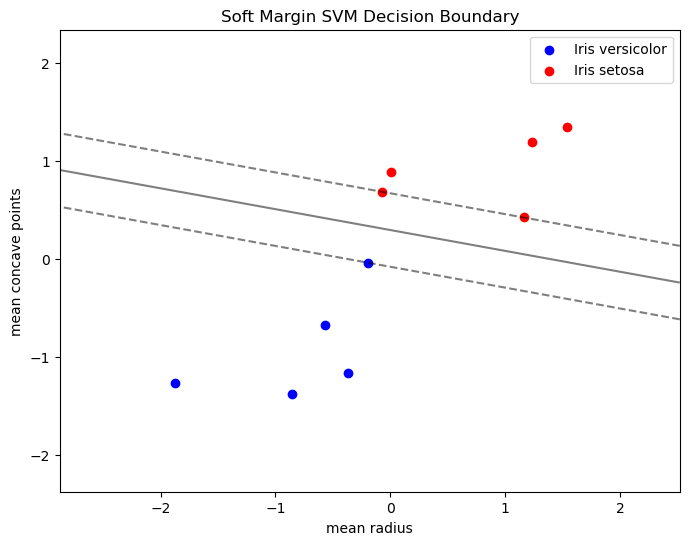

In [7]:
import cvxpy as cp
import numpy as np
import time

C = 10

num_features = selected_X.shape[1]

w = cp.Variable(num_features)
b = cp.Variable(1)
xi = cp.Variable(selected_y.shape[0])

objective = cp.Minimize((1/2)*cp.norm(w, 2)**2 + C * cp.sum(xi))

constraints = [
    cp.multiply(selected_y, cp.matmul(selected_X, w) + b) >= 1 - xi,
    xi >= 0
]

problem = cp.Problem(objective, constraints)

t0 = time.time()
problem.solve(solver='SCS')
solve_time = time.time() - t0

# Get solver stats
solver_stats = problem.solver_stats
print('Time:', solve_time)
print('Optimal objective value:', problem.value)
print('SCS solver iterations:', solver_stats.num_iters)
print('SCS solve time:', solver_stats.solve_time)
print('SCS setup time:', solver_stats.setup_time)

# Get the values of the variables
print('Optimal w: ', w.value)
print('Optimal b: ', b.value)

# Get the dual variables
dual_variables = constraints[0].dual_value
print('Dual variables (Lagrange multipliers):', dual_variables)

g_1 = [-selected_y[i] * (w.value @ selected_X[i] + b.value) + 1 for i in range(selected_y.shape[0])]
g_2 = [np.array([-xi.value[i]]) for i in range(selected_y.shape[0])]
g_SCS = jnp.array(g_1 + g_2).flatten()
print('Constraints:', g_SCS)

# Plotting
plot_svm_decision_boundary(selected_X, selected_y, w.value, b.value, 0, 1)

In [8]:
nw = selected_X.shape[1]
nb = 1
nxi = selected_y.shape[0]
nx = nw + nb + nxi
nu = selected_X.shape[0] * 2
NY = nx+nu

def f(x):
    w = x[:nw]
    b = x[nw]
    xi = x[nw+nb:]
    
    output = (1/2) * jnp.linalg.norm(w, 2)**2 + C * jnp.sum(xi)
    return output

def g(x):
    w = x[:nw]
    b = x[nw]
    xi = x[nw+nb:]
    
    g_1 = [-selected_y[i] * (w @ selected_X[i] + b) + 1 - xi[i] for i in range(selected_y.shape[0])]
    g_2 = [- xi[i] for i in range(selected_y.shape[0])]
    output = jnp.array(g_1 + g_2)
    return output

df = fgrad(f) # jacobian of f
dg = jacrev(g) # jacobian of g

def P(xu): # projection mapping
    return xu

def ODE(t, xu):
    x, u = xu[:nx].reshape((nx, )), xu[nx:].reshape((nu, ))

    dx = df(x) + dg(x).T@jnp.clip(u+g(x), a_min=0)
    dx = -dx
    du = -u + jnp.clip(u+g(x), a_min=0)
    du = 0.5*du
    dxu = jnp.concatenate([dx, du], axis=0)
    return dxu

ODE = jit(ODE)

def evalutation(xu): # metric OuC(x_pred): check if inisde feasable region and return the objective value
    "return  f(x),    if g(x)<=0, f(x)=np.inf, if g(x)>0 "
    x, u= xu[:nx], xu[nx:]
    if (g(x)<=0.001).all():
        obj = f(x)
        #print('g(x) values:', g(x))
    else:
        obj = np.inf
        #print('g(x) values:', g(x))
    return obj


def constraints_diff(g_ODE, g_SCS):
    return jnp.abs(g_ODE - g_SCS).max()

In [9]:
def solve_ODE(xu0, T):
    sol = solve_ivp(ODE, [0., T], xu0, method=NUMERICAL_METHOD)
    result = P(sol.y[:, -1])
    print("objective:",evalutation(result))
    print("Constraints:",g(result[:nx]))
    diff = constraints_diff(g(result[:nx]), g_SCS)
    print("max diff:", diff.max(), "mean diff:", diff.mean())
    print("w diff:", jnp.abs(result[:nw] - w.value), "b diff:", jnp.abs(result[nw] - b.value))

    return sol, result

objective: 3.7114348
Constraints: [-0.00010777 -3.0986464  -2.66028    -1.9007286   0.00058806 -4.2356677
 -2.0897448  -3.9409127   0.00049293 -0.5870009   0.00009573 -0.00000019
 -0.00000032 -0.00000015 -0.00059128 -0.00000012 -0.00000043 -0.00000045
 -0.00048416  0.00000033]
max diff: 0.0047724247 mean diff: 0.0047724247
w diff: [0.00047121 0.00306423] b diff: [0.00095196]


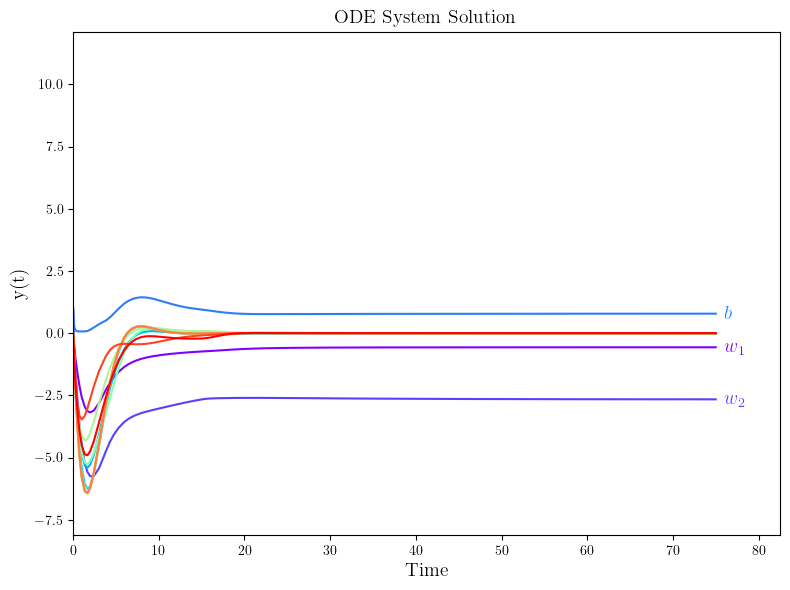

In [10]:
xu0 = jnp.zeros(NY)
xu0 = xu0.at[:nw + nb].set(1.0)

sol, result = solve_ODE(xu0, 75)

t_values = sol.t
y_values = sol.y

w_ode = result[:data_X.shape[1]]
b_ode = result[data_X.shape[1]]

plot_ode_system(t_values, y_values)

plot_svm_decision_boundary_confrontation(selected_X, selected_y, w.value, b.value, w_ode, b_ode, 0, 1)

In [11]:
t0 = time.time()
sol, result = solve_ODE(xu0, 20)
solve_time = time.time() - t0
print('Time:', solve_time)

objective: inf
Constraints: [-0.02836687 -3.0472093  -2.6930568  -1.8908901   0.02201586 -4.2793818
 -2.1110811  -3.9099138  -0.00598666 -0.5473313   0.03292168 -0.00045718
 -0.00048971  0.00003608 -0.01600005 -0.00049254 -0.00048809 -0.00049122
 -0.00403096 -0.00403006]
max diff: 0.05579114 mean diff: 0.05579114
w diff: [0.06754335 0.06181129] b diff: [0.00902363]
Time: 0.3806617259979248


In [12]:
t0 = time.time()
sol, result = solve_ODE(xu0, 75)
solve_time = time.time() - t0
print('Time:', solve_time)

objective: 3.7114348
Constraints: [-0.00010777 -3.0986464  -2.66028    -1.9007286   0.00058806 -4.2356677
 -2.0897448  -3.9409127   0.00049293 -0.5870009   0.00009573 -0.00000019
 -0.00000032 -0.00000015 -0.00059128 -0.00000012 -0.00000043 -0.00000045
 -0.00048416  0.00000033]
max diff: 0.0047724247 mean diff: 0.0047724247
w diff: [0.00047121 0.00306423] b diff: [0.00095196]
Time: 0.8632144927978516


In [13]:
t0 = time.time()
sol, result = solve_ODE(xu0, 100)
solve_time = time.time() - t0
print('Time:', solve_time)

objective: 3.7099805
Constraints: [-0.00002855 -3.1019986  -2.66216    -1.9028481   0.00013265 -4.238721
 -2.0913801  -3.9445877   0.00011525 -0.588366    0.00002105 -0.00000019
 -0.00000032 -0.00000015 -0.00013673 -0.00000012 -0.00000043 -0.00000045
 -0.00011088  0.00000033]
max diff: 0.0010974407 mean diff: 0.0010974407
w diff: [0.00010925 0.00070426] b diff: [0.00022049]
Time: 1.1445577144622803


# 3. The method

In [14]:
T=75.0

In [15]:
def g_batch(x):
    w = x[:, :nw]  # Extract w for each sample in the batch
    b = x[:, nw]   # Extract b for each sample in the batch

    # Compute g for each batch sample (2048) and constraint (10) using NumPy
    g = [[-selected_y[j] * (w[i] @ selected_X[j] + b[i]) + 1 for j in range(selected_y.shape[0])] for i in range(x.shape[0])]
    
    output = np.array(g)
    return output

In [16]:
class FNN(nn.Module):
    def __init__(self, y0):
        self.y0 = torch.tensor(y0, dtype=torch.float)
        if CUDA:
            self.y0 = self.y0.cuda()
        super(FNN, self).__init__()
        self.linear1 = nn.Linear(1, NEURONS).cuda()
        self.linearL = []
        for _ in range(LAYERS-1):
            self.linearL.append(nn.Linear(NEURONS, NEURONS).cuda())
        self.linear2 = nn.Linear(NEURONS, NY).cuda()

    def forward(self, x):
        t = x.cuda()
        x = torch.tanh(self.linear1(x))
        for i in range(LAYERS-1):
            x = torch.tanh(self.linearL[i](x))
        x = self.linear2(x)
        x = self.y0 + (1 - torch.exp(-(t-0)))*x
        return x


class NN_NOP:
    def __init__(self, y0, time_range, P, ODE, C_epsilon): # P: projection mapping, ODE, C_epsilon: OuC metric
        self.y0 = np.array(y0)
        self.time_range = time_range # [0, 10]
        self.T = time_range[-1] # T=10
        self.P = P
        self.ODE = ODE
        self.C_epsilon = C_epsilon
        self.vODE = vmap(ODE, in_axes=(0, 0), out_axes=0)
        #self.numerical_method() # solve analyicallly the ODE

    def numerical_method(self):
        sol = solve_ivp(self.ODE, self.time_range, self.y0, method=NUMERICAL_METHOD)
        self.y_T_ODE = sol.y[:, -1] # get last value of the solution
        self.y_T_ODE = self.P(self.y_T_ODE) # project it
        self.y_T_ODE = np.array(self.y_T_ODE)
        self.epsilon_ODE = self.C_epsilon(self.y_T_ODE) # calculate OuC (f(x))

    def NN_method(self, weights=None, t_L=None):
        """
        train the nn, store the following four

        L_loss:  list, loss of batch during training
        L_epsilon: list, epsilon_best during training
        L_y_T: list, yT during training
        net_best:  the best neural network model during training
        """
        net = FNN(self.y0)
        if weights is not None:
            net.load_state_dict(weights.state_dict())
        if CUDA:
            net = net.cuda()
            
        optimizer = Adam(net.parameters(), lr=LR) # ========> 0.001 not looks good
        i = 0
        L_loss = []
        L_epsilon = []
        L_epsilon_curr = []
        L_y_T = []
        L_y_T_curr = []
        #L_y_iterations = []
        t0 = time.time()
        while True:
            # Update, L_epsilon, L_yT, net_best
            T = self.T*torch.ones((1, 1), dtype=torch.float)
            if CUDA:
                T = T.cuda()
            y_T = self.P_multiple(T, net) # get the output of the nn at T (last time)
            L_y_T_curr.append(y_T)

            epsilon_current = self.C_epsilon(y_T) # calculate OuC (f(x))
            L_epsilon_curr.append(epsilon_current)
            if i==0: # if first iteration
                epsilon_best = epsilon_current
                y_T_best = y_T
                #y_T_error = np.linalg.norm(self.y_T_ODE-y_T_best, ord=2)
                net_best = deepcopy(net)
                #L_y_iterations.append(self.y_iteration(net_best))
            # if i==10:
            #     L_y_iterations.append(self.y_iteration(net_best))
            # if i==20:
            #     L_y_iterations.append(self.y_iteration(net_best))
            # if i==ITERATIONS-1:
            #L_y_iterations.append(self.y_iteration(net_best)) # store the output of the best nn across the time
            if epsilon_current < epsilon_best:
                epsilon_best = epsilon_current
                y_T_best = y_T
                #y_T_error = np.linalg.norm(self.y_T_ODE-y_T_best, ord=2)
                net_best = deepcopy(net)
            L_epsilon.append(epsilon_best) # store the best OuC
            L_y_T.append(y_T_best) # store the best output of the nn at T

            # TRAIN MODEL
            # Prepare input t, torch.tensor (NBATCH, 1)
            if t_L is not None:
                t = t_L[i]
            else:
                t = np.random.uniform(0, self.T, (NBATCH, 1))
            t = torch.tensor(t, dtype=torch.float, requires_grad=True)
            if CUDA:
                t = t.cuda()
            # Learning, L_loss
            loss = self.loss_compute(t, net)
            loss.backward()
            L_loss.append(loss.item())
            optimizer.step()
            optimizer.zero_grad()
            # Monitor
            if i%100==0:
            # if i in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 40, 50, 60, 70, 80, 90, 99]:
                #print(f'T: {self.T}, y_T_ODE: {self.y_T_ODE.round(4)}, epsilon_ODE: {self.epsilon_ODE :.4f},  Iteration: {i}, Loss: {loss.item() :.4f},  epsilon_best: {epsilon_best :.4f}, y_T: {y_T_best.round(4)}, ||y_T_ODE-y_T_best||_2: {y_T_error :.4f}')
                #print(f'T: {self.T}, Iteration: {i}, Loss: {loss.item() :.4f},  epsilon_best: {epsilon_best :.4f}, y_T: {y_T_best.round(4)}')
                pass
            i = i+1
            
            torch.cuda.empty_cache()
            
            if i==ITERATIONS:
                break

        return L_epsilon, L_epsilon_curr, L_y_T, L_y_T_curr, net_best, L_loss, time.time()-t0

    def loss_compute(self, t, net):
        # nn output xu, torch.tensor (NBATCH, nxu)
        y = net(t)

        # => Get ODE derivatives
        # True dxu, torch.tensor (NBATCH, nxu)
        t_cpu = t.cpu().detach().numpy()
        y_cpu = y[:, :].cpu().detach().numpy()
        dy = self.vODE(t_cpu, y_cpu)
        dy = np.array(dy)
        
        dy = torch.tensor(dy, dtype=torch.float)
        if CUDA:
            dy = dy.cuda()

        # => Get NN derivatives (autograd)
        # Predicted pdxu, torch.tensor (NBATCH, nxu)
        pdy = []
        for j in range(NY): # for all outputs node (for all variables)
            # y[:, [j]]: outputs of the nn for the j-th variable (all t of the batch), t: inputs of the nn, grad_outputs: scale the gradients to facilitate the compuation of the jacobian, Craete_graph: to compute higer order derivatives
            pdyi = grad(y[:, [j]], t, grad_outputs=torch.ones_like(y[:, [j]]), create_graph=True)[0] # torch autograd shape [NBATCH, 1]
            pdy.append(pdyi)
        pdy = torch.cat(pdy, dim=1) # for makning it a tensor: [NBATCH, NY]
        #pdy = torch.cat(pdy, dim=1) # for makning it a tensor: [NBATCH, NY]

        # 1. Dynamics loss
        # Compute loss, torch.tensor a float
        dynamics_loss = mse(dy, pdy) # [NBATCH, NY]
        dynamics_loss = torch.sum(dynamics_loss, axis=1) # [NBATCH]
        dynamics_loss = torch.exp(-WEIGTHING*((t / T).detach().reshape((-1, ))**2))*dynamics_loss  # proprity smaller t
        dynamics_loss = torch.mean(dynamics_loss, axis=0)
        
        # 2. Constraint violation penalty with smooth weighting
        FIXED_PENALTY = 1.0
        PENALTY_SCALE = 2.0
        epsilon = 1e-3
        
        x = y[:, :nx].cpu().detach().numpy()
        g_values = torch.tensor(g_batch(x)).cuda()
        
        penalty_mask = torch.tensor(g_values > epsilon, dtype=torch.float).cuda()
        
        logarithmic_penalty = torch.tensor(penalty_mask * (FIXED_PENALTY + PENALTY_SCALE * torch.log(g_values + 1.0))).cuda()
        
        constraint_loss = torch.sum(logarithmic_penalty, axis=1) # [NBATCH]
        constraint_weight  = torch.exp(-WEIGTHING * ((1 - t / T).detach().reshape((-1,))**2))
        constraint_loss = constraint_weight * constraint_loss
        constraint_loss = torch.mean(constraint_loss)
        
        # 4. Total loss
        loss = dynamics_loss + constraint_loss * CONSTRAINT_WEIGHT
        
        return loss

    def P_multiple(self, t, net): # get the projection of the output of the nn (for multiple t)
        y = net(t)
        y = y.reshape((-1, )).cpu().detach().numpy()
        output = self.P(y)
        output = np.array(output)
        return output

    def y_iteration(self, net): # get the ODE system estiamtion across the time
        # For L_y
        t = torch.arange(0, self.T, 0.1).reshape((-1, 1))
        if CUDA:
            t = t.cuda()
        y = [self.P_multiple(t[i].reshape((1,1)), net) for i in range(t.shape[0])]
        y = torch.tensor(np.array(y)).cpu().detach().numpy()

        return y # [T, NY]


In [17]:
y0 = np.zeros(NY)
y0[:nw + nb] = 1.0

In [18]:
def try_layers(l_list, n, lr):
     NEURONS = n
     LR = lr
     res = []
     for l in l_list:
          LAYERS = l
          example = NN_NOP(y0, [0, T], P, ODE, evalutation) # init
          L_epsilon, L_epsilon_curr, L_y_T, L_y_T_curr, net_best, L_loss, time = example.NN_method() # train
          mse_ = get_error({'net': net_best})
          print('LAYERS:', l, 'NEURONS:', n, 'LR:', lr, 'epsilon:', L_epsilon[-1], 'MSE solution:', mse_, 'time:', time)
          res.append({'layers': l, 'neurons': n, 'lr': lr, 'net': net_best, 'L_epsilon': L_epsilon, 'L_epsilon_curr': L_epsilon_curr, 'MSE soltion: ': mse_, 'time': time})
     return res

def try_neurons(n_list, l, lr):
     LAYERS = l
     LR = lr
     res = []
     for n in n_list:
          NEURONS = n
          example = NN_NOP(y0, [0, T], P, ODE, evalutation) # init
          L_epsilon, L_epsilon_curr, L_y_T, L_y_T_curr, net_best, L_loss, time = example.NN_method() # train
          mse_ = get_error({'net': net_best})
          print('LAYERS:', l, 'NEURONS:', n, 'LR:', lr, 'epsilon:', L_epsilon[-1], 'MSE solution:', mse_, 'time:', time)
          res.append({'layers': l, 'neurons': n, 'lr': lr, 'net': net_best, 'L_epsilon': L_epsilon, 'L_epsilon_curr': L_epsilon_curr, 'MSE soltion: ': mse_, 'time': time})
     return res

def try_lr(lr_list, l, n):
     LAYERS = l
     NEURONS = n
     res = []
     for lr in lr_list:
          LR = lr
          example = NN_NOP(y0, [0, T], P, ODE, evalutation) # init
          L_epsilon, L_epsilon_curr, L_y_T, L_y_T_curr, net_best, L_loss, time = example.NN_method() # train
          mse_ = get_error({'net': net_best})
          non_inifinty_ratio = len([num for num in L_epsilon_curr if not  np.isinf(num)]) / len(L_epsilon_curr)
          print('LAYERS:', l, 'NEURONS:', n, 'LR:', lr, 'epsilon:', L_epsilon[-1], 'MSE solution:', mse_, 'ratio:', non_inifinty_ratio, 'time:', time)
          res.append({'layers': l, 'neurons': n, 'lr': lr, 'net': net_best, 'L_epsilon': L_epsilon, 'L_epsilon_curr': L_epsilon_curr, 'mse': mse_, 'ratio': non_inifinty_ratio, 'time': time})
     return res

def plot_results(res, y_max=50):
    fig, axes = plt.subplots(1, len(res), figsize=(20, 6))
    y_min = 0
    for i in range(len(res)):
        # Plot on the first subplot
        axes[i].plot(res[i]['L_epsilon'], marker='o', linestyle='-', label='OuC metric best', markersize=1)
        axes[i].plot(res[i]['L_epsilon_curr'], marker='o', linestyle='-', label='OuC metric current', markersize=1)
        axes[i].set_xlabel('iteration')
        axes[i].set_ylabel('OuC metric')
        axes[i].set_title(f'l={res[i]["layers"]}, n={res[i]["neurons"]}, lr={res[i]["lr"]}')
        axes[i].legend()
        axes[i].grid(True)
        axes[i].set_ylim(y_min, y_max)
        axes[i].set_xlim(0, ITERATIONS)
    # Adjust layout to prevent overlapping
    plt.tight_layout()
    # Show the plot
    plt.show()

def plot_result_confrontation(res):
     plt.figure(figsize=(6, 5))
     for r in res:
          plt.plot(r['L_epsilon'], marker='o', linestyle='-', label=f'l={r["layers"]}, n={r["neurons"]}, lr={r["lr"]}', markersize=1)
     # Add labels, title, legend and grid
     plt.xlabel('iteration')
     plt.ylabel('OuC metric')
     plt.title('Numbers of layers')
     plt.legend()  # Show the legend to distinguish the datasets
     plt.grid(False)
     plt.show()

def plot_hyperplane(r):
     net = r['net']
     epsilon = net(torch.tensor([[T]]).cuda()).cpu().detach().numpy()
     w_net = epsilon[0][:selected_X.shape[1]]
     b_net = epsilon[0][selected_X.shape[1]]
     # Plotting
     plt.figure(figsize=(10, 8))
     plt.scatter(selected_X[selected_y > 0][:, 0], selected_X[selected_y > 0][:, 1], c='b', label='Class 1')
     plt.scatter(selected_X[selected_y < 0][:, 0], selected_X[selected_y < 0][:, 1], c='r', label='Class -1')

     # Plot the decision boundary
     x_min, x_max = selected_X[:, 0].min() - 1, selected_X[:, 0].max() + 1
     y_min, y_max = selected_X[:, 1].min() - 1, selected_X[:, 1].max() + 1
     xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                         np.arange(y_min, y_max, 0.02))
     Z = np.dot(np.c_[xx.ravel(), yy.ravel()], w_net) + b_net
     Z = Z.reshape(xx.shape)
     plt.contour(xx, yy, Z, colors='k', levels=[0], alpha=0.5, linestyles=['-'])

     # Plot the margins
     plt.contour(xx, yy, Z, colors='k', levels=[-1, 1], alpha=0.5, linestyles=['--'])

     plt.xlabel('Feature 1')
     plt.ylabel('Feature 2')
     plt.legend()
     plt.title('Hard Margin SVM Decision Boundary')
     plt.show()

def print_error(r):
     net = r['net']
     epsilon = net(torch.tensor([[T]]).cuda()).cpu().detach().numpy()
     # Split epsilon into weights and bias
     w_net = epsilon[0][:selected_X.shape[1]]  # All weights
     b_net = epsilon[0][selected_X.shape[1]]   # Bias

     # Calculate absolute differences for weights and bias
     w_abs_diff = np.abs(w_ode - w_net)         # Vector for all weights
     b_abs_diff = np.abs(b_ode - b_net)      # Single value for bias

     # Calculate squared differences
     w_sq_diff = w_abs_diff ** 2               # Vector for squared differences of weights
     b_sq_diff = b_abs_diff ** 2               # Squared difference for bias

     # Calculate the Mean Squared Error (MSE)
     mse_ = (np.sum(w_sq_diff) + b_sq_diff) / (len(w_sq_diff) + 1)

     # Print the absolute differences for all weights and bias
     print('w absolute differences:', w_abs_diff)
     print('b absolute difference:', b_abs_diff)

     # Print the MSE
     print('\nMSE between the two solutions:', mse_)

def get_error(r):
     net = r['net']
     epsilon = net(torch.tensor([[T]], dtype=torch.float32).cuda()).cpu().detach().numpy()
     # Split epsilon into weights and bias
     w_net = epsilon[0][:selected_X.shape[1]]  # All weights
     b_net = epsilon[0][selected_X.shape[1]]   # Bias

     # Calculate absolute differences for weights and bias
     w_abs_diff = np.abs(w_ode - w_net)         # Vector for all weights
     b_abs_diff = np.abs(b_ode - b_net)      # Single value for bias

     # Calculate squared differences
     w_sq_diff = w_abs_diff ** 2               # Vector for squared differences of weights
     b_sq_diff = b_abs_diff ** 2               # Squared difference for bias

     # Calculate the Mean Squared Error (MSE)
     mse_ = (np.sum(w_sq_diff) + b_sq_diff) / (len(w_sq_diff) + 1)

     return mse_

In [19]:
T=75.0
NBATCH = 512
ITERATIONS = 1000
NEURONS=100
LR=0.01
LAYERS=2
hyperparameter_combinations = []

/tmp/ipykernel_430497/2445299378.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  penalty_mask = torch.tensor(g_values > epsilon, dtype=torch.float).cuda()
/tmp/ipykernel_430497/2445299378.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  logarithmic_penalty = torch.tensor(penalty_mask * (FIXED_PENALTY + PENALTY_SCALE * torch.log(g_values + 1.0))).cuda()


LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 83.73654 MSE solution: 1.4422833787882174 ratio: 0.169 time: 102.563143491745
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 106.77672 MSE solution: 0.0853959263014345 ratio: 0.233 time: 99.41932487487793
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 108.94292 MSE solution: 0.8971316513932287 ratio: 0.164 time: 101.84638023376465
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 102.87163 MSE solution: 0.1621461756852179 ratio: 0.102 time: 108.67590498924255
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 99.60806 MSE solution: 1.472840741496657 ratio: 0.214 time: 101.47696948051453
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 89.93706 MSE solution: 1.243053365229151 ratio: 0.182 time: 100.10012292861938
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 106.64821 MSE solution: 1.0066875503712112 ratio: 0.122 time: 104.29300689697266
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 75.2331 MSE solution: 2.240899841991365 ratio: 0.185 time: 97.63360857963562
LAYERS: 2 NEURONS: 100 LR: 0.01 epsi

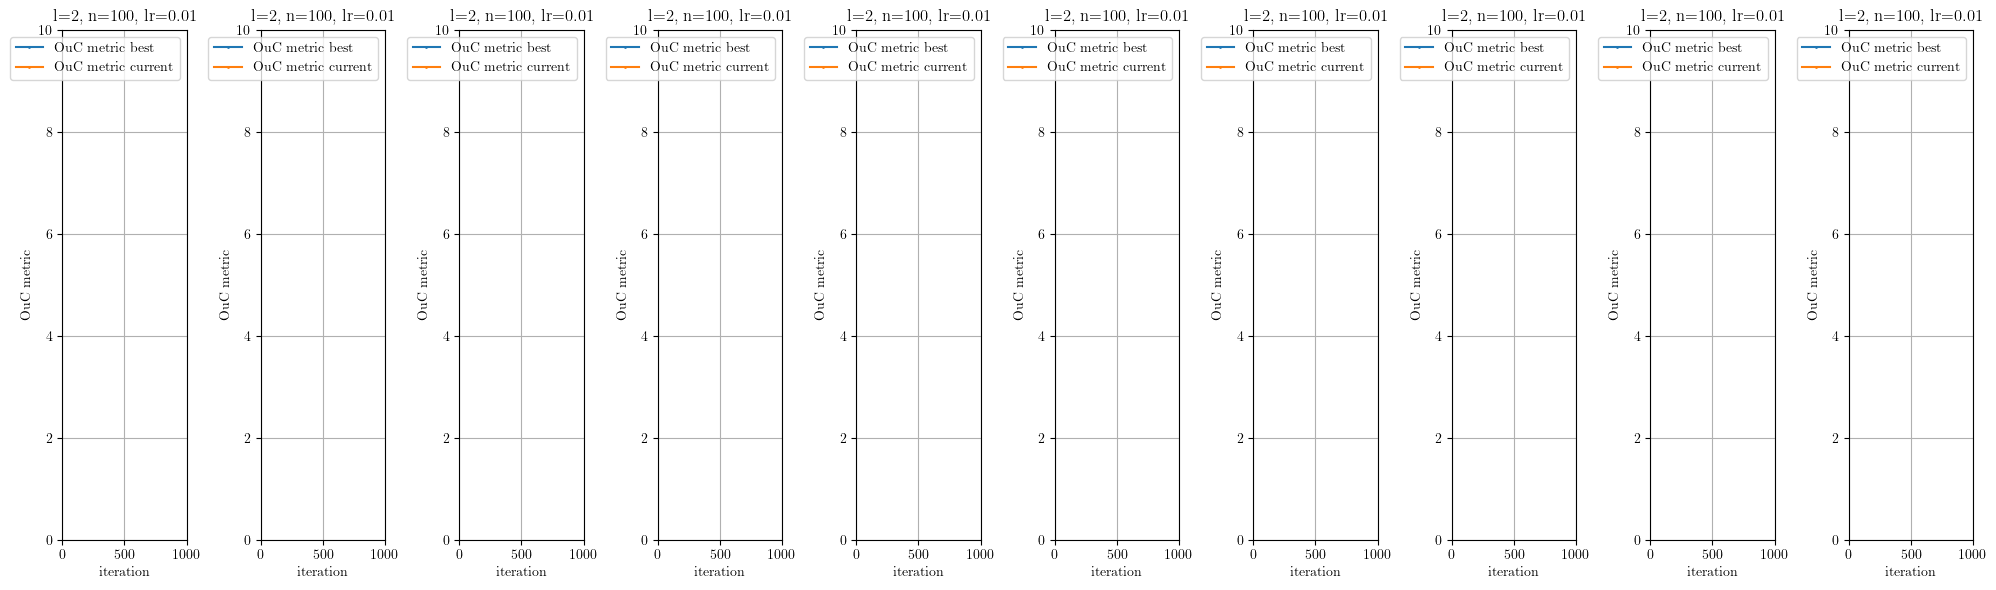

In [20]:
WEIGTHING = 1
CONSTRAINT_WEIGHT = 0
res_learning_rate = try_lr([0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01], 2, 100)
ratio_mean = 0
error_mean = 0
for r in res_learning_rate:
    ratio_mean += r['ratio']
    error_mean += r['mse']
ratio_mean /= len(res_learning_rate)
error_mean /= len(res_learning_rate)
hyperparameter_combinations.append({'WEIGHTING': WEIGTHING, 'CONSTRAINT_WEIGHT': CONSTRAINT_WEIGHT, 'ratio_mean': ratio_mean, 'error_mean': error_mean})
plot_results(res_learning_rate, y_max=10)
plot_result_confrontation(res_learning_rate)

/tmp/ipykernel_430497/2445299378.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  penalty_mask = torch.tensor(g_values > epsilon, dtype=torch.float).cuda()
/tmp/ipykernel_430497/2445299378.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  logarithmic_penalty = torch.tensor(penalty_mask * (FIXED_PENALTY + PENALTY_SCALE * torch.log(g_values + 1.0))).cuda()


LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 87.466965 MSE solution: 0.46514220680377316 ratio: 0.213 time: 101.27784872055054
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 100.91077 MSE solution: 3.7468706728925087 ratio: 0.141 time: 99.89386487007141
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 105.93487 MSE solution: 1.4028755542096984 ratio: 0.14 time: 96.79026508331299
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 89.81535 MSE solution: 0.02804182094722203 ratio: 0.152 time: 98.15308332443237
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 60.310883 MSE solution: 0.8606465271084124 ratio: 0.168 time: 94.311687707901
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 98.271454 MSE solution: 1.7750982254917058 ratio: 0.132 time: 96.27775430679321
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 90.79711 MSE solution: 0.9978646344415566 ratio: 0.205 time: 99.61730003356934
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 85.450775 MSE solution: 0.9789223237165618 ratio: 0.167 time: 99.0266375541687
LAYERS: 2 NEURONS: 100 LR: 0.01 eps

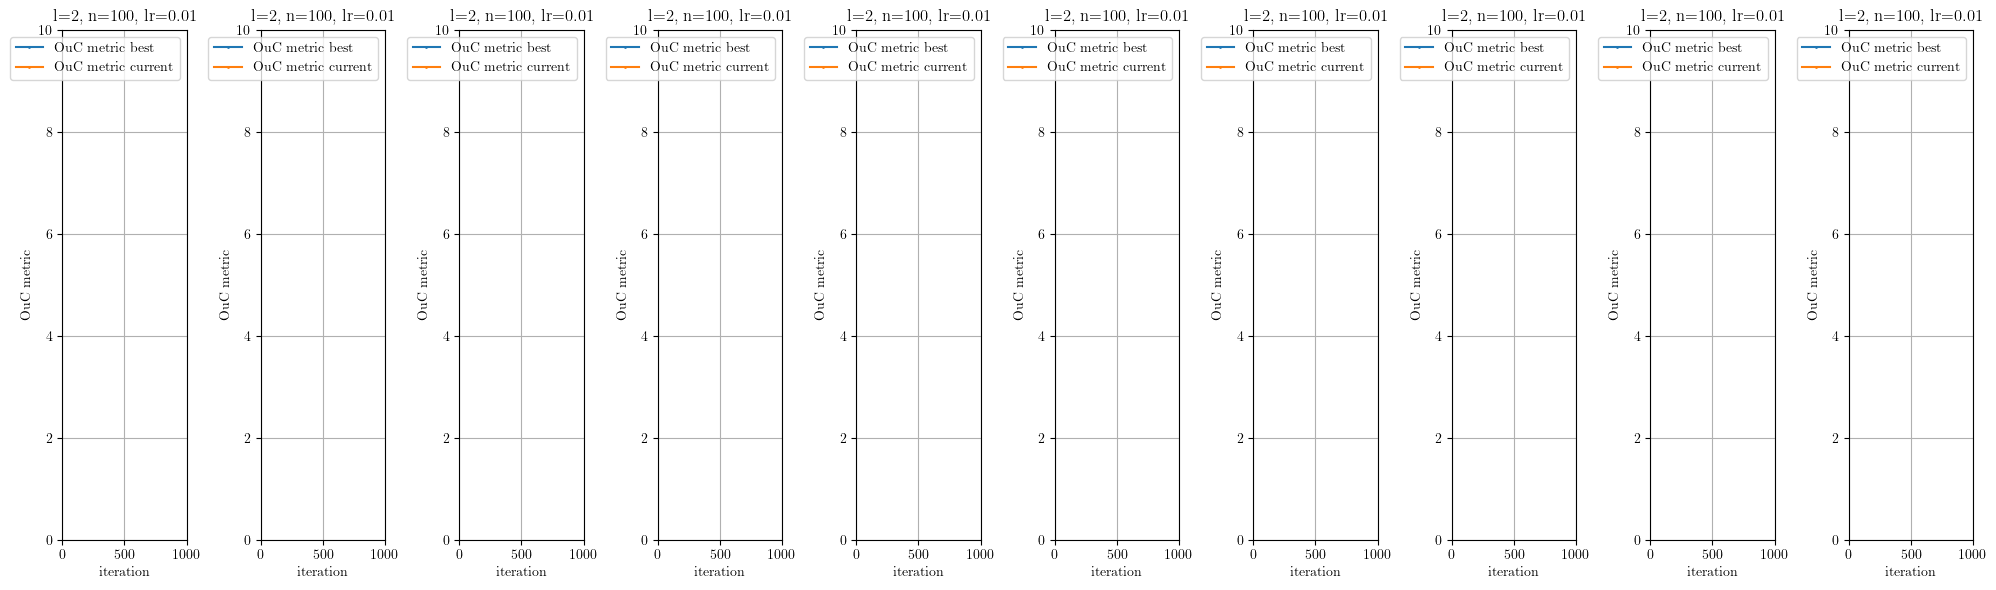

In [21]:
WEIGTHING = 2
CONSTRAINT_WEIGHT = 0
res_learning_rate = try_lr([0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01], 2, 100)
ratio_mean = 0
error_mean = 0
for r in res_learning_rate:
    ratio_mean += r['ratio']
    error_mean += r['mse']
ratio_mean /= len(res_learning_rate)
error_mean /= len(res_learning_rate)
hyperparameter_combinations.append({'WEIGHTING': WEIGTHING, 'CONSTRAINT_WEIGHT': CONSTRAINT_WEIGHT, 'ratio_mean': ratio_mean, 'error_mean': error_mean})
plot_results(res_learning_rate, y_max=10)
plot_result_confrontation(res_learning_rate)

/tmp/ipykernel_430497/2445299378.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  penalty_mask = torch.tensor(g_values > epsilon, dtype=torch.float).cuda()
/tmp/ipykernel_430497/2445299378.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  logarithmic_penalty = torch.tensor(penalty_mask * (FIXED_PENALTY + PENALTY_SCALE * torch.log(g_values + 1.0))).cuda()


LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 87.46961 MSE solution: 1.8673420210195932 ratio: 0.129 time: 96.11020469665527
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 92.2866 MSE solution: 0.5524633030924558 ratio: 0.182 time: 96.38008284568787
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 77.00305 MSE solution: 0.3817118175744519 ratio: 0.139 time: 103.19094133377075
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 79.91122 MSE solution: 0.7969811608247995 ratio: 0.195 time: 96.6454529762268
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 57.464806 MSE solution: 2.5774437333075584 ratio: 0.172 time: 99.04651546478271
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 71.99128 MSE solution: 2.1003955961973837 ratio: 0.19 time: 99.47329950332642
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 54.7666 MSE solution: 0.38316974142138616 ratio: 0.169 time: 101.50352382659912
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 85.33548 MSE solution: 5.661103297988678 ratio: 0.208 time: 97.03242087364197
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 

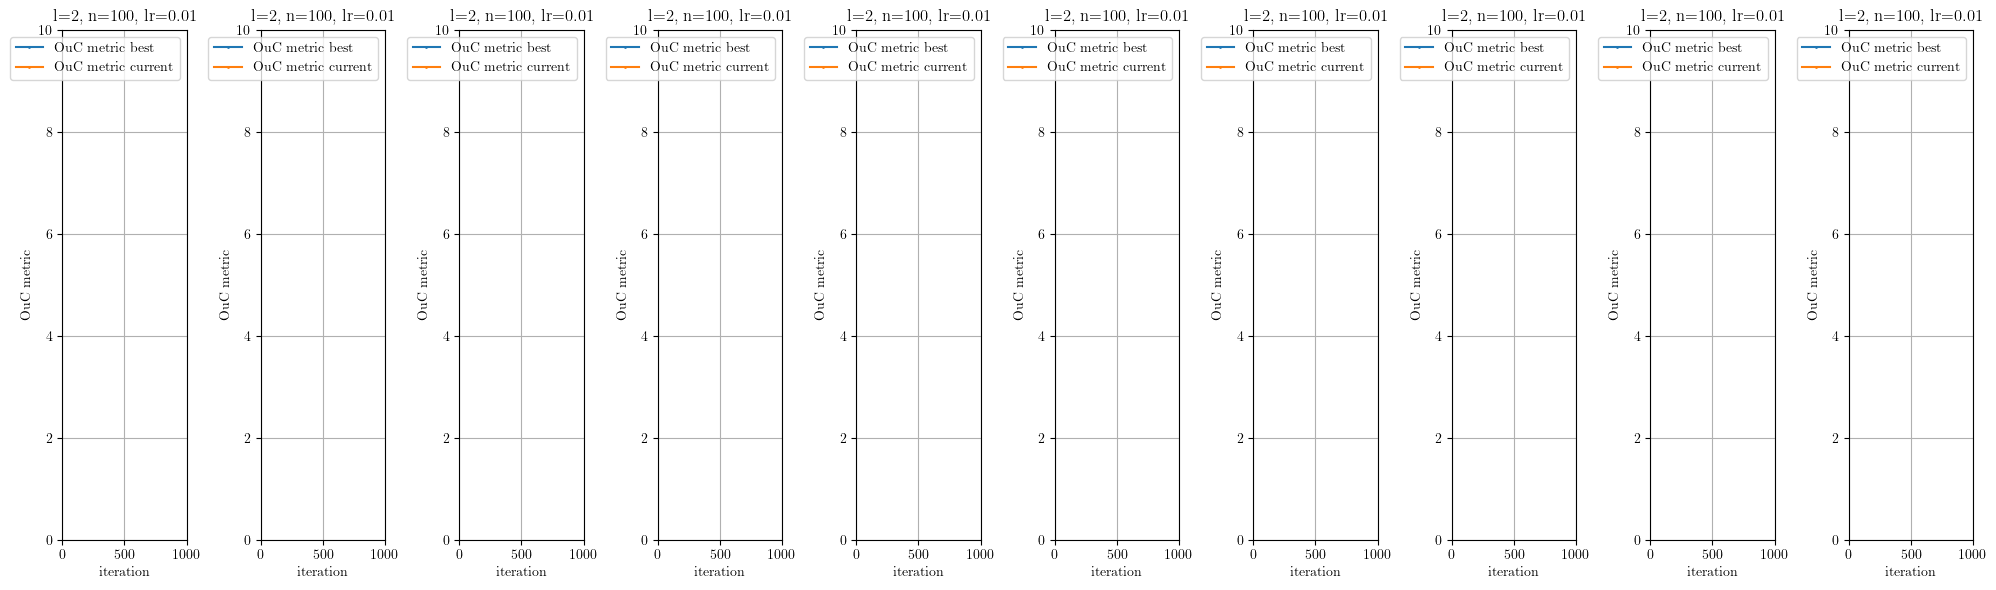

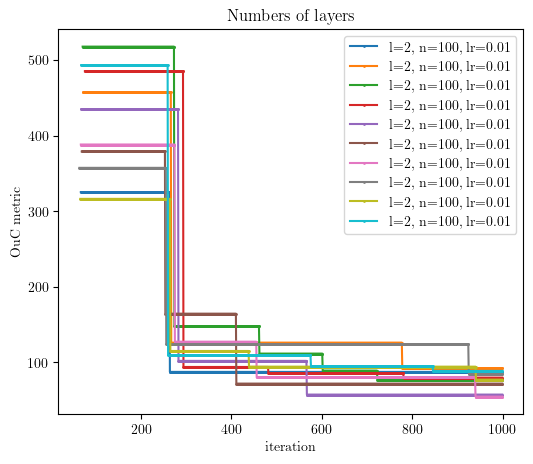

In [22]:
WEIGTHING = 4
CONSTRAINT_WEIGHT = 0
res_learning_rate = try_lr([0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01], 2, 100)
ratio_mean = 0
error_mean = 0
for r in res_learning_rate:
    ratio_mean += r['ratio']
    error_mean += r['mse']
ratio_mean /= len(res_learning_rate)
error_mean /= len(res_learning_rate)
hyperparameter_combinations.append({'WEIGHTING': WEIGTHING, 'CONSTRAINT_WEIGHT': CONSTRAINT_WEIGHT, 'ratio_mean': ratio_mean, 'error_mean': error_mean})
plot_results(res_learning_rate, y_max=10)
plot_result_confrontation(res_learning_rate)

/tmp/ipykernel_430497/2445299378.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  penalty_mask = torch.tensor(g_values > epsilon, dtype=torch.float).cuda()
/tmp/ipykernel_430497/2445299378.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  logarithmic_penalty = torch.tensor(penalty_mask * (FIXED_PENALTY + PENALTY_SCALE * torch.log(g_values + 1.0))).cuda()


LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 77.96204 MSE solution: 3.5881012874086626 ratio: 0.155 time: 93.51782417297363
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 101.25615 MSE solution: 0.05656733281599369 ratio: 0.189 time: 97.6070830821991
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 76.86264 MSE solution: 2.2683429115979052 ratio: 0.15 time: 97.0541181564331
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 56.14102 MSE solution: 2.7384734602730414 ratio: 0.169 time: 94.04415440559387
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 68.56211 MSE solution: 2.861018844819723 ratio: 0.166 time: 99.13076615333557
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 80.08023 MSE solution: 0.742504612926457 ratio: 0.181 time: 96.82977557182312
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 115.34967 MSE solution: 0.08212986891953059 ratio: 0.15 time: 96.6880214214325
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 72.922386 MSE solution: 1.7348531292255853 ratio: 0.171 time: 99.9674744606018
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 48

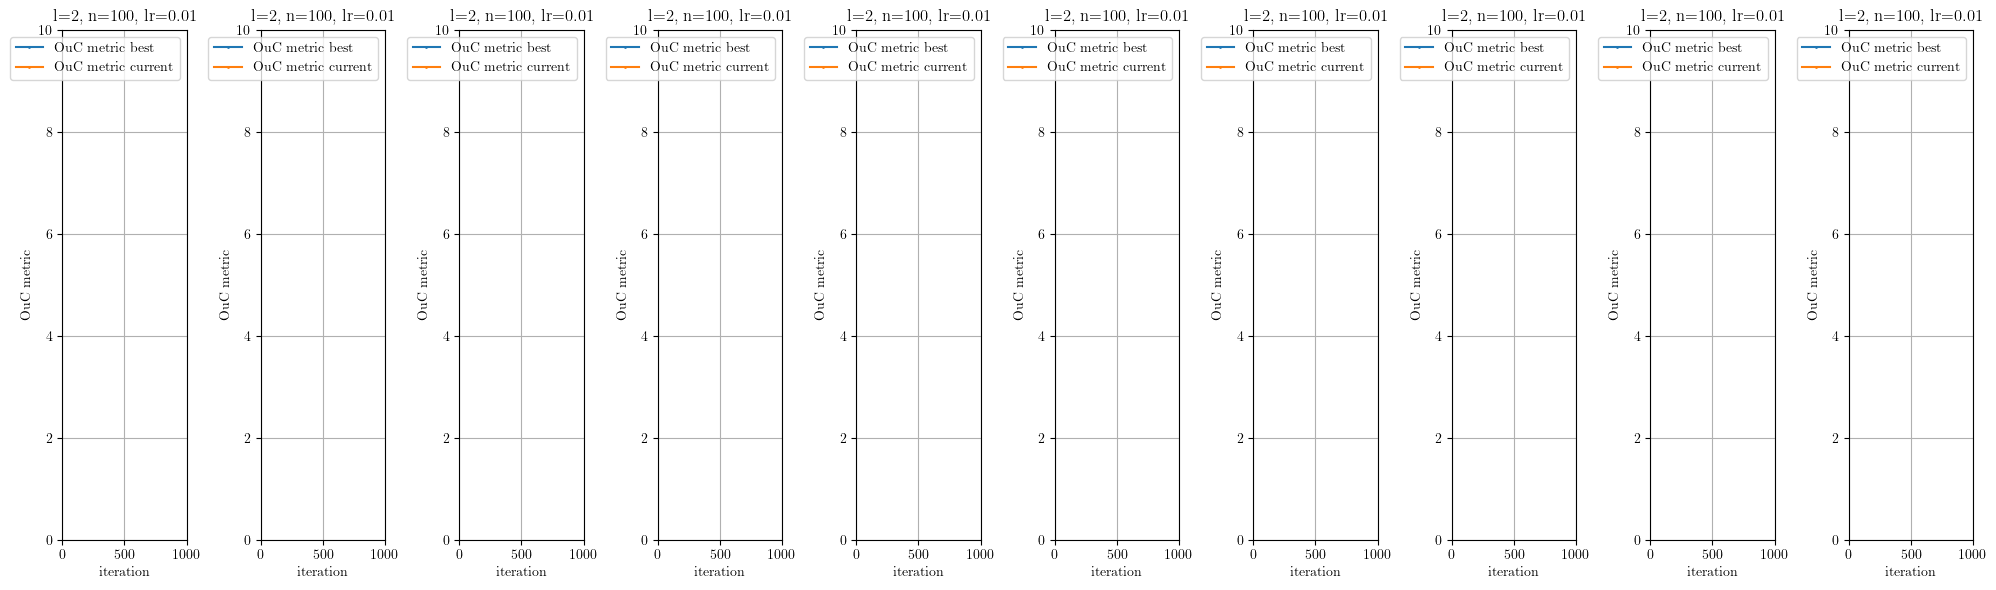

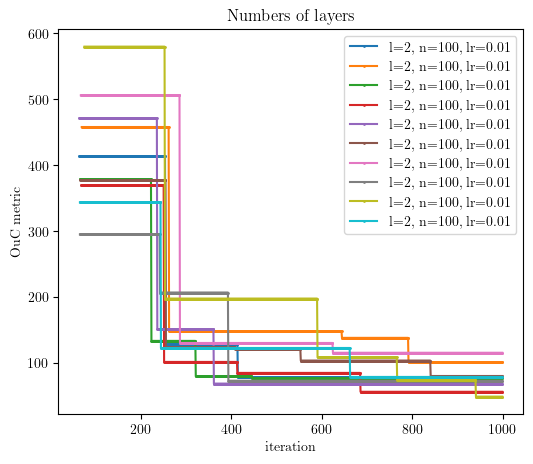

In [23]:
WEIGTHING = 8
CONSTRAINT_WEIGHT = 0
res_learning_rate = try_lr([0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01], 2, 100)
ratio_mean = 0
error_mean = 0
for r in res_learning_rate:
    ratio_mean += r['ratio']
    error_mean += r['mse']
ratio_mean /= len(res_learning_rate)
error_mean /= len(res_learning_rate)
hyperparameter_combinations.append({'WEIGHTING': WEIGTHING, 'CONSTRAINT_WEIGHT': CONSTRAINT_WEIGHT, 'ratio_mean': ratio_mean, 'error_mean': error_mean})
plot_results(res_learning_rate, y_max=10)
plot_result_confrontation(res_learning_rate)

/tmp/ipykernel_430497/2445299378.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  penalty_mask = torch.tensor(g_values > epsilon, dtype=torch.float).cuda()
/tmp/ipykernel_430497/2445299378.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  logarithmic_penalty = torch.tensor(penalty_mask * (FIXED_PENALTY + PENALTY_SCALE * torch.log(g_values + 1.0))).cuda()


LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 160.5027 MSE solution: 1.7478679179026486 ratio: 0.158 time: 93.50171065330505
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 63.305477 MSE solution: 0.25288725083935093 ratio: 0.162 time: 99.39756631851196
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 86.80279 MSE solution: 1.0661176232147376 ratio: 0.159 time: 96.89759063720703
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 112.23974 MSE solution: 2.6583683601480357 ratio: 0.244 time: 97.21441674232483
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 84.10506 MSE solution: 3.117424107078495 ratio: 0.177 time: 95.26613545417786
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 149.63882 MSE solution: 1.3065709666396634 ratio: 0.192 time: 93.15186953544617
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 95.80463 MSE solution: 0.7323318336584546 ratio: 0.142 time: 94.8426411151886
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 133.76418 MSE solution: 0.2504940137052043 ratio: 0.139 time: 93.58263421058655
LAYERS: 2 NEURONS: 100 LR: 0.01 epsil

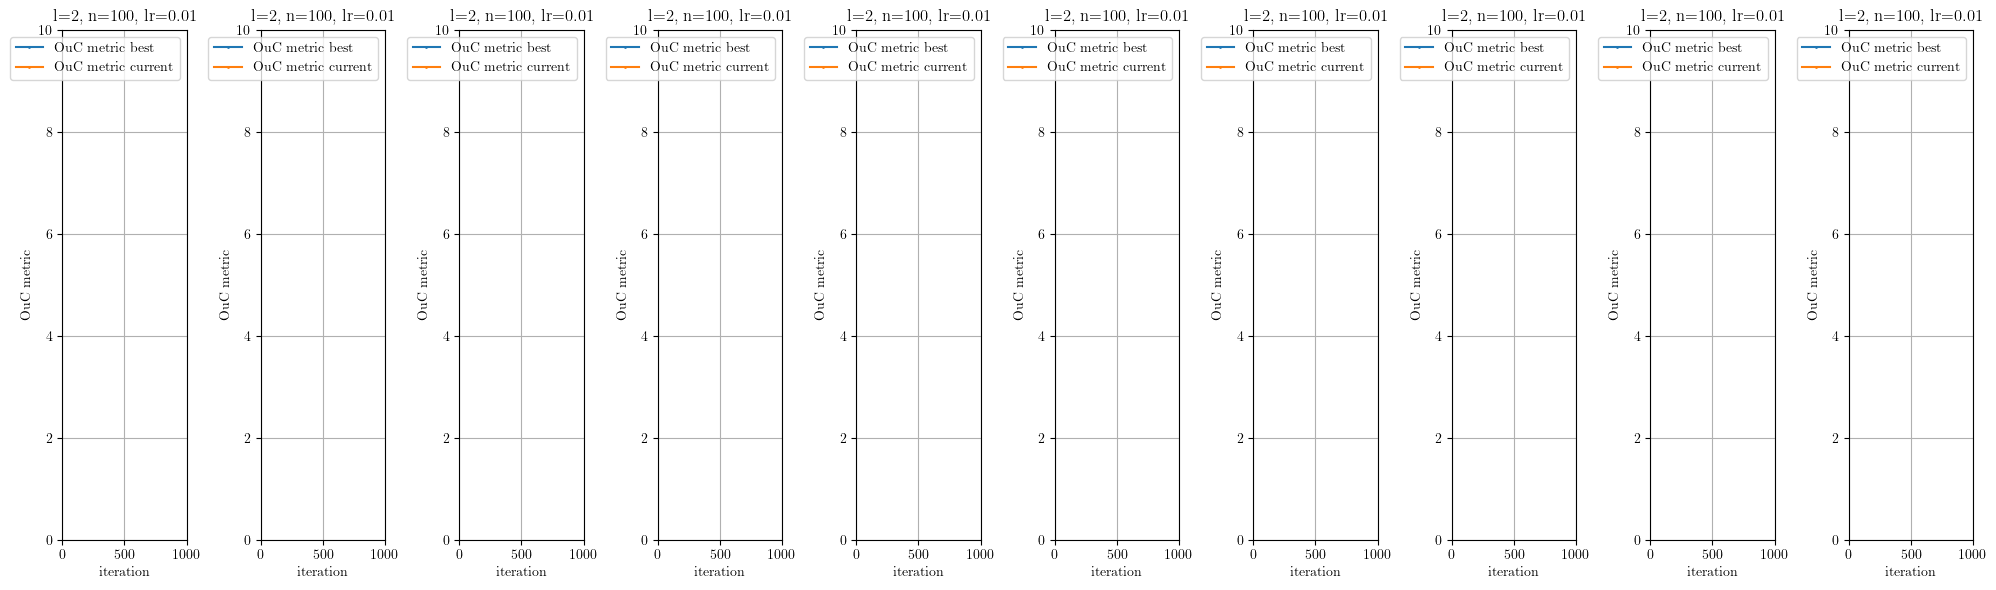

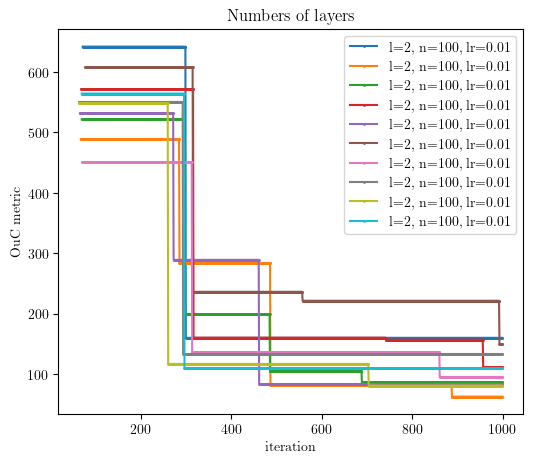

In [24]:
WEIGTHING = 1
CONSTRAINT_WEIGHT = 5.0
res_learning_rate = try_lr([0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01], 2, 100)
ratio_mean = 0
error_mean = 0
for r in res_learning_rate:
    ratio_mean += r['ratio']
    error_mean += r['mse']
ratio_mean /= len(res_learning_rate)
error_mean /= len(res_learning_rate)
hyperparameter_combinations.append({'WEIGHTING': WEIGTHING, 'CONSTRAINT_WEIGHT': CONSTRAINT_WEIGHT, 'ratio_mean': ratio_mean, 'error_mean': error_mean})
plot_results(res_learning_rate, y_max=10)
plot_result_confrontation(res_learning_rate)

/tmp/ipykernel_430497/2445299378.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  penalty_mask = torch.tensor(g_values > epsilon, dtype=torch.float).cuda()
/tmp/ipykernel_430497/2445299378.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  logarithmic_penalty = torch.tensor(penalty_mask * (FIXED_PENALTY + PENALTY_SCALE * torch.log(g_values + 1.0))).cuda()


LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 83.45754 MSE solution: 0.9755263426002584 ratio: 0.11 time: 95.85093998908997
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 122.13106 MSE solution: 2.0269696140259272 ratio: 0.146 time: 95.22730326652527
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 138.8814 MSE solution: 0.9904602050835329 ratio: 0.18 time: 98.50327515602112
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 84.08977 MSE solution: 0.3745811607853004 ratio: 0.253 time: 99.20813703536987
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 98.094055 MSE solution: 2.938691388603791 ratio: 0.264 time: 94.08276534080505
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 70.23711 MSE solution: 2.9735685338001168 ratio: 0.142 time: 92.34626984596252
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 71.293 MSE solution: 1.4424031578316878 ratio: 0.212 time: 96.24419331550598
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 31.597754 MSE solution: 1.0171574850797627 ratio: 0.172 time: 98.94748854637146
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 8

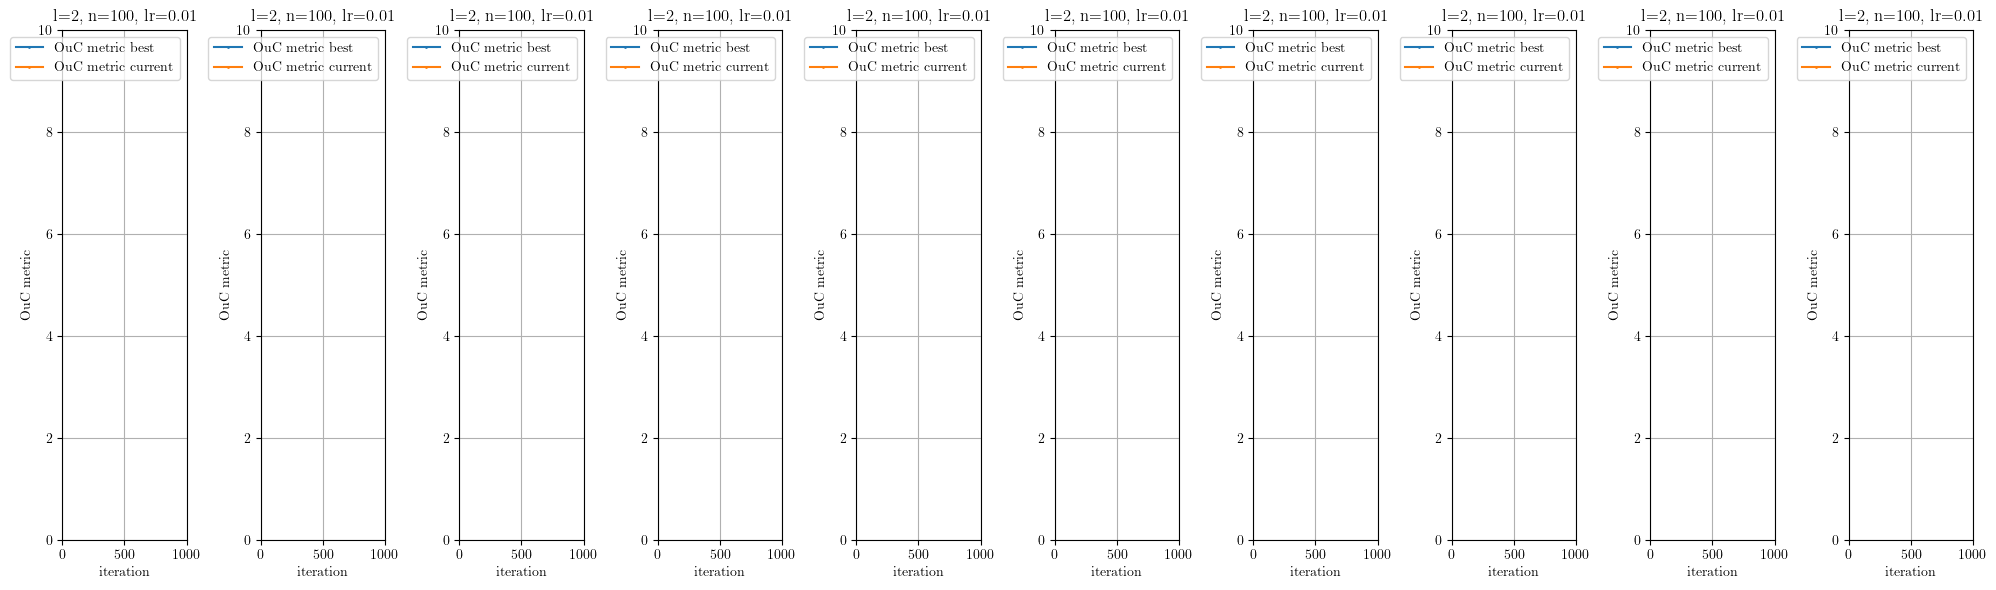

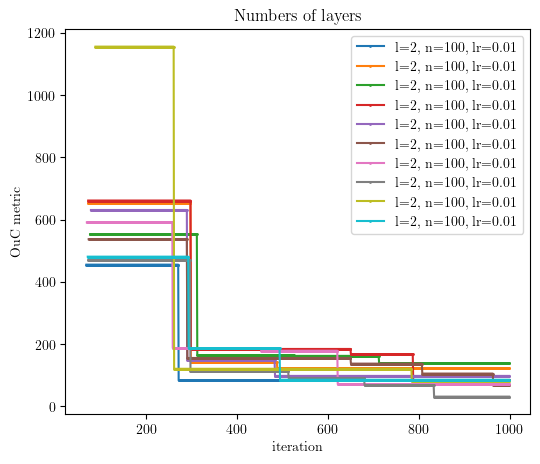

In [25]:
WEIGTHING = 1
CONSTRAINT_WEIGHT = 10.0
res_learning_rate = try_lr([0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01], 2, 100)
ratio_mean = 0
error_mean = 0
for r in res_learning_rate:
    ratio_mean += r['ratio']
    error_mean += r['mse']
ratio_mean /= len(res_learning_rate)
error_mean /= len(res_learning_rate)
hyperparameter_combinations.append({'WEIGHTING': WEIGTHING, 'CONSTRAINT_WEIGHT': CONSTRAINT_WEIGHT, 'ratio_mean': ratio_mean, 'error_mean': error_mean})
plot_results(res_learning_rate, y_max=10)
plot_result_confrontation(res_learning_rate)

/tmp/ipykernel_430497/2445299378.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  penalty_mask = torch.tensor(g_values > epsilon, dtype=torch.float).cuda()
/tmp/ipykernel_430497/2445299378.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  logarithmic_penalty = torch.tensor(penalty_mask * (FIXED_PENALTY + PENALTY_SCALE * torch.log(g_values + 1.0))).cuda()


LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 109.668304 MSE solution: 1.5127154098603783 ratio: 0.139 time: 94.36872100830078
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 80.60485 MSE solution: 2.4035316139604834 ratio: 0.206 time: 97.79126739501953
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 91.00866 MSE solution: 0.46177283624810644 ratio: 0.203 time: 98.4938805103302
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 131.87703 MSE solution: 1.624333109389607 ratio: 0.179 time: 95.03544449806213
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 149.35387 MSE solution: 3.135389741186227 ratio: 0.176 time: 95.44347786903381
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 65.26149 MSE solution: 0.8431794544739244 ratio: 0.192 time: 94.85522890090942
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 97.28989 MSE solution: 1.7500203185227605 ratio: 0.259 time: 91.41395425796509
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 117.309586 MSE solution: 0.5950946079585369 ratio: 0.235 time: 93.97674679756165
LAYERS: 2 NEURONS: 100 LR: 0.01 epsi

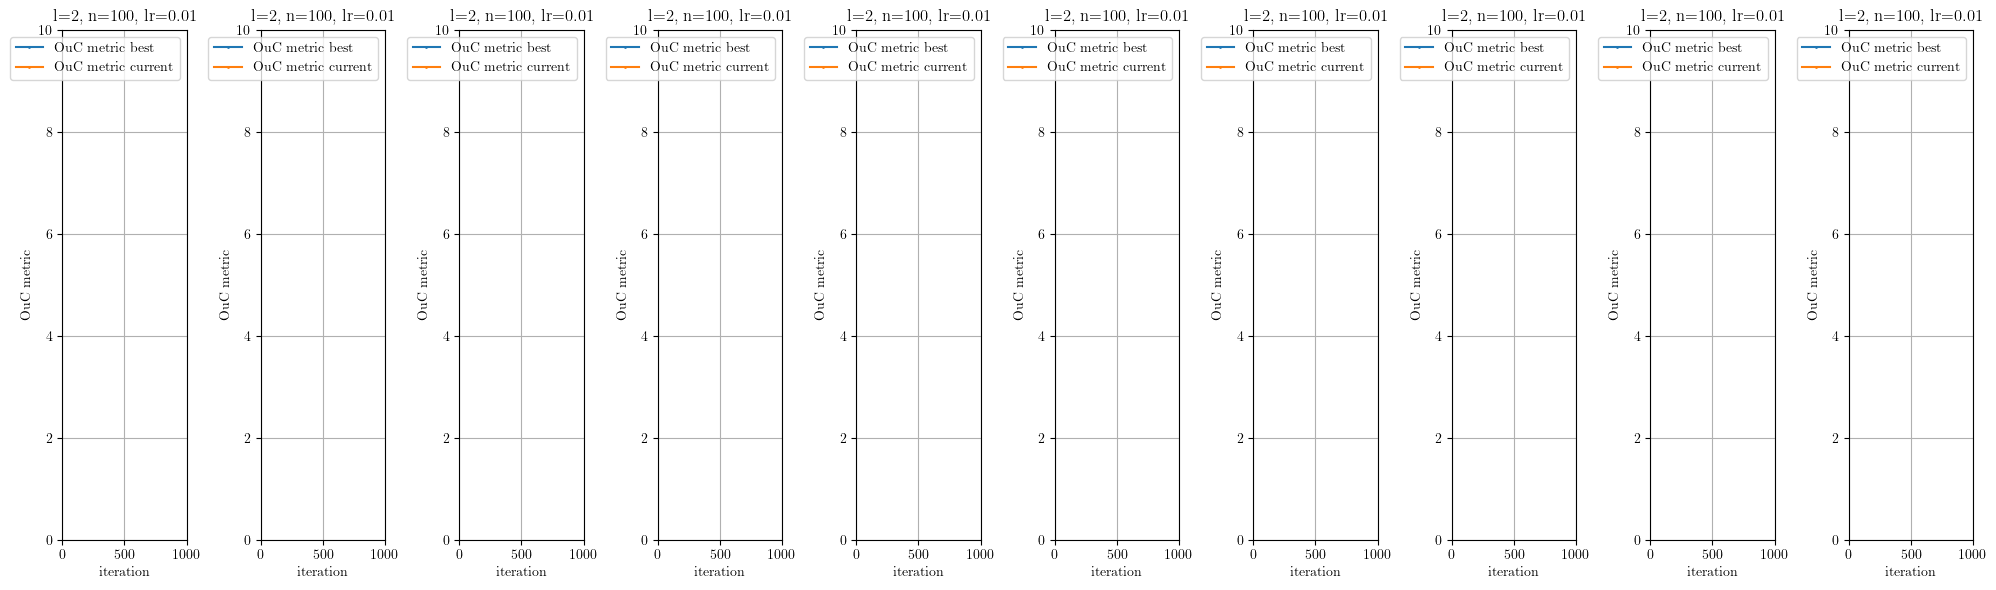

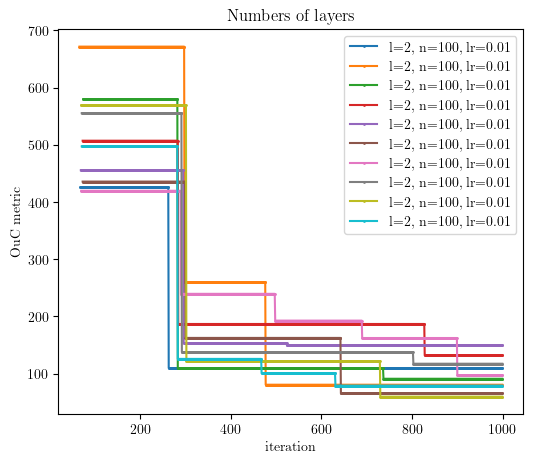

In [26]:
WEIGTHING = 1
CONSTRAINT_WEIGHT = 20.0
res_learning_rate = try_lr([0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01], 2, 100)
ratio_mean = 0
error_mean = 0
for r in res_learning_rate:
    ratio_mean += r['ratio']
    error_mean += r['mse']
ratio_mean /= len(res_learning_rate)
error_mean /= len(res_learning_rate)
hyperparameter_combinations.append({'WEIGHTING': WEIGTHING, 'CONSTRAINT_WEIGHT': CONSTRAINT_WEIGHT, 'ratio_mean': ratio_mean, 'error_mean': error_mean})
plot_results(res_learning_rate, y_max=10)
plot_result_confrontation(res_learning_rate)

/tmp/ipykernel_430497/2445299378.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  penalty_mask = torch.tensor(g_values > epsilon, dtype=torch.float).cuda()
/tmp/ipykernel_430497/2445299378.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  logarithmic_penalty = torch.tensor(penalty_mask * (FIXED_PENALTY + PENALTY_SCALE * torch.log(g_values + 1.0))).cuda()


LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 90.26486 MSE solution: 4.561239676149525 ratio: 0.202 time: 94.51783514022827
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 85.2344 MSE solution: 1.4887012044280394 ratio: 0.187 time: 100.36820101737976
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 129.78555 MSE solution: 0.11989980978960557 ratio: 0.225 time: 94.77166962623596
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 107.47511 MSE solution: 3.211842981287441 ratio: 0.183 time: 101.66776442527771
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 111.302216 MSE solution: 1.5320589808749314 ratio: 0.117 time: 97.63722085952759
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 75.54782 MSE solution: 1.5871851189356778 ratio: 0.142 time: 98.38967657089233
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 190.27138 MSE solution: 2.6726395690195814 ratio: 0.148 time: 98.22670531272888
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 131.36075 MSE solution: 0.15880674673253528 ratio: 0.104 time: 97.08327674865723
LAYERS: 2 NEURONS: 100 LR: 0.01 e

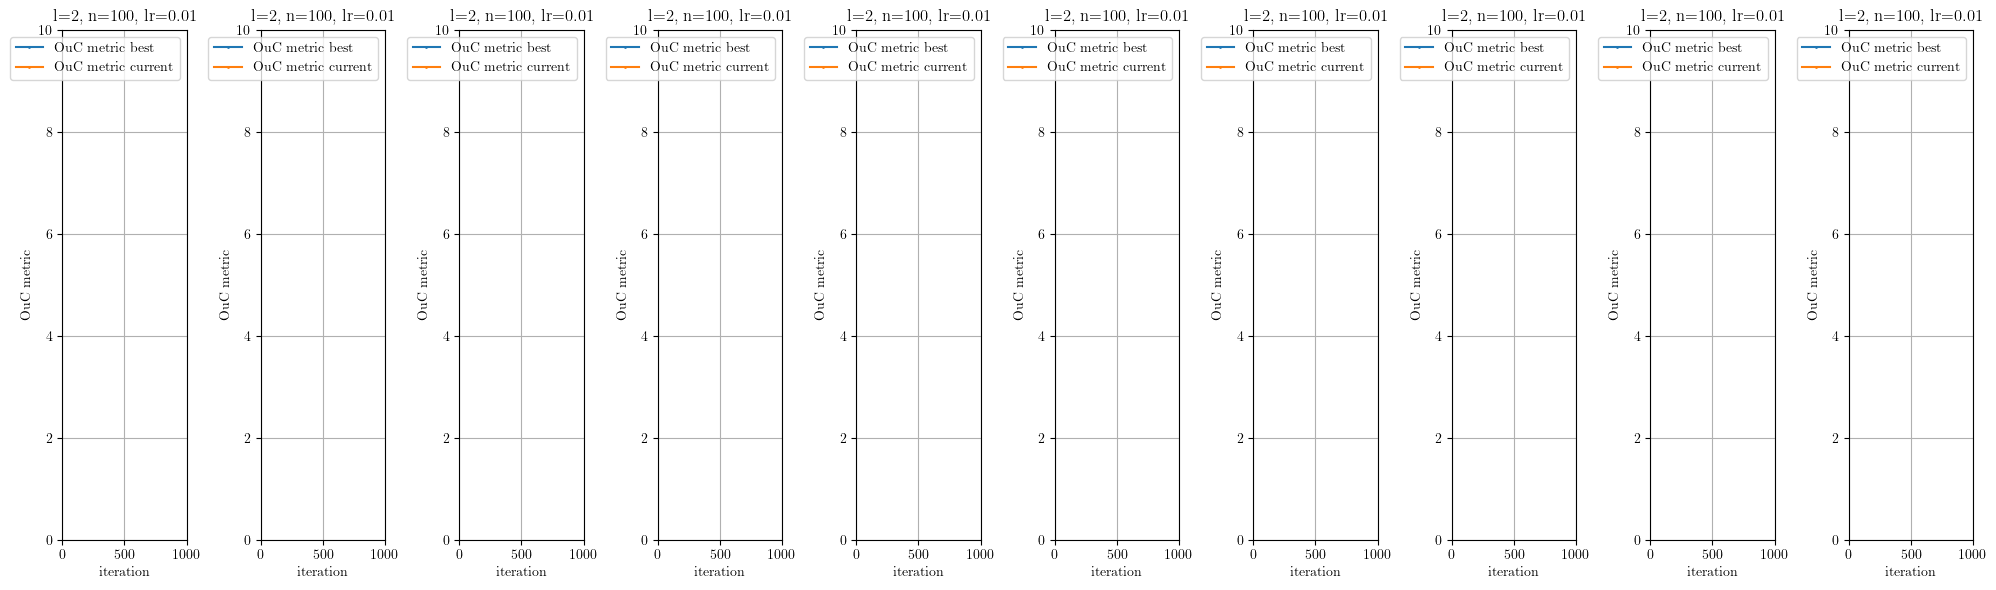

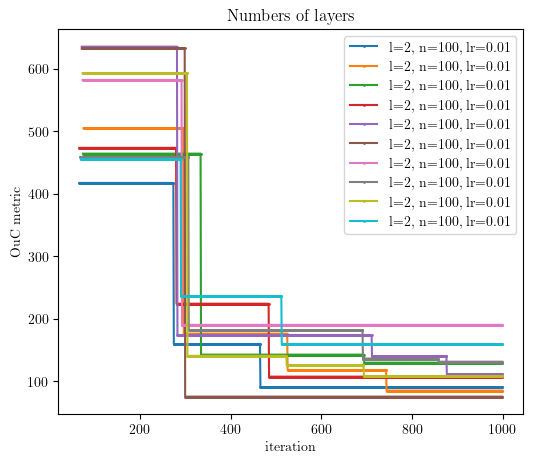

In [27]:
WEIGTHING = 1
CONSTRAINT_WEIGHT = 50.0
res_learning_rate = try_lr([0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01], 2, 100)
ratio_mean = 0
error_mean = 0
for r in res_learning_rate:
    ratio_mean += r['ratio']
    error_mean += r['mse']
ratio_mean /= len(res_learning_rate)
error_mean /= len(res_learning_rate)
hyperparameter_combinations.append({'WEIGHTING': WEIGTHING, 'CONSTRAINT_WEIGHT': CONSTRAINT_WEIGHT, 'ratio_mean': ratio_mean, 'error_mean': error_mean})
plot_results(res_learning_rate, y_max=10)
plot_result_confrontation(res_learning_rate)

/tmp/ipykernel_430497/2445299378.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  penalty_mask = torch.tensor(g_values > epsilon, dtype=torch.float).cuda()
/tmp/ipykernel_430497/2445299378.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  logarithmic_penalty = torch.tensor(penalty_mask * (FIXED_PENALTY + PENALTY_SCALE * torch.log(g_values + 1.0))).cuda()


LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 104.0355 MSE solution: 1.6830873263827277 ratio: 0.224 time: 96.88156032562256
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 84.59517 MSE solution: 3.2818284428309816 ratio: 0.171 time: 94.14859390258789
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 62.39827 MSE solution: 0.8452426377550256 ratio: 0.242 time: 93.25506782531738
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 53.209717 MSE solution: 1.3194659330166667 ratio: 0.216 time: 95.94162559509277
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 54.027657 MSE solution: 1.2612112630872794 ratio: 0.127 time: 101.21358752250671
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 104.980865 MSE solution: 0.7706838781754799 ratio: 0.196 time: 94.15955662727356
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 92.344864 MSE solution: 0.18388884587665275 ratio: 0.205 time: 95.23623919487
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 99.913574 MSE solution: 1.2802552425300937 ratio: 0.161 time: 92.56417560577393
LAYERS: 2 NEURONS: 100 LR: 0.01 eps

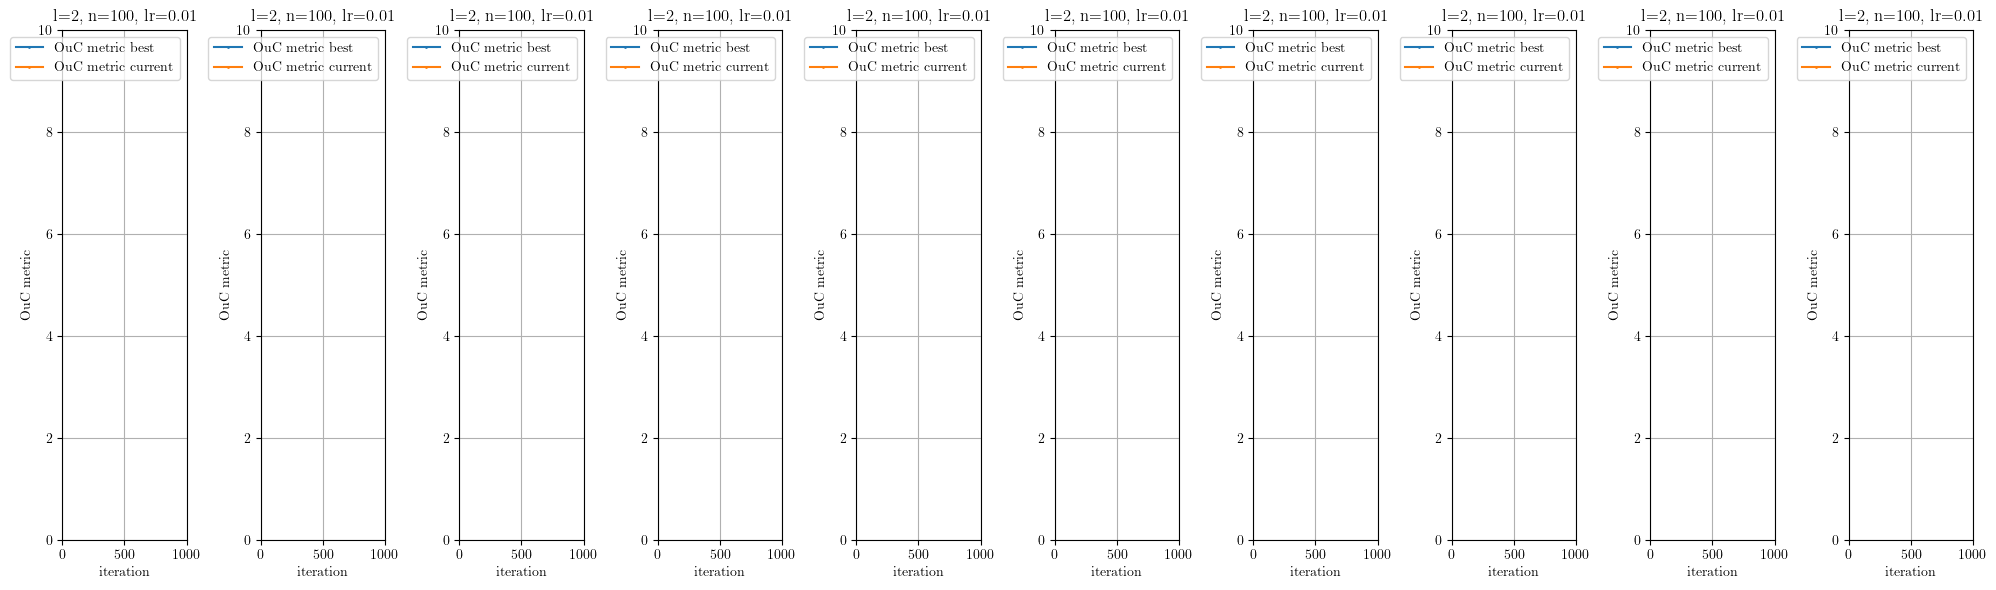

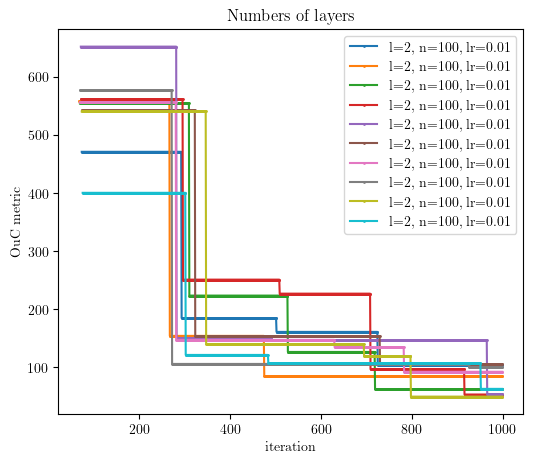

In [28]:
WEIGTHING = 1
CONSTRAINT_WEIGHT = 100.0
res_learning_rate = try_lr([0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01], 2, 100)
ratio_mean = 0
error_mean = 0
for r in res_learning_rate:
    ratio_mean += r['ratio']
    error_mean += r['mse']
ratio_mean /= len(res_learning_rate)
error_mean /= len(res_learning_rate)
hyperparameter_combinations.append({'WEIGHTING': WEIGTHING, 'CONSTRAINT_WEIGHT': CONSTRAINT_WEIGHT, 'ratio_mean': ratio_mean, 'error_mean': error_mean})
plot_results(res_learning_rate, y_max=10)
plot_result_confrontation(res_learning_rate)

/tmp/ipykernel_430497/2445299378.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  penalty_mask = torch.tensor(g_values > epsilon, dtype=torch.float).cuda()
/tmp/ipykernel_430497/2445299378.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  logarithmic_penalty = torch.tensor(penalty_mask * (FIXED_PENALTY + PENALTY_SCALE * torch.log(g_values + 1.0))).cuda()


LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 186.54027 MSE solution: 4.881639691405478 ratio: 0.142 time: 95.5478789806366
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 107.57707 MSE solution: 0.5946866441118043 ratio: 0.158 time: 96.35309505462646
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 165.43356 MSE solution: 1.1763120906321636 ratio: 0.18 time: 98.71761322021484
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 77.87037 MSE solution: 0.20479189814913404 ratio: 0.113 time: 100.60774421691895
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 82.86106 MSE solution: 5.863782694515121 ratio: 0.201 time: 99.70805311203003
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 90.75363 MSE solution: 1.6805637354045204 ratio: 0.217 time: 97.5760612487793
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 98.97148 MSE solution: 1.0467410300717812 ratio: 0.146 time: 97.19587850570679
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 98.333824 MSE solution: 2.2435610498854786 ratio: 0.13 time: 97.68767929077148
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon:

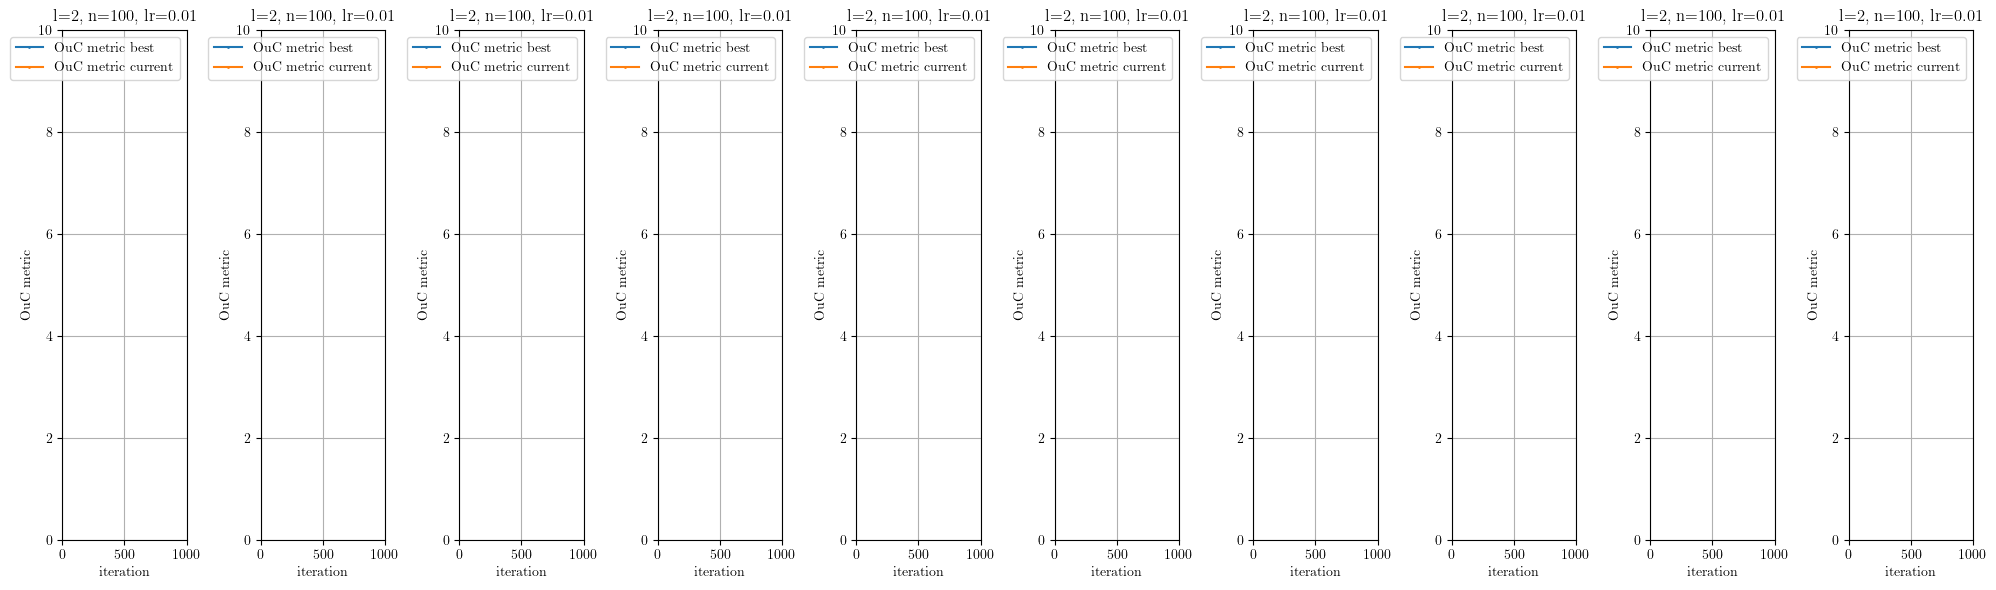

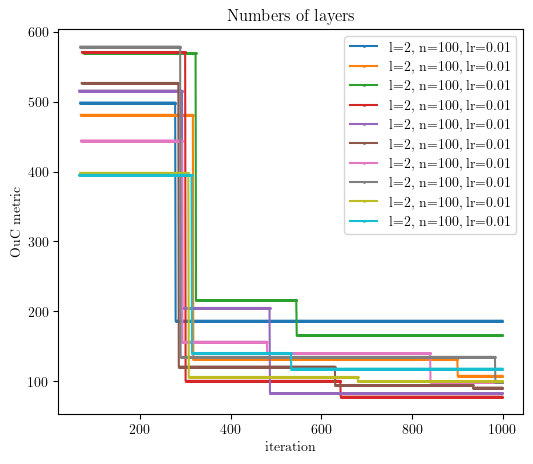

In [29]:
WEIGTHING = 1
CONSTRAINT_WEIGHT = 200.0
res_learning_rate = try_lr([0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01], 2, 100)
ratio_mean = 0
error_mean = 0
for r in res_learning_rate:
    ratio_mean += r['ratio']
    error_mean += r['mse']
ratio_mean /= len(res_learning_rate)
error_mean /= len(res_learning_rate)
hyperparameter_combinations.append({'WEIGHTING': WEIGTHING, 'CONSTRAINT_WEIGHT': CONSTRAINT_WEIGHT, 'ratio_mean': ratio_mean, 'error_mean': error_mean})
plot_results(res_learning_rate, y_max=10)
plot_result_confrontation(res_learning_rate)

/tmp/ipykernel_430497/2445299378.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  penalty_mask = torch.tensor(g_values > epsilon, dtype=torch.float).cuda()
/tmp/ipykernel_430497/2445299378.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  logarithmic_penalty = torch.tensor(penalty_mask * (FIXED_PENALTY + PENALTY_SCALE * torch.log(g_values + 1.0))).cuda()


LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 135.05862 MSE solution: 5.7716694641297535 ratio: 0.185 time: 96.27028155326843
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 134.77614 MSE solution: 2.891341844264756 ratio: 0.19 time: 103.71005010604858
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 71.40543 MSE solution: 0.9175042730089312 ratio: 0.172 time: 100.53300404548645
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 104.26833 MSE solution: 0.5027499042281378 ratio: 0.128 time: 97.10122108459473
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 150.0884 MSE solution: 0.5665400084699999 ratio: 0.167 time: 96.36830878257751
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 107.64604 MSE solution: 1.8317434348428572 ratio: 0.124 time: 97.51324701309204
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 95.551414 MSE solution: 0.2458131429740352 ratio: 0.263 time: 94.28059911727905
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 80.915535 MSE solution: 2.7991529089204157 ratio: 0.219 time: 95.5563611984253
LAYERS: 2 NEURONS: 100 LR: 0.01 eps

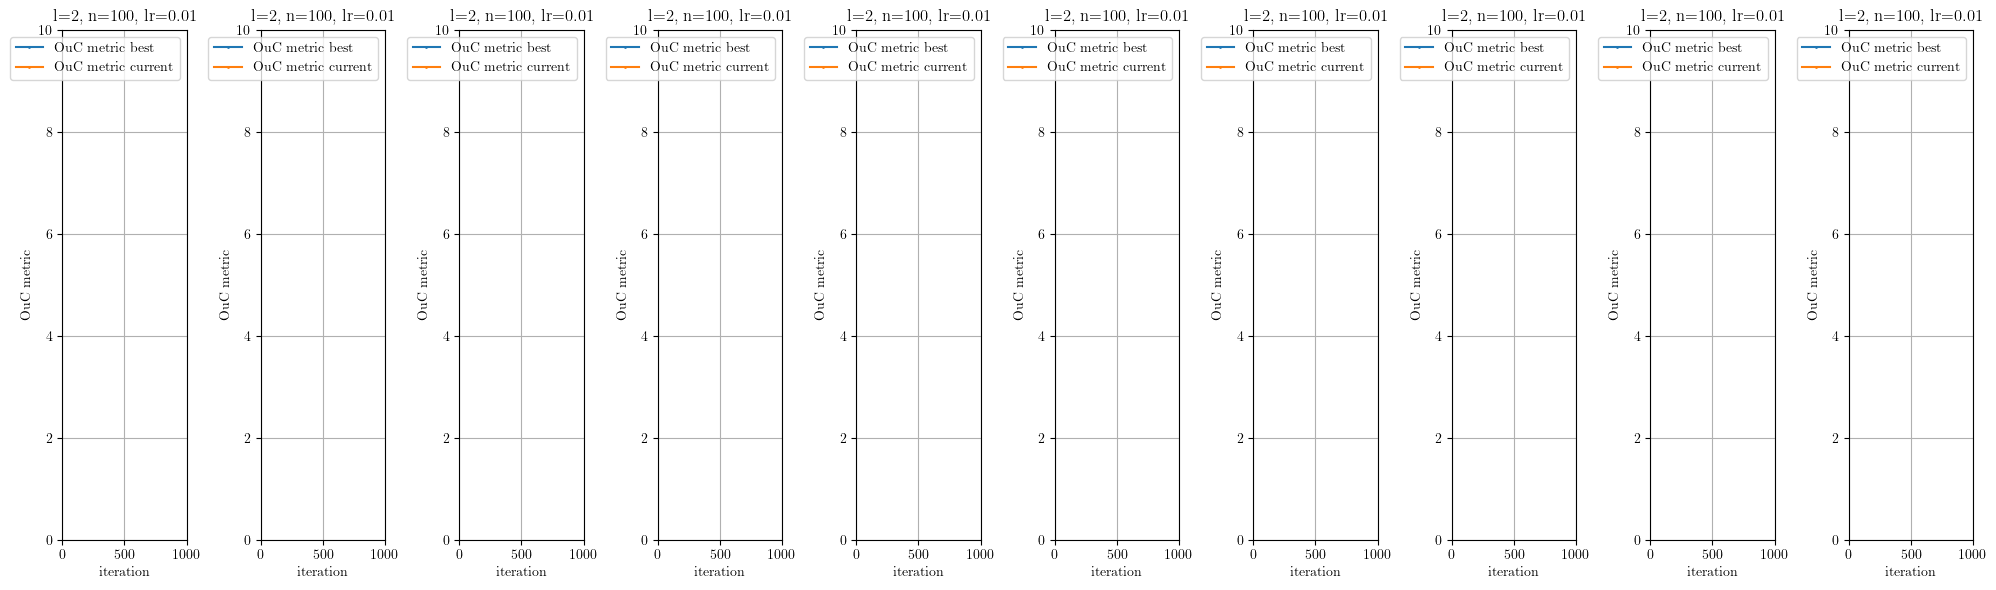

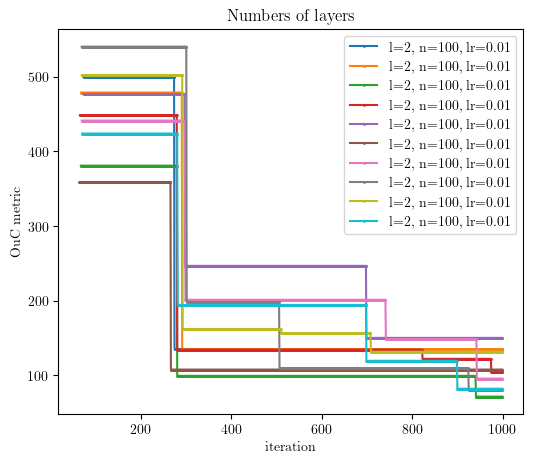

In [30]:
WEIGTHING = 1
CONSTRAINT_WEIGHT = 500.0
res_learning_rate = try_lr([0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01], 2, 100)
ratio_mean = 0
error_mean = 0
for r in res_learning_rate:
    ratio_mean += r['ratio']
    error_mean += r['mse']
ratio_mean /= len(res_learning_rate)
error_mean /= len(res_learning_rate)
hyperparameter_combinations.append({'WEIGHTING': WEIGTHING, 'CONSTRAINT_WEIGHT': CONSTRAINT_WEIGHT, 'ratio_mean': ratio_mean, 'error_mean': error_mean})
plot_results(res_learning_rate, y_max=10)
plot_result_confrontation(res_learning_rate)

/tmp/ipykernel_430497/2445299378.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  penalty_mask = torch.tensor(g_values > epsilon, dtype=torch.float).cuda()
/tmp/ipykernel_430497/2445299378.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  logarithmic_penalty = torch.tensor(penalty_mask * (FIXED_PENALTY + PENALTY_SCALE * torch.log(g_values + 1.0))).cuda()


LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 97.77832 MSE solution: 3.0306419704085994 ratio: 0.177 time: 97.11677479743958
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 56.193947 MSE solution: 1.0237593727154364 ratio: 0.159 time: 101.36527037620544
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 110.7973 MSE solution: 0.30862729168660114 ratio: 0.135 time: 96.71453809738159
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 58.232773 MSE solution: 0.3963875516181314 ratio: 0.123 time: 90.1949520111084
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 53.92364 MSE solution: 2.20371256905729 ratio: 0.177 time: 105.73103594779968
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 56.745613 MSE solution: 3.5092102588926917 ratio: 0.158 time: 97.37818264961243
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 110.45025 MSE solution: 1.3272080162505935 ratio: 0.139 time: 101.8030743598938
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 78.63767 MSE solution: 0.13356620107866155 ratio: 0.277 time: 98.00609731674194
LAYERS: 2 NEURONS: 100 LR: 0.01 eps

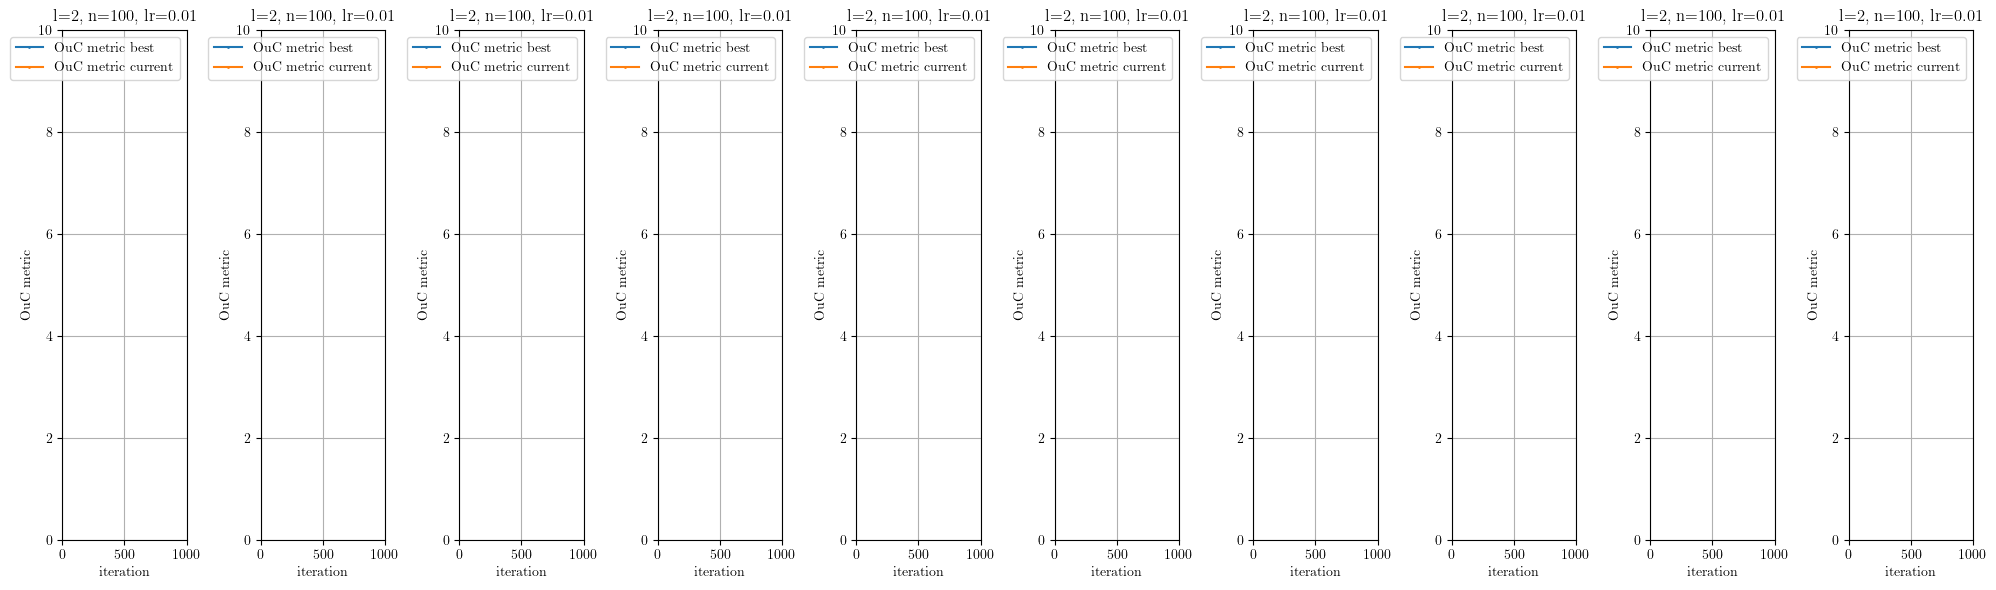

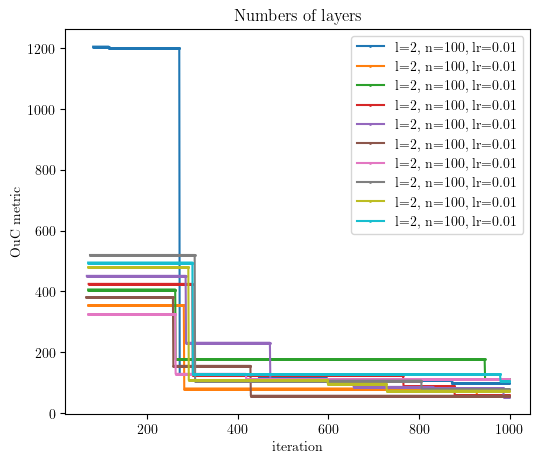

In [31]:
WEIGTHING = 2
CONSTRAINT_WEIGHT = 5.0
res_learning_rate = try_lr([0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01], 2, 100)
ratio_mean = 0
error_mean = 0
for r in res_learning_rate:
    ratio_mean += r['ratio']
    error_mean += r['mse']
ratio_mean /= len(res_learning_rate)
error_mean /= len(res_learning_rate)
hyperparameter_combinations.append({'WEIGHTING': WEIGTHING, 'CONSTRAINT_WEIGHT': CONSTRAINT_WEIGHT, 'ratio_mean': ratio_mean, 'error_mean': error_mean})
plot_results(res_learning_rate, y_max=10)
plot_result_confrontation(res_learning_rate)

/tmp/ipykernel_430497/2445299378.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  penalty_mask = torch.tensor(g_values > epsilon, dtype=torch.float).cuda()
/tmp/ipykernel_430497/2445299378.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  logarithmic_penalty = torch.tensor(penalty_mask * (FIXED_PENALTY + PENALTY_SCALE * torch.log(g_values + 1.0))).cuda()


LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 57.45726 MSE solution: 3.10339992871204 ratio: 0.192 time: 91.71622633934021
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 67.77761 MSE solution: 3.2180730331581624 ratio: 0.124 time: 94.34668803215027
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 117.63971 MSE solution: 0.14794225322264556 ratio: 0.138 time: 99.11748385429382
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 70.561386 MSE solution: 0.4985931985111282 ratio: 0.132 time: 100.61660099029541
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 134.66924 MSE solution: 1.2833810768831262 ratio: 0.143 time: 96.36719346046448
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 87.368095 MSE solution: 2.124384981467518 ratio: 0.077 time: 99.49094295501709
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 116.507195 MSE solution: 1.9430392594280317 ratio: 0.192 time: 94.0115180015564
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 96.478386 MSE solution: 0.7428316287112825 ratio: 0.138 time: 95.9298369884491
LAYERS: 2 NEURONS: 100 LR: 0.01 epsi

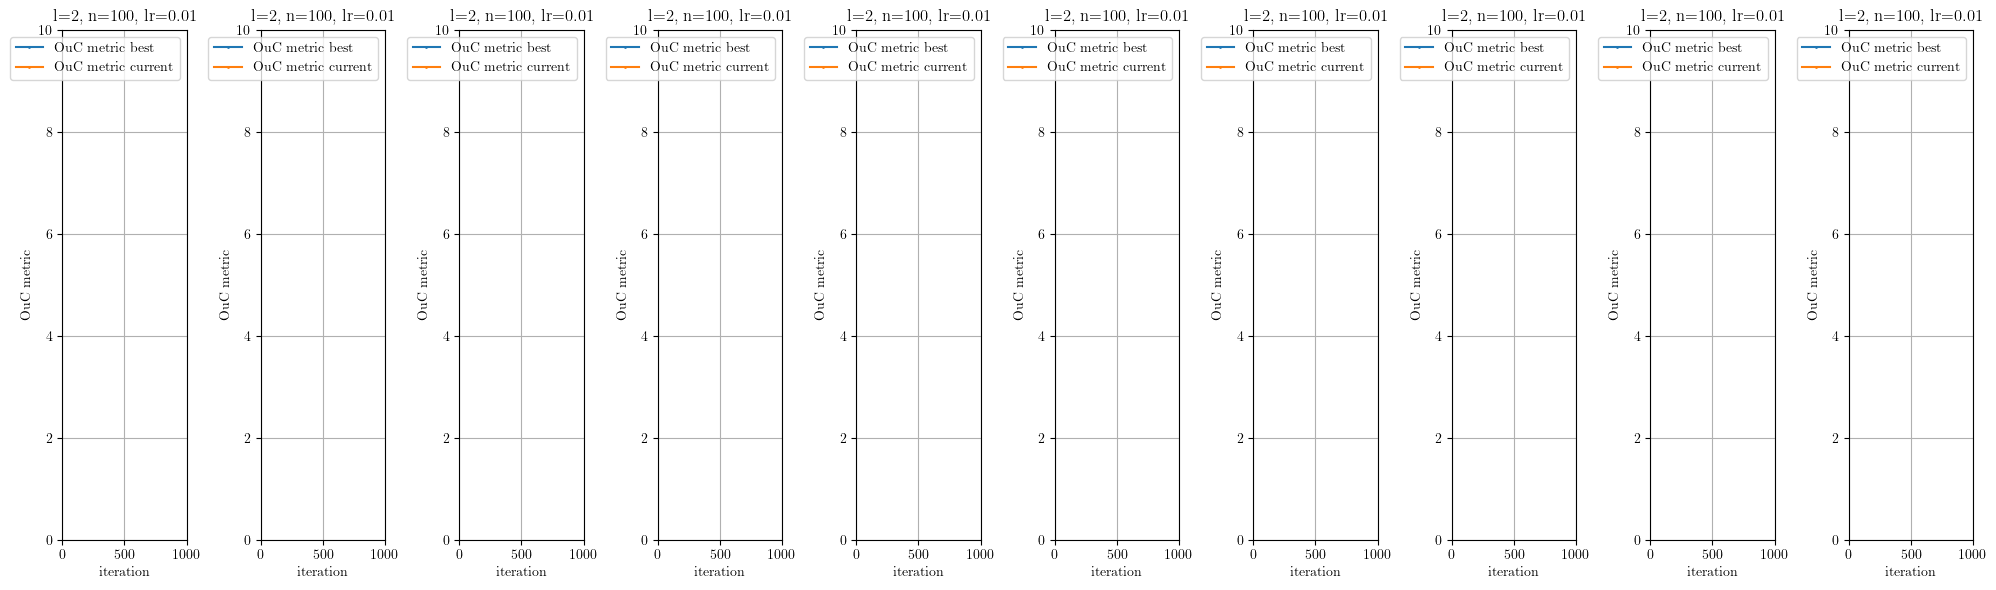

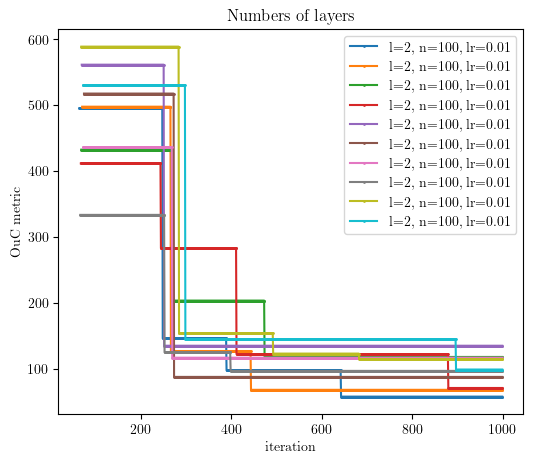

In [32]:
WEIGTHING = 2
CONSTRAINT_WEIGHT = 10.0
res_learning_rate = try_lr([0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01], 2, 100)
ratio_mean = 0
error_mean = 0
for r in res_learning_rate:
    ratio_mean += r['ratio']
    error_mean += r['mse']
ratio_mean /= len(res_learning_rate)
error_mean /= len(res_learning_rate)
hyperparameter_combinations.append({'WEIGHTING': WEIGTHING, 'CONSTRAINT_WEIGHT': CONSTRAINT_WEIGHT, 'ratio_mean': ratio_mean, 'error_mean': error_mean})
plot_results(res_learning_rate, y_max=10)
plot_result_confrontation(res_learning_rate)

/tmp/ipykernel_430497/2445299378.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  penalty_mask = torch.tensor(g_values > epsilon, dtype=torch.float).cuda()
/tmp/ipykernel_430497/2445299378.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  logarithmic_penalty = torch.tensor(penalty_mask * (FIXED_PENALTY + PENALTY_SCALE * torch.log(g_values + 1.0))).cuda()


LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 49.364872 MSE solution: 0.39047667333388597 ratio: 0.217 time: 97.16872000694275
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 117.71011 MSE solution: 0.05198714727870681 ratio: 0.171 time: 98.03127479553223
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 85.32943 MSE solution: 1.5671837709750391 ratio: 0.153 time: 95.69459915161133
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 76.96255 MSE solution: 0.16879785946266157 ratio: 0.115 time: 96.72576928138733
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 110.335976 MSE solution: 0.6102254258245544 ratio: 0.167 time: 95.80787110328674
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 52.320244 MSE solution: 1.4900490795151689 ratio: 0.169 time: 96.36549782752991
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 155.75575 MSE solution: 3.9084854105257487 ratio: 0.164 time: 97.4919753074646
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 58.095108 MSE solution: 1.5079885893952316 ratio: 0.175 time: 98.45733976364136
LAYERS: 2 NEURONS: 100 LR: 0.01

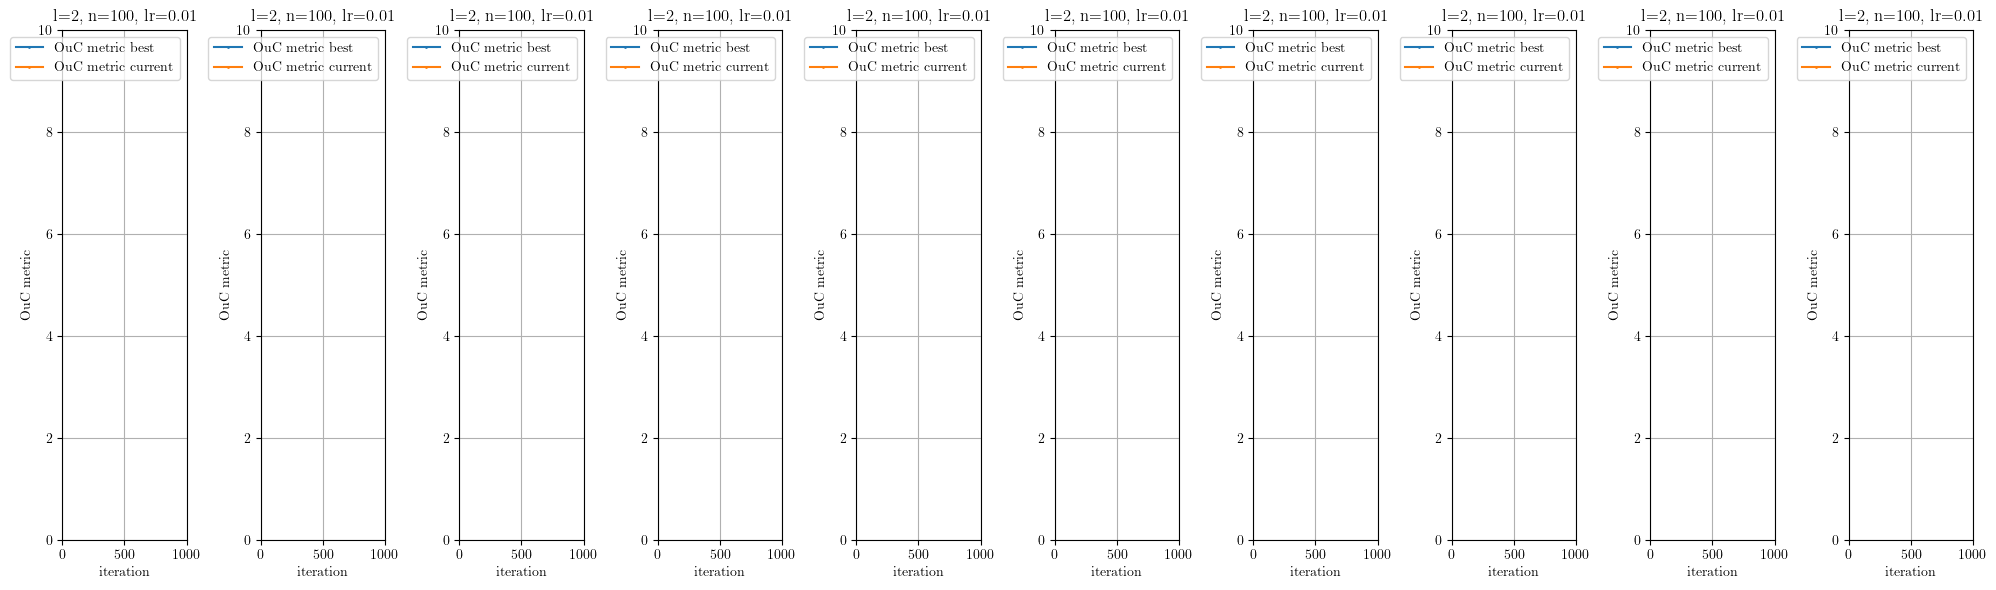

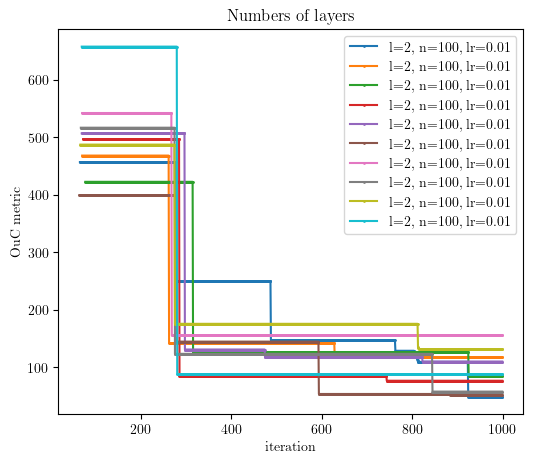

In [33]:
WEIGTHING = 2
CONSTRAINT_WEIGHT = 20.0
res_learning_rate = try_lr([0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01], 2, 100)
ratio_mean = 0
error_mean = 0
for r in res_learning_rate:
    ratio_mean += r['ratio']
    error_mean += r['mse']
ratio_mean /= len(res_learning_rate)
error_mean /= len(res_learning_rate)
hyperparameter_combinations.append({'WEIGHTING': WEIGTHING, 'CONSTRAINT_WEIGHT': CONSTRAINT_WEIGHT, 'ratio_mean': ratio_mean, 'error_mean': error_mean})
plot_results(res_learning_rate, y_max=10)
plot_result_confrontation(res_learning_rate)

/tmp/ipykernel_430497/2445299378.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  penalty_mask = torch.tensor(g_values > epsilon, dtype=torch.float).cuda()
/tmp/ipykernel_430497/2445299378.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  logarithmic_penalty = torch.tensor(penalty_mask * (FIXED_PENALTY + PENALTY_SCALE * torch.log(g_values + 1.0))).cuda()


LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 108.3781 MSE solution: 0.9701889132452294 ratio: 0.167 time: 96.20827555656433
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 121.628815 MSE solution: 3.405119340350739 ratio: 0.179 time: 97.97957730293274
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 107.544014 MSE solution: 4.7224529664403 ratio: 0.146 time: 97.53356766700745
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 119.2855 MSE solution: 1.9392075066570993 ratio: 0.125 time: 95.11148929595947
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 122.48268 MSE solution: 1.4946569677817692 ratio: 0.178 time: 96.86078882217407
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 165.13866 MSE solution: 0.13456496810633883 ratio: 0.128 time: 97.80691027641296
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 109.49052 MSE solution: 1.1023293298662815 ratio: 0.123 time: 95.25826930999756
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 165.27869 MSE solution: 5.142253445166891 ratio: 0.164 time: 95.80744886398315
LAYERS: 2 NEURONS: 100 LR: 0.01 epsi

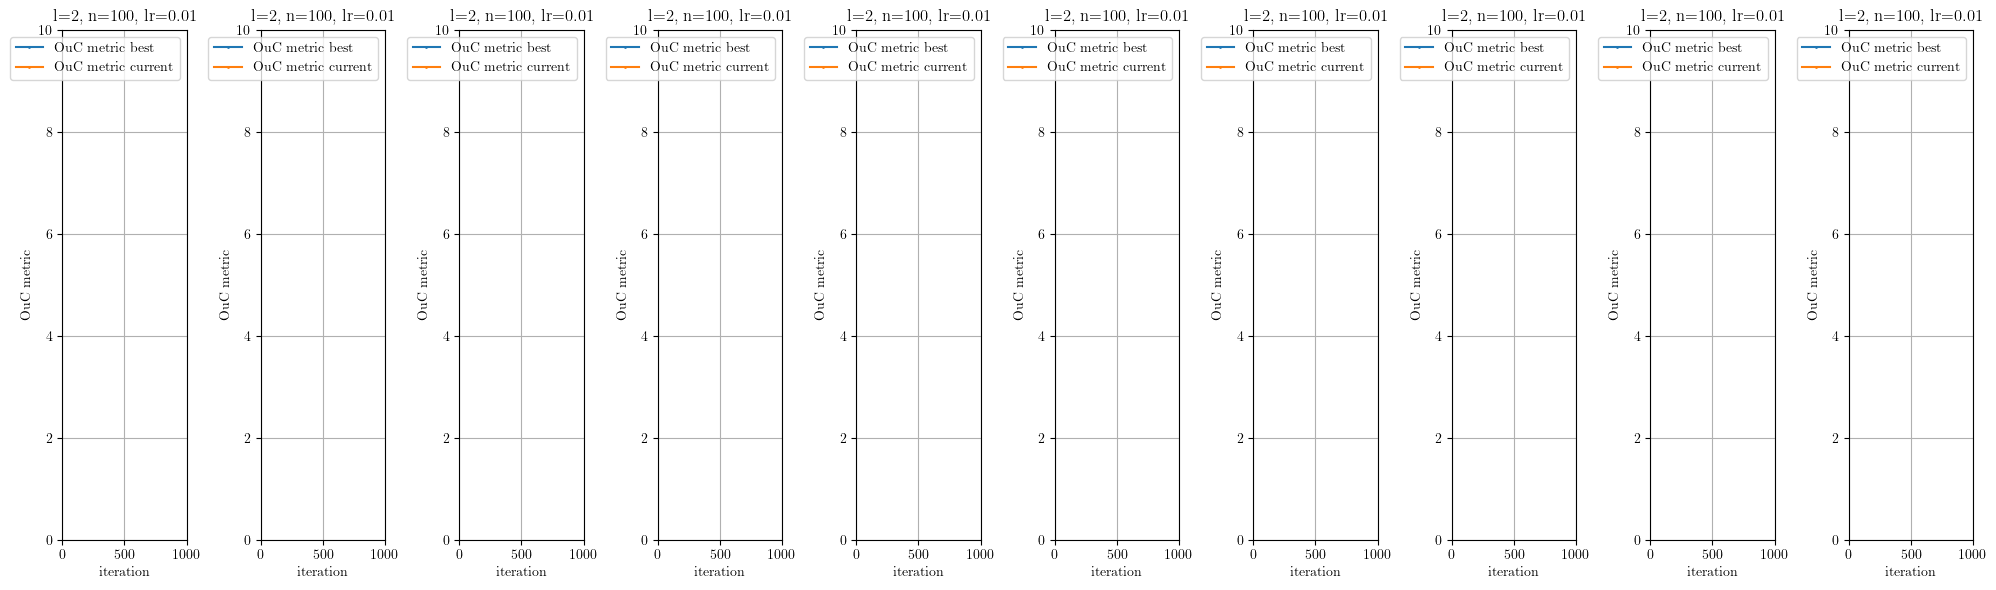

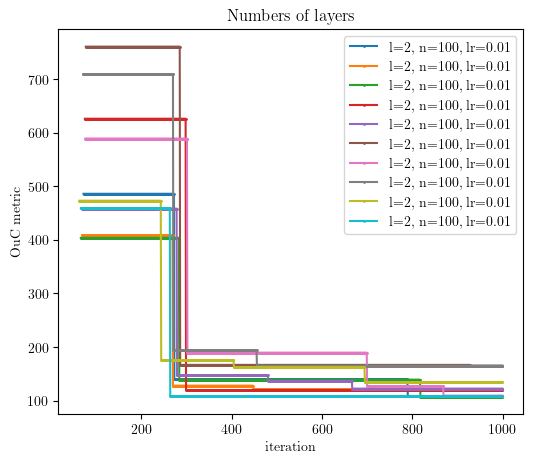

In [34]:
WEIGTHING = 2
CONSTRAINT_WEIGHT = 50.0
res_learning_rate = try_lr([0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01], 2, 100)
ratio_mean = 0
error_mean = 0
for r in res_learning_rate:
    ratio_mean += r['ratio']
    error_mean += r['mse']
ratio_mean /= len(res_learning_rate)
error_mean /= len(res_learning_rate)
hyperparameter_combinations.append({'WEIGHTING': WEIGTHING, 'CONSTRAINT_WEIGHT': CONSTRAINT_WEIGHT, 'ratio_mean': ratio_mean, 'error_mean': error_mean})
plot_results(res_learning_rate, y_max=10)
plot_result_confrontation(res_learning_rate)

/tmp/ipykernel_430497/2445299378.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  penalty_mask = torch.tensor(g_values > epsilon, dtype=torch.float).cuda()
/tmp/ipykernel_430497/2445299378.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  logarithmic_penalty = torch.tensor(penalty_mask * (FIXED_PENALTY + PENALTY_SCALE * torch.log(g_values + 1.0))).cuda()


LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 72.13372 MSE solution: 1.6893522218935135 ratio: 0.132 time: 93.02851581573486
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 68.768974 MSE solution: 0.658707780428955 ratio: 0.131 time: 97.89540791511536
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 116.17449 MSE solution: 1.3306992499335688 ratio: 0.131 time: 88.76101613044739
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 92.15143 MSE solution: 3.4184477588587825 ratio: 0.167 time: 92.52719259262085
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 109.46782 MSE solution: 1.7573969406019392 ratio: 0.176 time: 95.95295596122742
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 129.42142 MSE solution: 0.32006667367356584 ratio: 0.188 time: 96.9043357372284
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 84.77423 MSE solution: 1.0995949684545776 ratio: 0.19 time: 101.18111848831177
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 61.98017 MSE solution: 0.7377322391440989 ratio: 0.125 time: 96.52168488502502
LAYERS: 2 NEURONS: 100 LR: 0.01 epsil

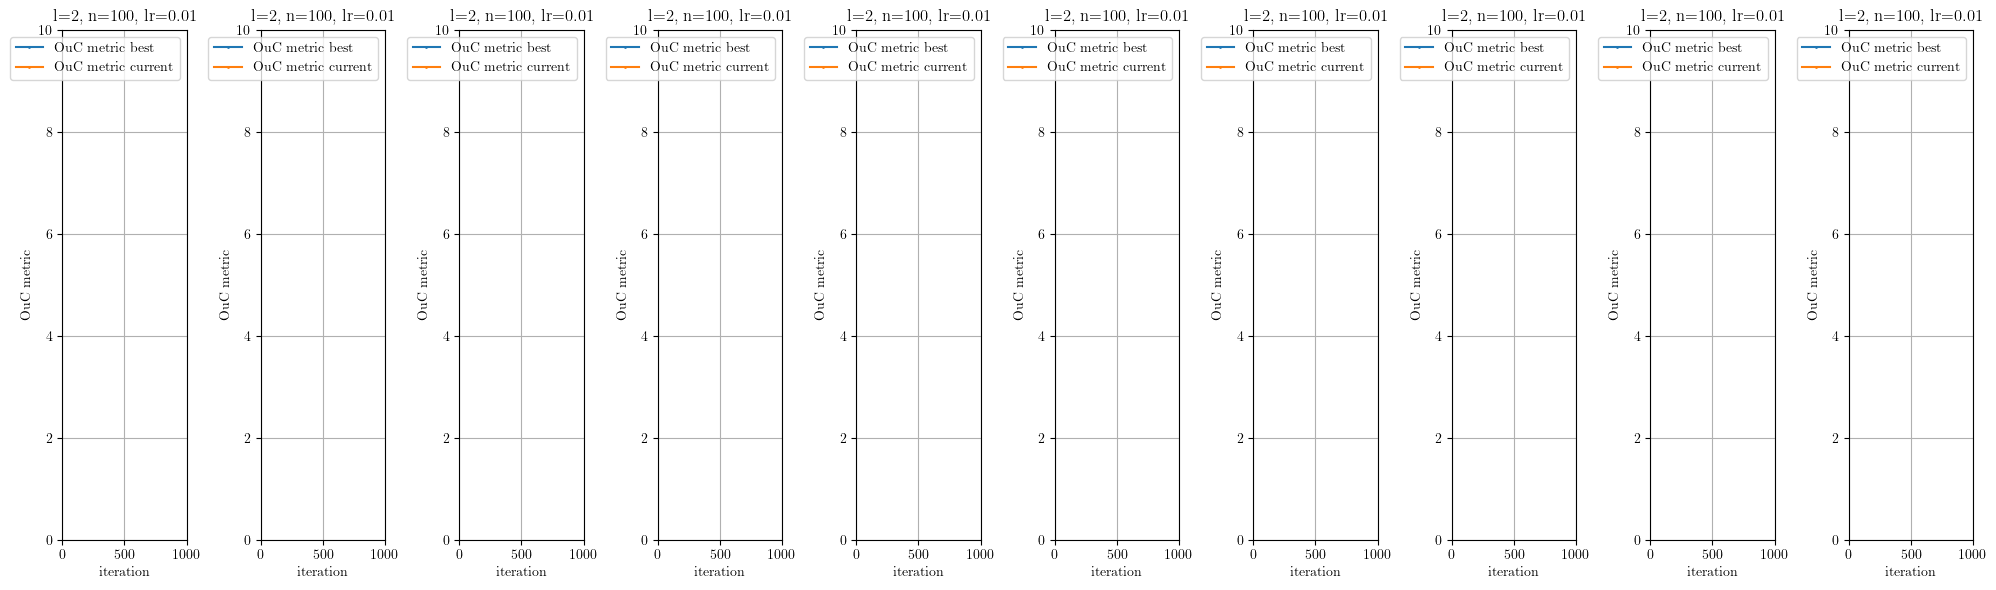

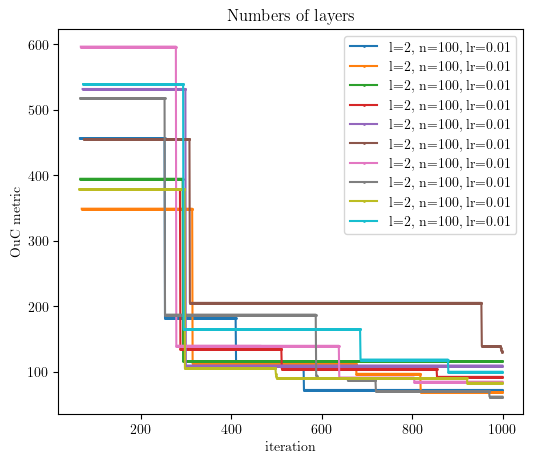

In [35]:
WEIGTHING = 2
CONSTRAINT_WEIGHT = 100.0
res_learning_rate = try_lr([0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01], 2, 100)
ratio_mean = 0
error_mean = 0
for r in res_learning_rate:
    ratio_mean += r['ratio']
    error_mean += r['mse']
ratio_mean /= len(res_learning_rate)
error_mean /= len(res_learning_rate)
hyperparameter_combinations.append({'WEIGHTING': WEIGTHING, 'CONSTRAINT_WEIGHT': CONSTRAINT_WEIGHT, 'ratio_mean': ratio_mean, 'error_mean': error_mean})
plot_results(res_learning_rate, y_max=10)
plot_result_confrontation(res_learning_rate)

/tmp/ipykernel_430497/2445299378.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  penalty_mask = torch.tensor(g_values > epsilon, dtype=torch.float).cuda()
/tmp/ipykernel_430497/2445299378.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  logarithmic_penalty = torch.tensor(penalty_mask * (FIXED_PENALTY + PENALTY_SCALE * torch.log(g_values + 1.0))).cuda()


LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 75.44256 MSE solution: 1.1497454866260886 ratio: 0.206 time: 98.1351568698883
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 89.26568 MSE solution: 0.8673049440543266 ratio: 0.174 time: 95.95344519615173
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 112.5116 MSE solution: 0.45050547049468576 ratio: 0.189 time: 95.0870668888092
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 113.61168 MSE solution: 0.12762277957247262 ratio: 0.214 time: 95.37849760055542
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 70.26905 MSE solution: 1.8925199515799596 ratio: 0.222 time: 96.51716232299805
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 109.13056 MSE solution: 0.5205788371306219 ratio: 0.18 time: 96.14746046066284
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 104.98437 MSE solution: 0.16988634468567973 ratio: 0.162 time: 93.51356148719788
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 81.465965 MSE solution: 0.6137930009405256 ratio: 0.233 time: 97.30739092826843
LAYERS: 2 NEURONS: 100 LR: 0.01 epsi

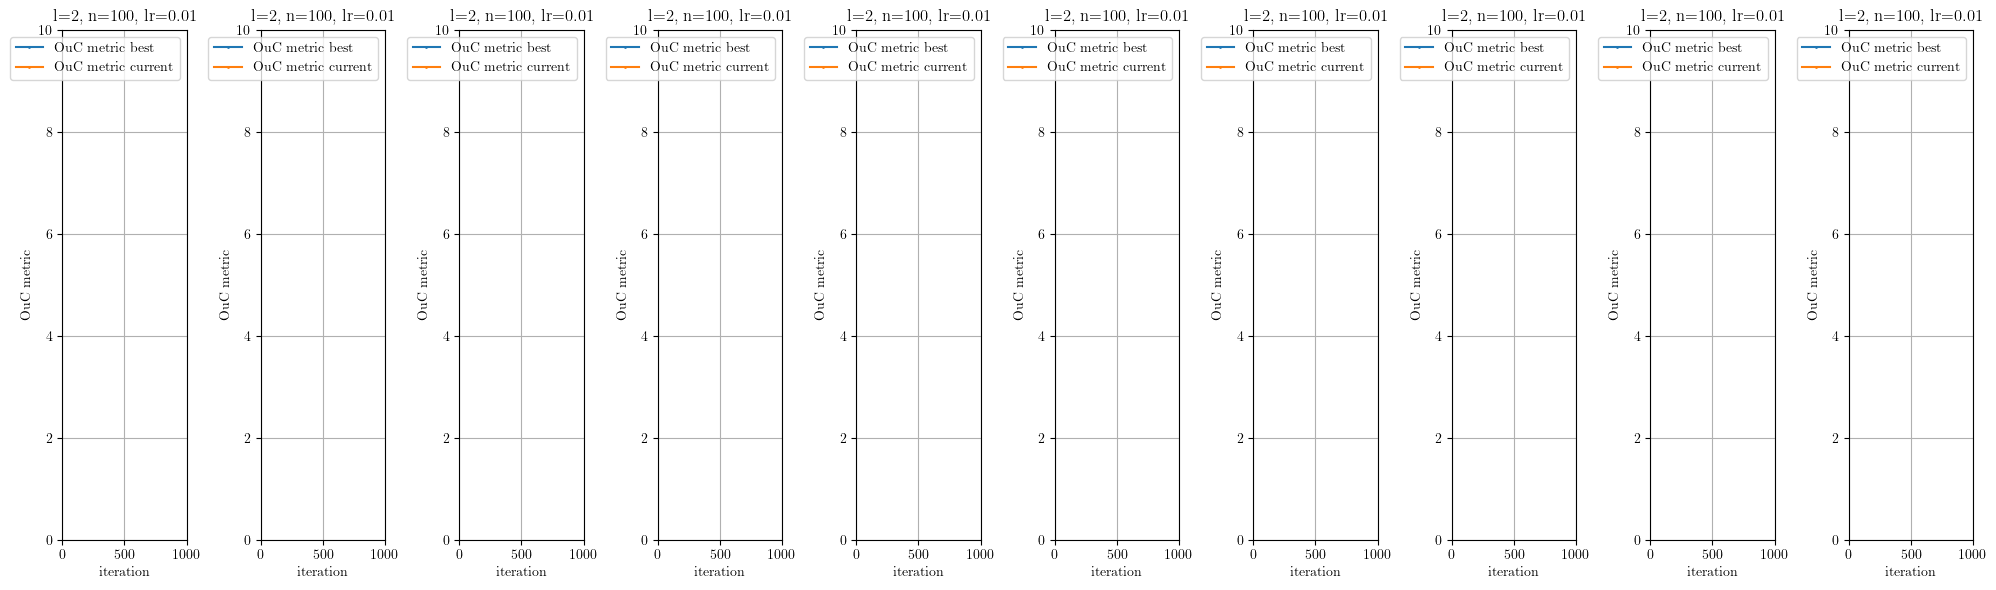

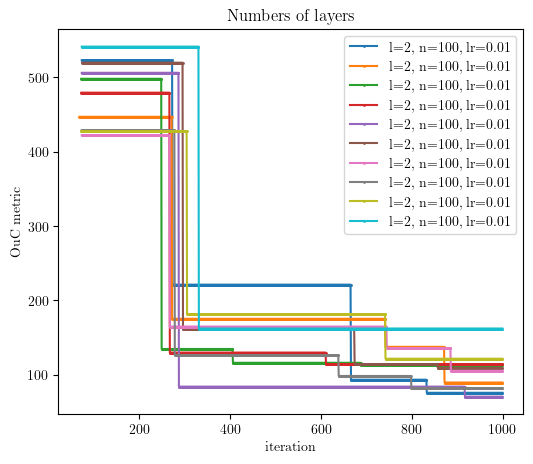

In [36]:
WEIGTHING = 2
CONSTRAINT_WEIGHT = 200.0
res_learning_rate = try_lr([0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01], 2, 100)
ratio_mean = 0
error_mean = 0
for r in res_learning_rate:
    ratio_mean += r['ratio']
    error_mean += r['mse']
ratio_mean /= len(res_learning_rate)
error_mean /= len(res_learning_rate)
hyperparameter_combinations.append({'WEIGHTING': WEIGTHING, 'CONSTRAINT_WEIGHT': CONSTRAINT_WEIGHT, 'ratio_mean': ratio_mean, 'error_mean': error_mean})
plot_results(res_learning_rate, y_max=10)
plot_result_confrontation(res_learning_rate)

/tmp/ipykernel_430497/2445299378.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  penalty_mask = torch.tensor(g_values > epsilon, dtype=torch.float).cuda()
/tmp/ipykernel_430497/2445299378.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  logarithmic_penalty = torch.tensor(penalty_mask * (FIXED_PENALTY + PENALTY_SCALE * torch.log(g_values + 1.0))).cuda()


LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 96.12363 MSE solution: 2.238832407016932 ratio: 0.159 time: 92.39844942092896
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 81.95078 MSE solution: 2.784793921346788 ratio: 0.184 time: 97.85365009307861
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 141.1542 MSE solution: 0.19550022460507469 ratio: 0.207 time: 98.4919764995575
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 100.83322 MSE solution: 8.87522549392011 ratio: 0.215 time: 97.94568228721619
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 75.05381 MSE solution: 1.7518599380238804 ratio: 0.127 time: 100.19457960128784
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 95.85984 MSE solution: 1.3850993025077942 ratio: 0.152 time: 99.46241736412048
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 62.178543 MSE solution: 0.3599443829436028 ratio: 0.153 time: 101.07465028762817
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 53.45793 MSE solution: 0.4381755560948551 ratio: 0.155 time: 97.70250487327576
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon:

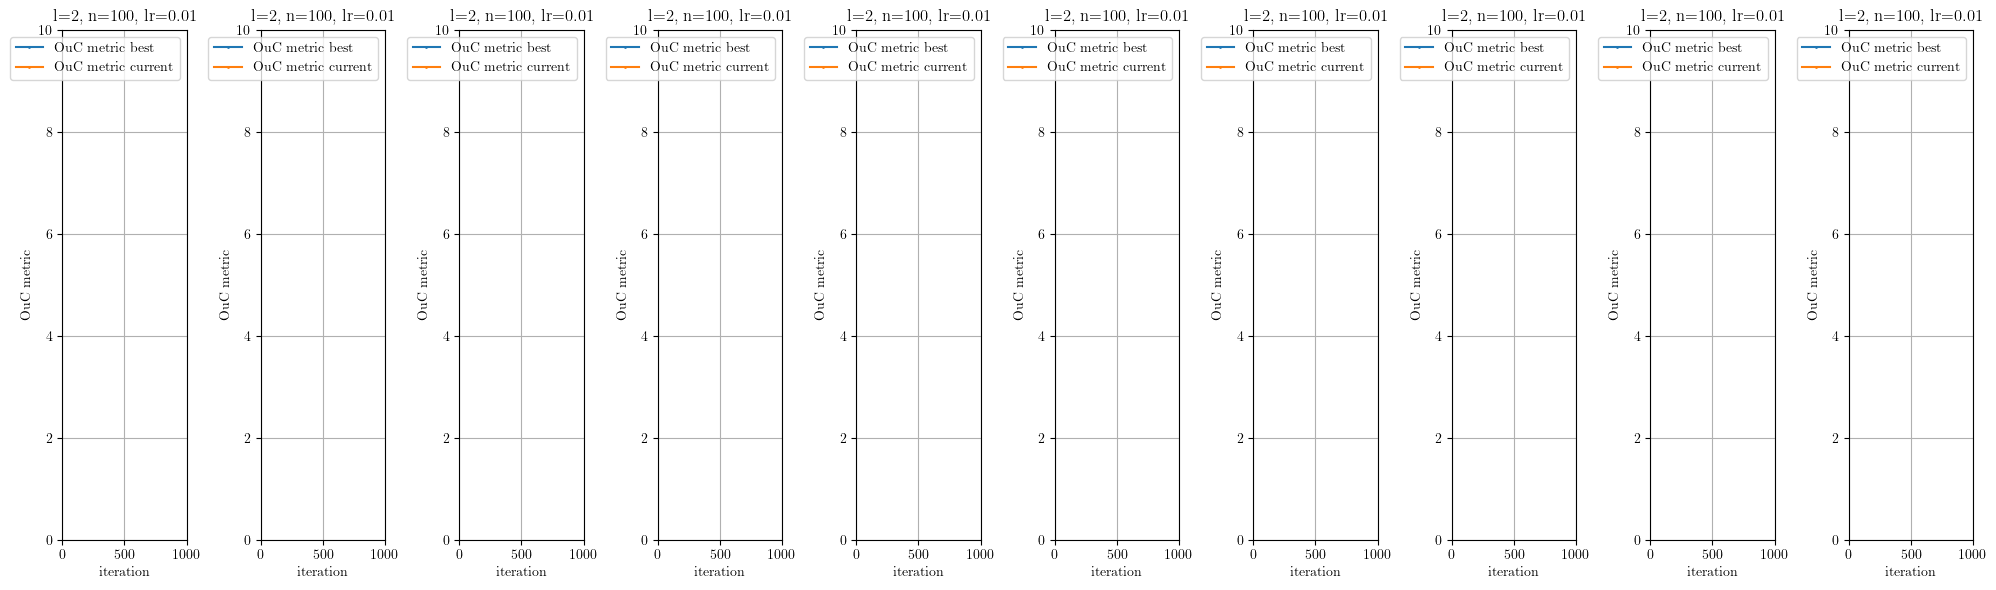

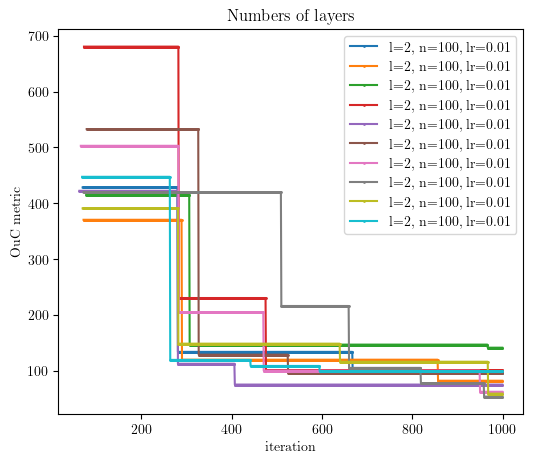

In [37]:
WEIGTHING = 2
CONSTRAINT_WEIGHT = 500.0
res_learning_rate = try_lr([0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01], 2, 100)
ratio_mean = 0
error_mean = 0
for r in res_learning_rate:
    ratio_mean += r['ratio']
    error_mean += r['mse']
ratio_mean /= len(res_learning_rate)
error_mean /= len(res_learning_rate)
hyperparameter_combinations.append({'WEIGHTING': WEIGTHING, 'CONSTRAINT_WEIGHT': CONSTRAINT_WEIGHT, 'ratio_mean': ratio_mean, 'error_mean': error_mean})
plot_results(res_learning_rate, y_max=10)
plot_result_confrontation(res_learning_rate)

/tmp/ipykernel_430497/2445299378.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  penalty_mask = torch.tensor(g_values > epsilon, dtype=torch.float).cuda()
/tmp/ipykernel_430497/2445299378.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  logarithmic_penalty = torch.tensor(penalty_mask * (FIXED_PENALTY + PENALTY_SCALE * torch.log(g_values + 1.0))).cuda()


LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 86.68924 MSE solution: 4.880738453652939 ratio: 0.163 time: 100.33697056770325
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 119.382195 MSE solution: 1.3216671591529843 ratio: 0.158 time: 98.92666840553284
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 85.53778 MSE solution: 1.6102923321467195 ratio: 0.124 time: 98.62649726867676
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 123.909874 MSE solution: 4.2943862159864175 ratio: 0.143 time: 95.09070444107056
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 102.33501 MSE solution: 2.916150577362492 ratio: 0.198 time: 94.71939182281494
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 49.57022 MSE solution: 2.1570052539806834 ratio: 0.156 time: 98.70654439926147
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 77.28544 MSE solution: 2.923195048808722 ratio: 0.122 time: 98.18593668937683
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 52.546467 MSE solution: 0.9595499463032634 ratio: 0.148 time: 97.32951331138611
LAYERS: 2 NEURONS: 100 LR: 0.01 epsi

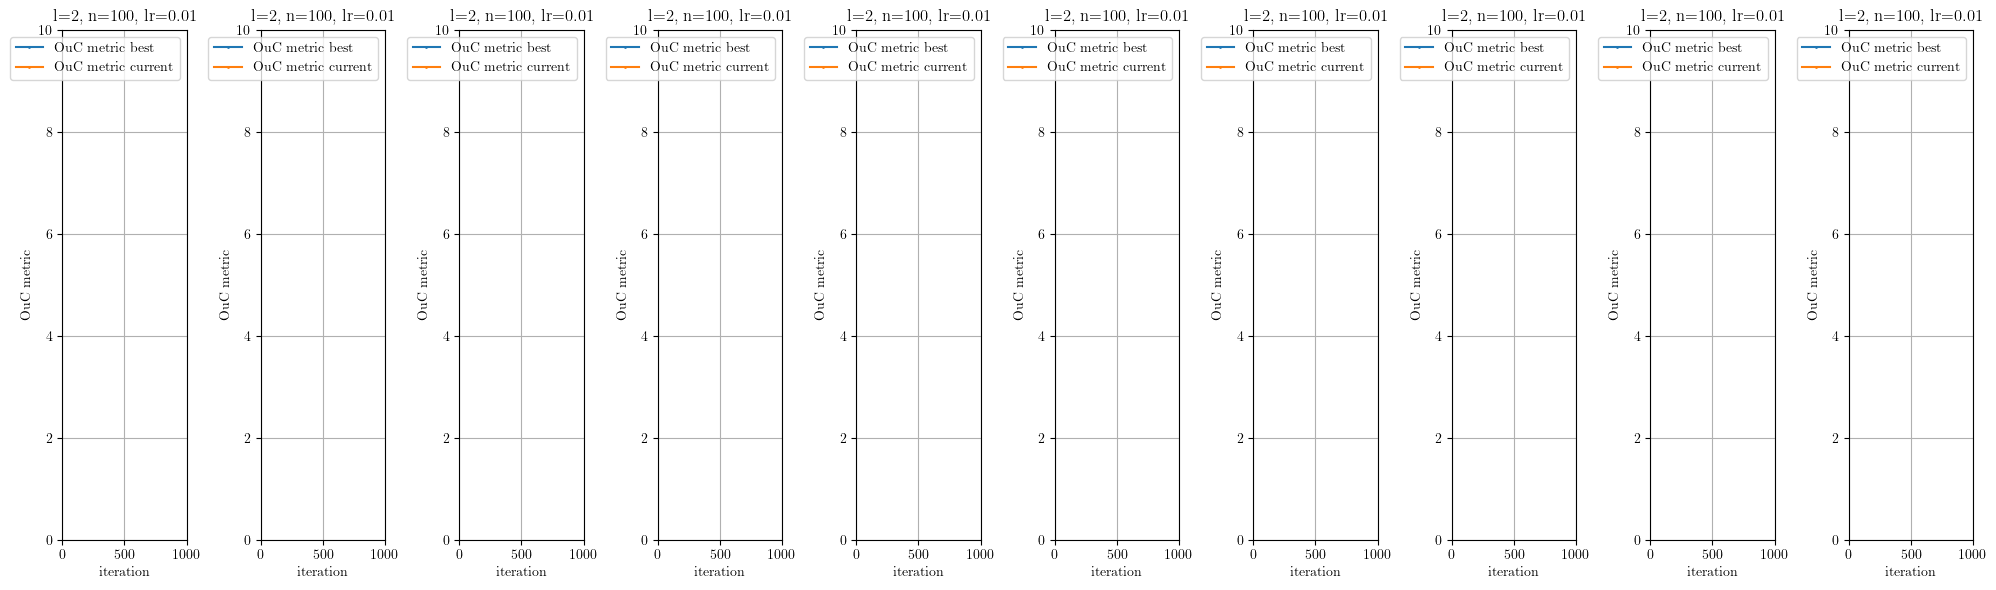

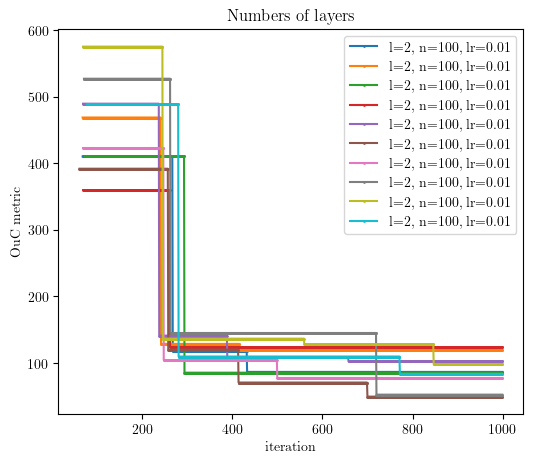

In [38]:
WEIGTHING = 4
CONSTRAINT_WEIGHT = 5.0
res_learning_rate = try_lr([0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01], 2, 100)
ratio_mean = 0
error_mean = 0
for r in res_learning_rate:
    ratio_mean += r['ratio']
    error_mean += r['mse']
ratio_mean /= len(res_learning_rate)
error_mean /= len(res_learning_rate)
hyperparameter_combinations.append({'WEIGHTING': WEIGTHING, 'CONSTRAINT_WEIGHT': CONSTRAINT_WEIGHT, 'ratio_mean': ratio_mean, 'error_mean': error_mean})
plot_results(res_learning_rate, y_max=10)
plot_result_confrontation(res_learning_rate)

/tmp/ipykernel_430497/2445299378.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  penalty_mask = torch.tensor(g_values > epsilon, dtype=torch.float).cuda()
/tmp/ipykernel_430497/2445299378.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  logarithmic_penalty = torch.tensor(penalty_mask * (FIXED_PENALTY + PENALTY_SCALE * torch.log(g_values + 1.0))).cuda()


LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 111.24974 MSE solution: 0.6769632133368311 ratio: 0.153 time: 96.6993408203125
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 110.859764 MSE solution: 1.201087554600863 ratio: 0.137 time: 97.952876329422
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 95.265 MSE solution: 5.180790076902508 ratio: 0.189 time: 99.10063815116882
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 95.9747 MSE solution: 5.578105282456479 ratio: 0.169 time: 94.45631289482117
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 101.39327 MSE solution: 0.7030884407397698 ratio: 0.139 time: 96.73537111282349
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 70.225716 MSE solution: 1.3103150162488177 ratio: 0.114 time: 97.27998328208923
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 45.358597 MSE solution: 1.3622542920209193 ratio: 0.233 time: 94.99442863464355
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 118.97398 MSE solution: 0.7738461683841841 ratio: 0.177 time: 98.11282086372375
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 6

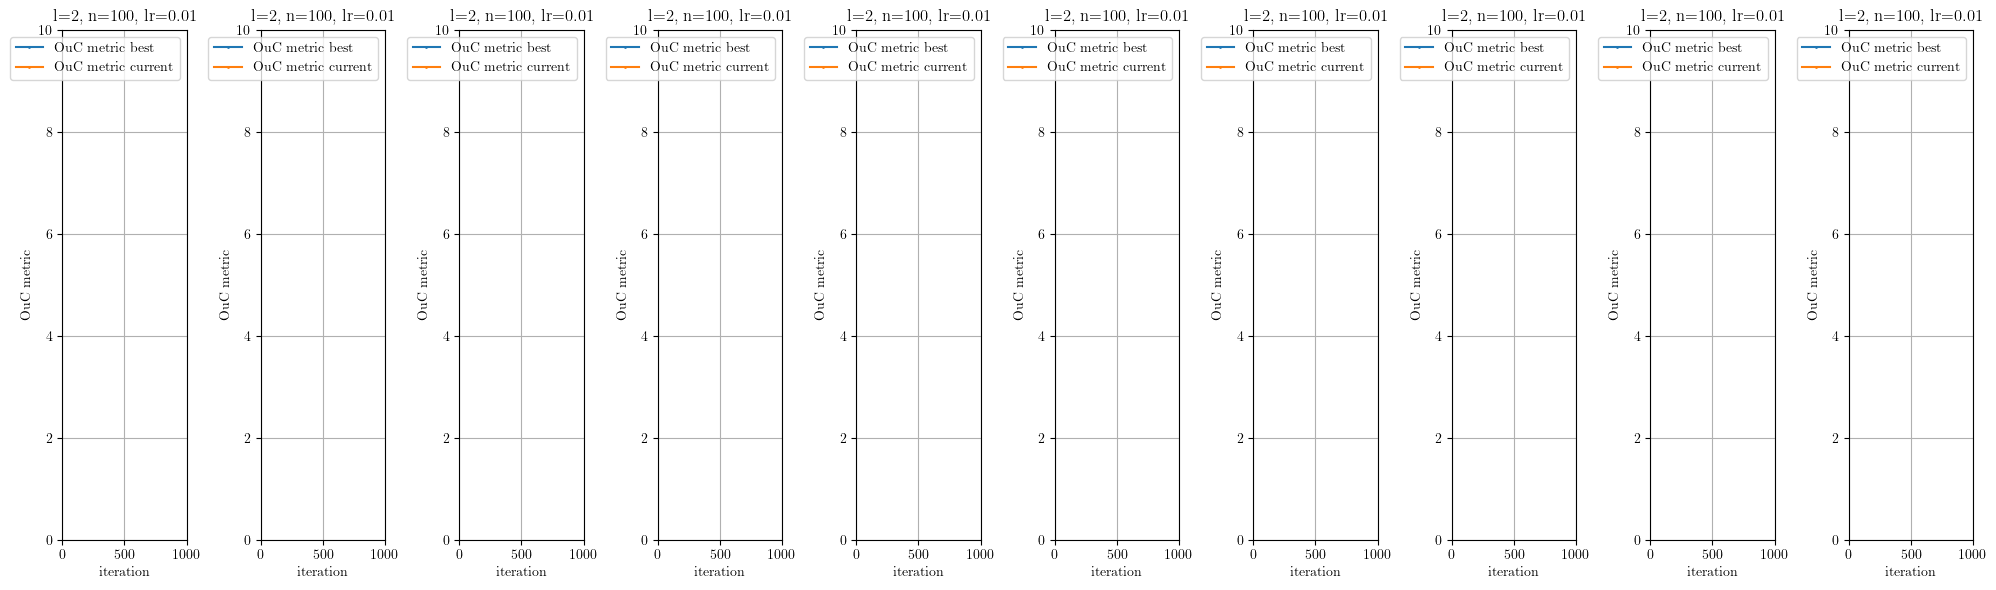

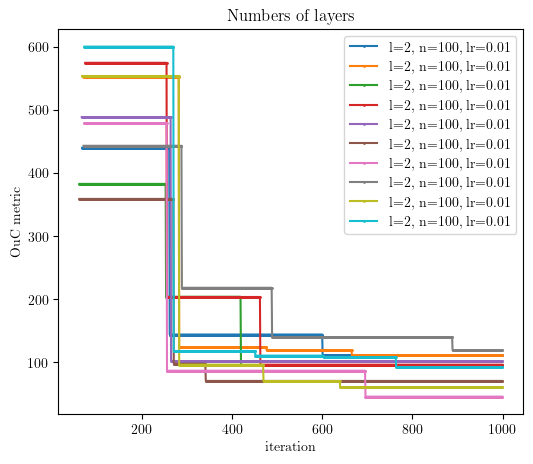

In [39]:
WEIGTHING = 4
CONSTRAINT_WEIGHT = 10.0
res_learning_rate = try_lr([0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01], 2, 100)
ratio_mean = 0
error_mean = 0
for r in res_learning_rate:
    ratio_mean += r['ratio']
    error_mean += r['mse']
ratio_mean /= len(res_learning_rate)
error_mean /= len(res_learning_rate)
hyperparameter_combinations.append({'WEIGHTING': WEIGTHING, 'CONSTRAINT_WEIGHT': CONSTRAINT_WEIGHT, 'ratio_mean': ratio_mean, 'error_mean': error_mean})
plot_results(res_learning_rate, y_max=10)
plot_result_confrontation(res_learning_rate)

/tmp/ipykernel_430497/2445299378.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  penalty_mask = torch.tensor(g_values > epsilon, dtype=torch.float).cuda()
/tmp/ipykernel_430497/2445299378.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  logarithmic_penalty = torch.tensor(penalty_mask * (FIXED_PENALTY + PENALTY_SCALE * torch.log(g_values + 1.0))).cuda()


LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 47.09969 MSE solution: 2.538673087899884 ratio: 0.175 time: 99.07677745819092
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 94.68861 MSE solution: 2.5372910806964715 ratio: 0.171 time: 92.9309458732605
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 112.18092 MSE solution: 0.5985040213349301 ratio: 0.107 time: 90.957599401474
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 78.79602 MSE solution: 0.5267430517741357 ratio: 0.196 time: 97.39498043060303
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 93.9232 MSE solution: 0.7240451962644259 ratio: 0.16 time: 94.64387464523315
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 69.705086 MSE solution: 0.1367876063960273 ratio: 0.144 time: 96.64716625213623
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 94.23472 MSE solution: 1.9495107960223912 ratio: 0.16 time: 97.06013011932373
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 82.673386 MSE solution: 1.5198379938488322 ratio: 0.244 time: 91.24430203437805
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 90.

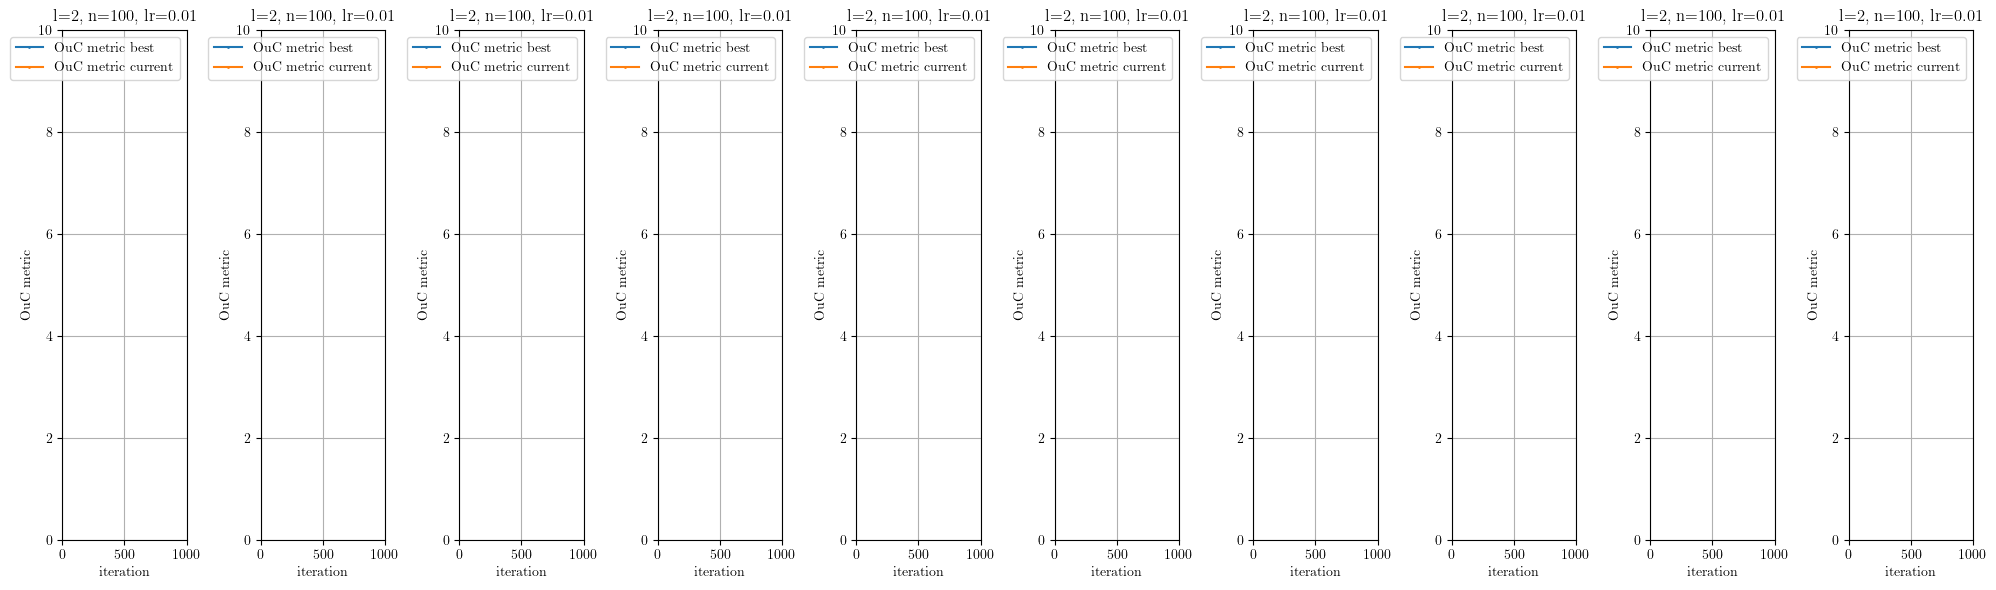

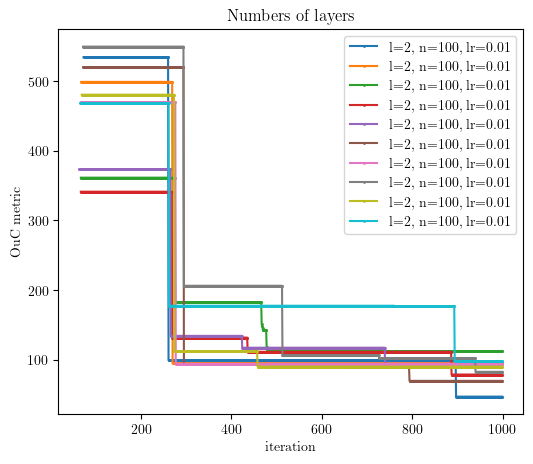

In [40]:
WEIGTHING = 4
CONSTRAINT_WEIGHT = 20.0
res_learning_rate = try_lr([0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01], 2, 100)
ratio_mean = 0
error_mean = 0
for r in res_learning_rate:
    ratio_mean += r['ratio']
    error_mean += r['mse']
ratio_mean /= len(res_learning_rate)
error_mean /= len(res_learning_rate)
hyperparameter_combinations.append({'WEIGHTING': WEIGTHING, 'CONSTRAINT_WEIGHT': CONSTRAINT_WEIGHT, 'ratio_mean': ratio_mean, 'error_mean': error_mean})
plot_results(res_learning_rate, y_max=10)
plot_result_confrontation(res_learning_rate)

/tmp/ipykernel_430497/2445299378.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  penalty_mask = torch.tensor(g_values > epsilon, dtype=torch.float).cuda()
/tmp/ipykernel_430497/2445299378.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  logarithmic_penalty = torch.tensor(penalty_mask * (FIXED_PENALTY + PENALTY_SCALE * torch.log(g_values + 1.0))).cuda()


LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 72.41179 MSE solution: 1.1144235613965197 ratio: 0.177 time: 96.08314204216003
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 118.67159 MSE solution: 0.6869253159677258 ratio: 0.132 time: 91.91486644744873
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 76.44204 MSE solution: 2.0723501544739364 ratio: 0.151 time: 94.90190076828003
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 100.245804 MSE solution: 3.11332663324532 ratio: 0.187 time: 95.75474333763123
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 39.951797 MSE solution: 1.043782880444031 ratio: 0.17 time: 96.33764815330505
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 118.60237 MSE solution: 0.6991123309512955 ratio: 0.162 time: 96.5095272064209
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 83.77856 MSE solution: 1.3923365854255856 ratio: 0.179 time: 93.35838150978088
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 80.392006 MSE solution: 0.08918733654163517 ratio: 0.104 time: 92.52823567390442
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilo

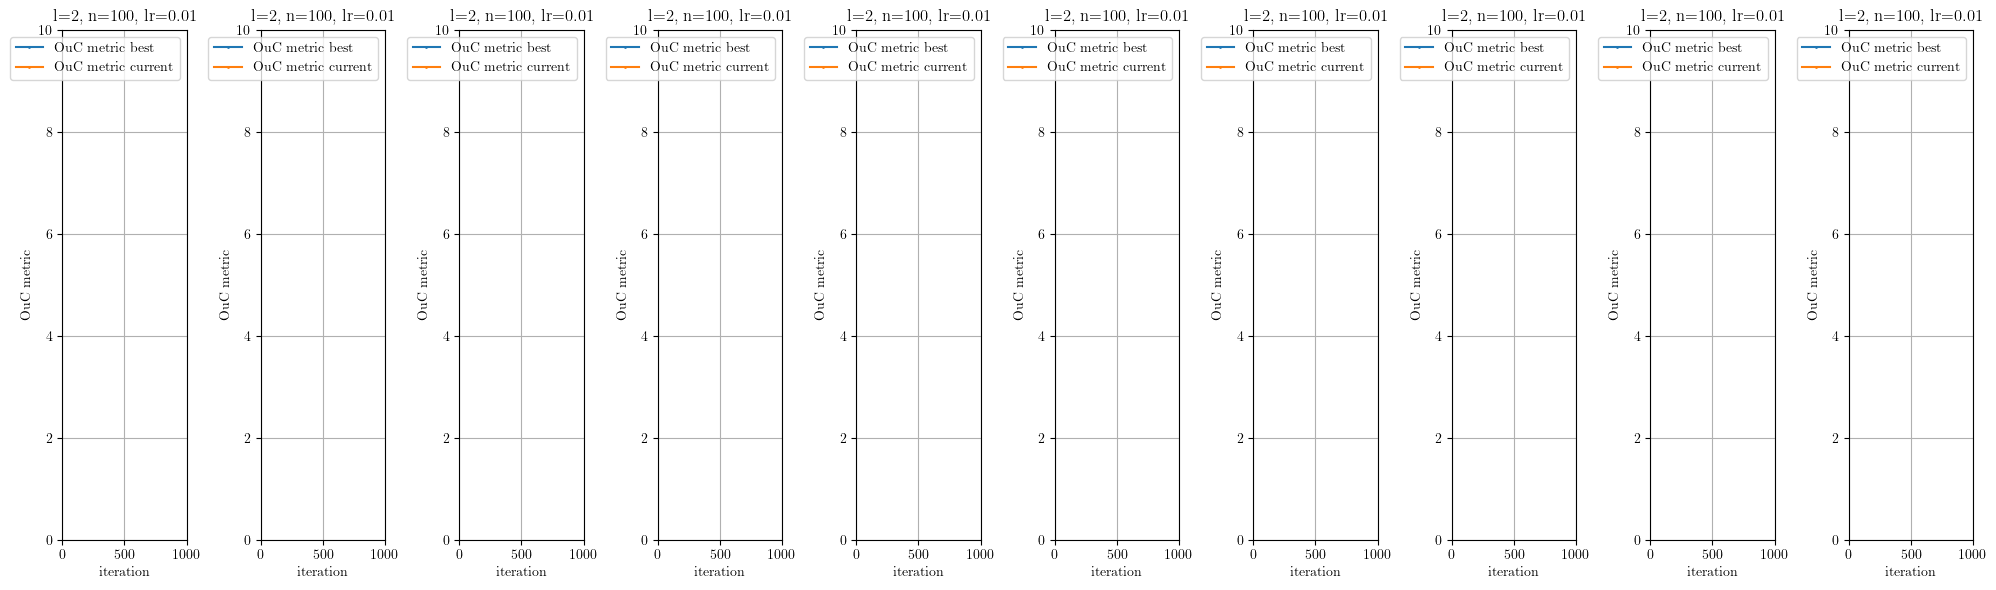

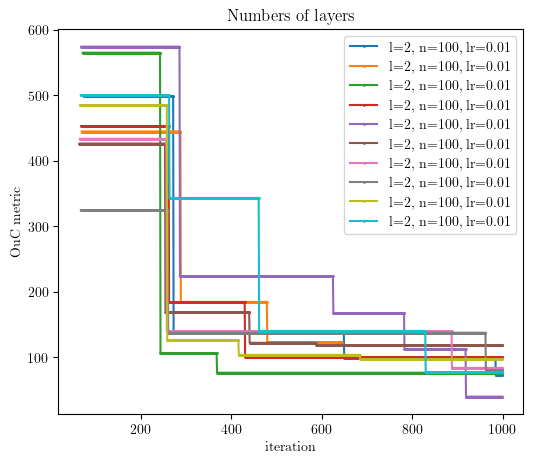

In [41]:
WEIGTHING = 4
CONSTRAINT_WEIGHT = 50.0
res_learning_rate = try_lr([0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01], 2, 100)
ratio_mean = 0
error_mean = 0
for r in res_learning_rate:
    ratio_mean += r['ratio']
    error_mean += r['mse']
ratio_mean /= len(res_learning_rate)
error_mean /= len(res_learning_rate)
hyperparameter_combinations.append({'WEIGHTING': WEIGTHING, 'CONSTRAINT_WEIGHT': CONSTRAINT_WEIGHT, 'ratio_mean': ratio_mean, 'error_mean': error_mean})
plot_results(res_learning_rate, y_max=10)
plot_result_confrontation(res_learning_rate)

/tmp/ipykernel_430497/2445299378.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  penalty_mask = torch.tensor(g_values > epsilon, dtype=torch.float).cuda()
/tmp/ipykernel_430497/2445299378.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  logarithmic_penalty = torch.tensor(penalty_mask * (FIXED_PENALTY + PENALTY_SCALE * torch.log(g_values + 1.0))).cuda()


LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 133.38376 MSE solution: 2.58436353085653 ratio: 0.19 time: 93.09067463874817
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 49.729702 MSE solution: 0.928286110912181 ratio: 0.172 time: 97.6916229724884
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 97.40118 MSE solution: 0.18816586436800894 ratio: 0.169 time: 96.22147703170776
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 89.30814 MSE solution: 4.444470856542057 ratio: 0.16 time: 96.15064096450806
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 83.25497 MSE solution: 2.0437732748365867 ratio: 0.14 time: 99.41025233268738
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 101.2259 MSE solution: 2.9169276619045594 ratio: 0.17 time: 95.6340537071228
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 82.589455 MSE solution: 0.9044818600395197 ratio: 0.158 time: 93.1326367855072
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 63.55157 MSE solution: 1.5706378335234084 ratio: 0.15 time: 95.58537745475769
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 61.6641

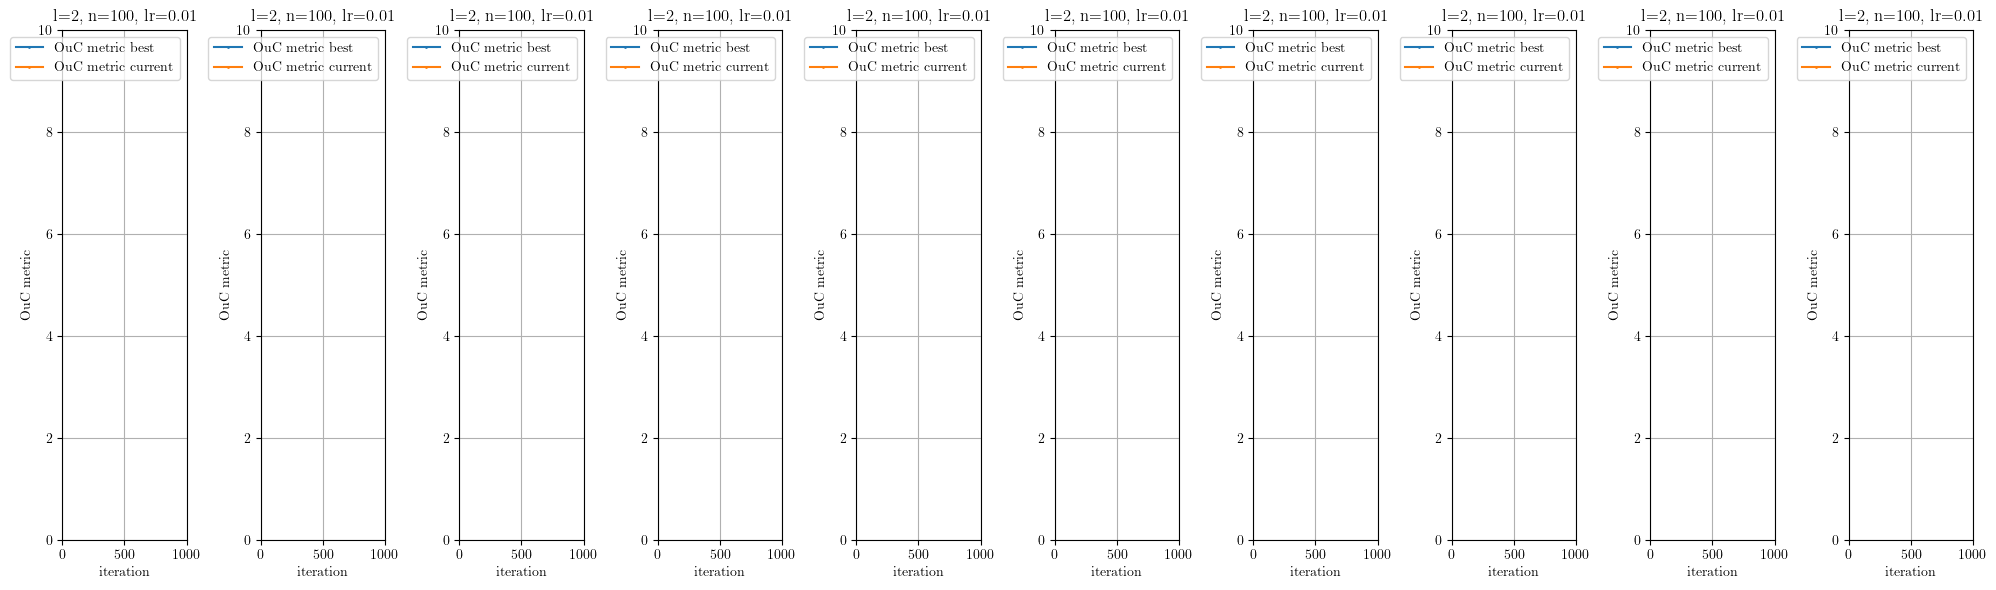

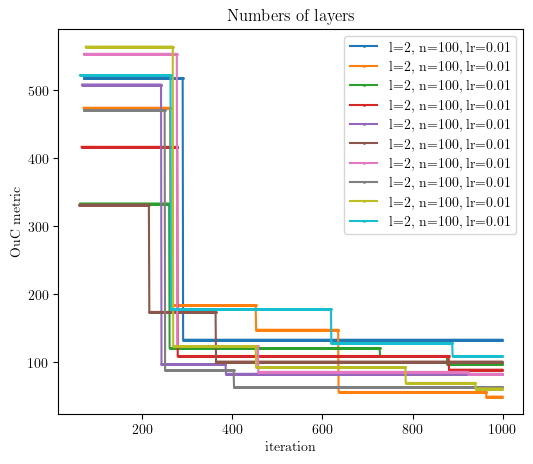

In [42]:
WEIGTHING = 4
CONSTRAINT_WEIGHT = 100.0
res_learning_rate = try_lr([0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01], 2, 100)
ratio_mean = 0
error_mean = 0
for r in res_learning_rate:
    ratio_mean += r['ratio']
    error_mean += r['mse']
ratio_mean /= len(res_learning_rate)
error_mean /= len(res_learning_rate)
hyperparameter_combinations.append({'WEIGHTING': WEIGTHING, 'CONSTRAINT_WEIGHT': CONSTRAINT_WEIGHT, 'ratio_mean': ratio_mean, 'error_mean': error_mean})
plot_results(res_learning_rate, y_max=10)
plot_result_confrontation(res_learning_rate)

/tmp/ipykernel_430497/2445299378.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  penalty_mask = torch.tensor(g_values > epsilon, dtype=torch.float).cuda()
/tmp/ipykernel_430497/2445299378.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  logarithmic_penalty = torch.tensor(penalty_mask * (FIXED_PENALTY + PENALTY_SCALE * torch.log(g_values + 1.0))).cuda()


LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 109.40209 MSE solution: 0.7892227462032717 ratio: 0.192 time: 107.39906811714172
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 84.41824 MSE solution: 2.3558633118804293 ratio: 0.151 time: 97.57878136634827
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 98.44702 MSE solution: 4.61753957346481 ratio: 0.154 time: 99.42138862609863
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 121.82088 MSE solution: 1.2289381536118291 ratio: 0.158 time: 99.70690059661865
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 86.74475 MSE solution: 0.9654863656588403 ratio: 0.124 time: 100.66158151626587
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 87.955765 MSE solution: 1.1569610181973002 ratio: 0.11 time: 96.17380690574646
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 93.197365 MSE solution: 3.0655167481497583 ratio: 0.175 time: 101.66649508476257
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 60.86423 MSE solution: 2.069601730273097 ratio: 0.189 time: 98.30849385261536
LAYERS: 2 NEURONS: 100 LR: 0.01 epsil

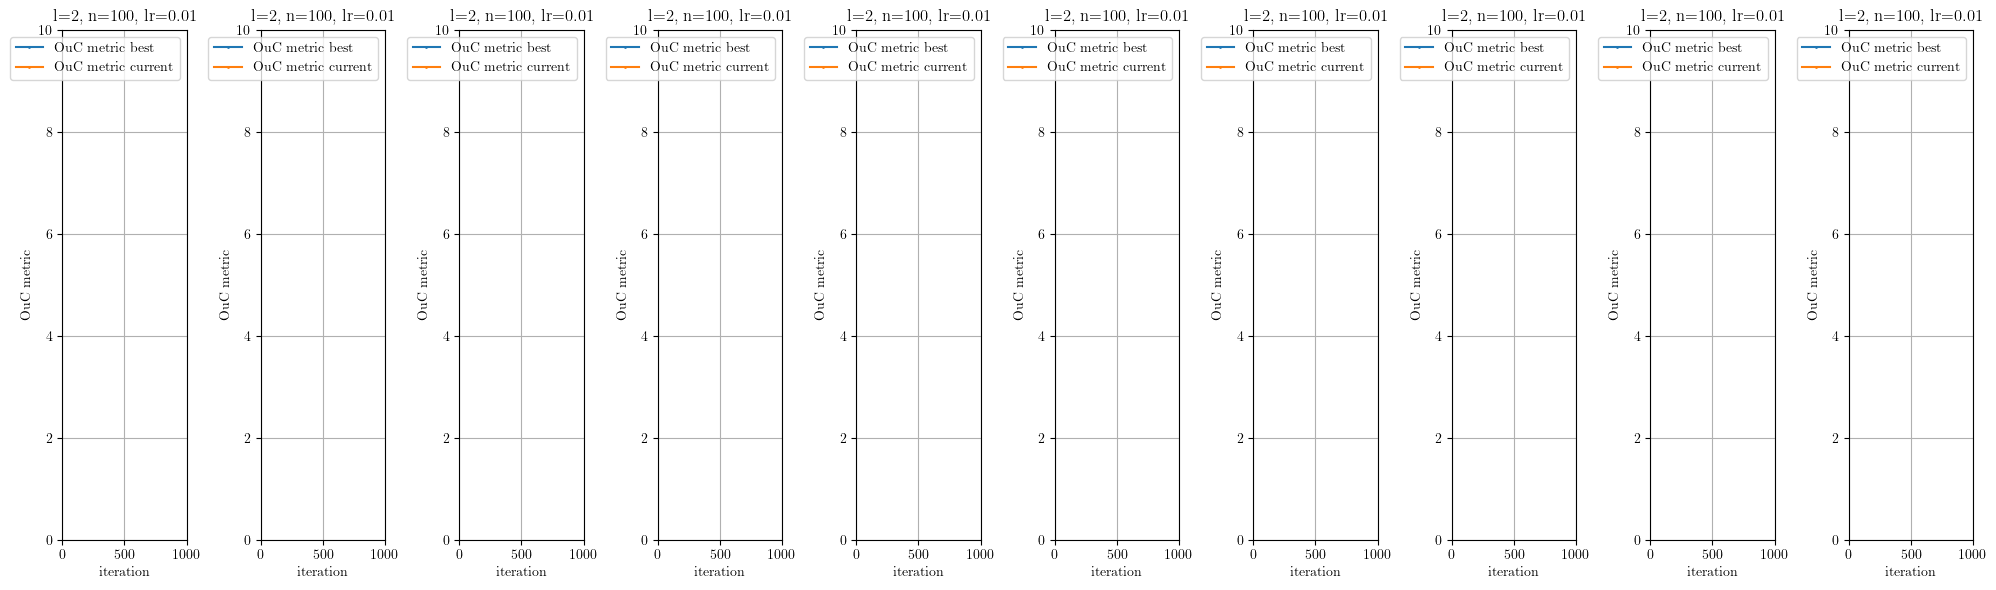

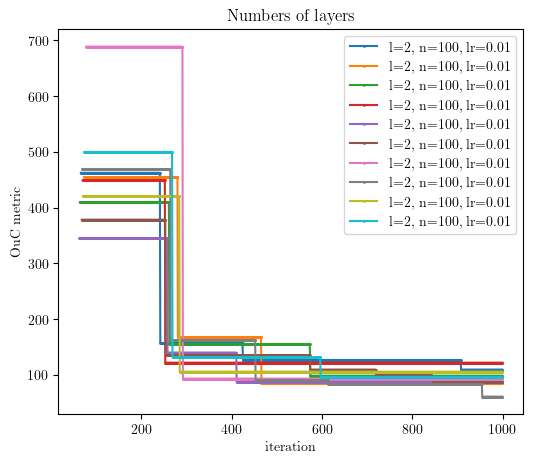

In [43]:
WEIGTHING = 4
CONSTRAINT_WEIGHT = 200.0
res_learning_rate = try_lr([0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01], 2, 100)
ratio_mean = 0
error_mean = 0
for r in res_learning_rate:
    ratio_mean += r['ratio']
    error_mean += r['mse']
ratio_mean /= len(res_learning_rate)
error_mean /= len(res_learning_rate)
hyperparameter_combinations.append({'WEIGHTING': WEIGTHING, 'CONSTRAINT_WEIGHT': CONSTRAINT_WEIGHT, 'ratio_mean': ratio_mean, 'error_mean': error_mean})
plot_results(res_learning_rate, y_max=10)
plot_result_confrontation(res_learning_rate)

/tmp/ipykernel_430497/2445299378.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  penalty_mask = torch.tensor(g_values > epsilon, dtype=torch.float).cuda()
/tmp/ipykernel_430497/2445299378.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  logarithmic_penalty = torch.tensor(penalty_mask * (FIXED_PENALTY + PENALTY_SCALE * torch.log(g_values + 1.0))).cuda()


LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 90.02258 MSE solution: 2.3559462791235233 ratio: 0.181 time: 95.35150003433228
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 112.6373 MSE solution: 5.686517003240078 ratio: 0.125 time: 90.66545867919922
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 89.54897 MSE solution: 2.5228223605452307 ratio: 0.201 time: 92.4612078666687
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 78.82606 MSE solution: 0.5634438794844255 ratio: 0.151 time: 92.38249707221985
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 157.50478 MSE solution: 0.5937423009057644 ratio: 0.192 time: 98.27890706062317
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 130.28378 MSE solution: 5.426964709075837 ratio: 0.145 time: 98.68630075454712
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 84.0636 MSE solution: 3.2803534142612403 ratio: 0.144 time: 95.62236094474792
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 76.53866 MSE solution: 0.22733018809597025 ratio: 0.154 time: 99.0695788860321
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 6

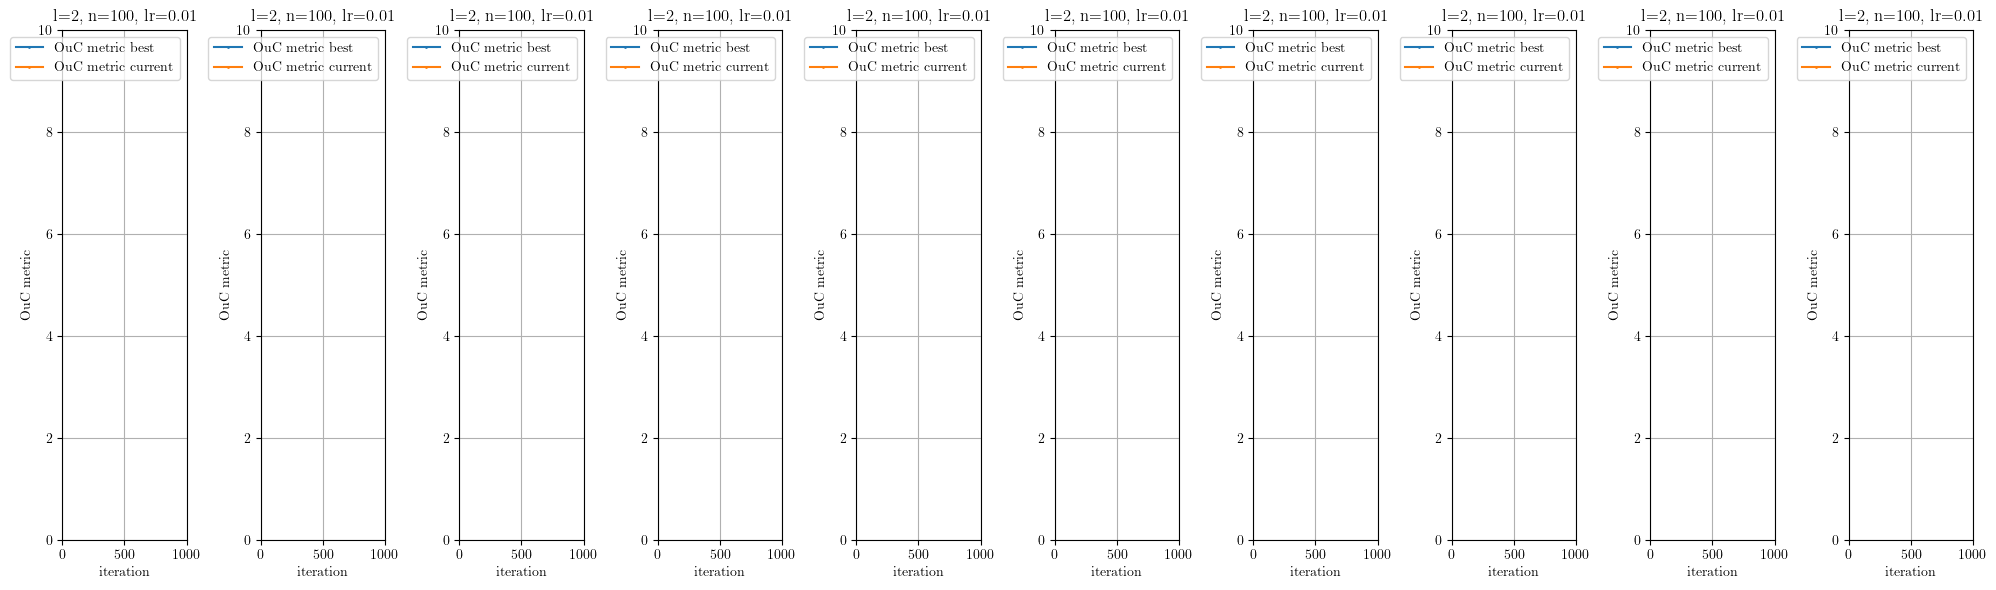

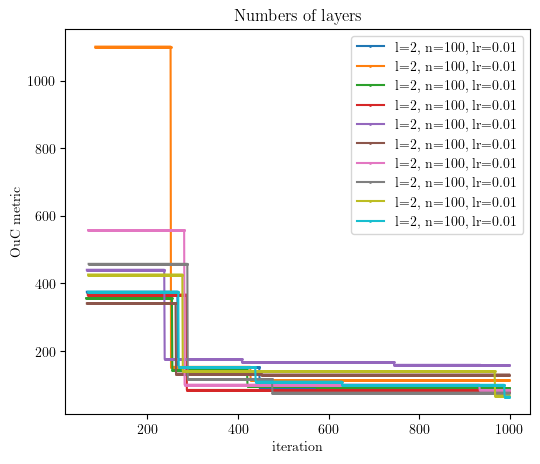

In [44]:
WEIGTHING = 4
CONSTRAINT_WEIGHT = 500.0
res_learning_rate = try_lr([0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01], 2, 100)
ratio_mean = 0
error_mean = 0
for r in res_learning_rate:
    ratio_mean += r['ratio']
    error_mean += r['mse']
ratio_mean /= len(res_learning_rate)
error_mean /= len(res_learning_rate)
hyperparameter_combinations.append({'WEIGHTING': WEIGTHING, 'CONSTRAINT_WEIGHT': CONSTRAINT_WEIGHT, 'ratio_mean': ratio_mean, 'error_mean': error_mean})
plot_results(res_learning_rate, y_max=10)
plot_result_confrontation(res_learning_rate)

/tmp/ipykernel_430497/2445299378.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  penalty_mask = torch.tensor(g_values > epsilon, dtype=torch.float).cuda()
/tmp/ipykernel_430497/2445299378.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  logarithmic_penalty = torch.tensor(penalty_mask * (FIXED_PENALTY + PENALTY_SCALE * torch.log(g_values + 1.0))).cuda()


LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 97.57369 MSE solution: 3.350592449771344 ratio: 0.189 time: 91.89393353462219
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 75.753204 MSE solution: 0.43381627075420676 ratio: 0.176 time: 95.94822978973389
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 103.601494 MSE solution: 0.18080327970682028 ratio: 0.123 time: 95.60339093208313
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 75.47139 MSE solution: 2.376876606420833 ratio: 0.182 time: 93.51082801818848
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 107.99746 MSE solution: 1.1211862364031286 ratio: 0.236 time: 93.75979137420654
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 87.12753 MSE solution: 4.3315392380239075 ratio: 0.152 time: 92.61970806121826
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 104.649925 MSE solution: 0.8083483473096029 ratio: 0.173 time: 94.0244300365448
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 66.91721 MSE solution: 2.3619127882500783 ratio: 0.143 time: 97.5906171798706
LAYERS: 2 NEURONS: 100 LR: 0.01 epsi

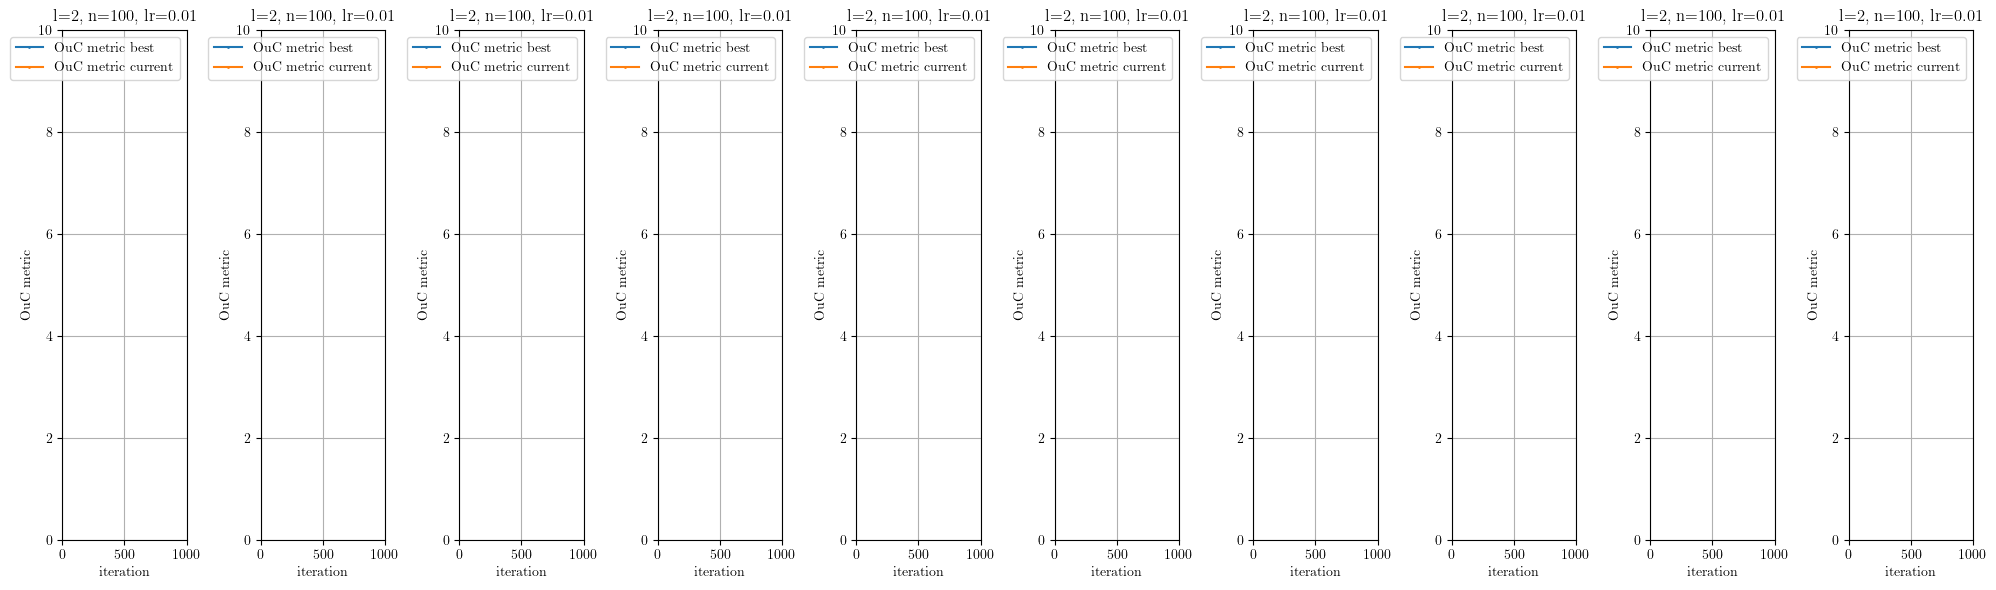

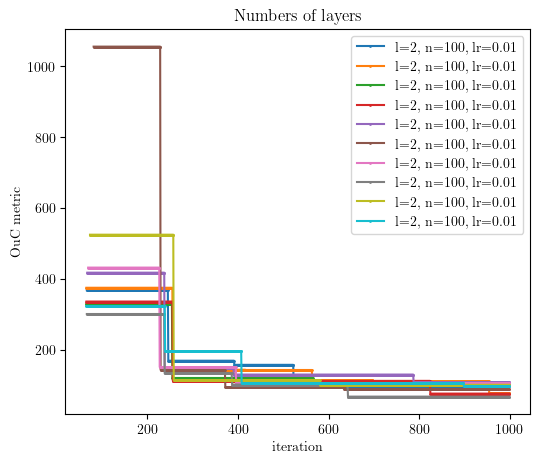

In [45]:
WEIGTHING = 8
CONSTRAINT_WEIGHT = 5.0
res_learning_rate = try_lr([0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01], 2, 100)
ratio_mean = 0
error_mean = 0
for r in res_learning_rate:
    ratio_mean += r['ratio']
    error_mean += r['mse']
ratio_mean /= len(res_learning_rate)
error_mean /= len(res_learning_rate)
hyperparameter_combinations.append({'WEIGHTING': WEIGTHING, 'CONSTRAINT_WEIGHT': CONSTRAINT_WEIGHT, 'ratio_mean': ratio_mean, 'error_mean': error_mean})
plot_results(res_learning_rate, y_max=10)
plot_result_confrontation(res_learning_rate)

/tmp/ipykernel_430497/2445299378.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  penalty_mask = torch.tensor(g_values > epsilon, dtype=torch.float).cuda()
/tmp/ipykernel_430497/2445299378.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  logarithmic_penalty = torch.tensor(penalty_mask * (FIXED_PENALTY + PENALTY_SCALE * torch.log(g_values + 1.0))).cuda()


LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 76.23598 MSE solution: 0.8334646874006856 ratio: 0.125 time: 95.48879837989807
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 109.00474 MSE solution: 3.5500308014441324 ratio: 0.204 time: 97.9048364162445
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 108.53009 MSE solution: 2.1042518730528887 ratio: 0.141 time: 99.27146768569946
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 84.54883 MSE solution: 1.1470926800508439 ratio: 0.153 time: 98.67335391044617
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 41.40854 MSE solution: 0.520153724152806 ratio: 0.258 time: 97.12314343452454
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 110.426254 MSE solution: 2.045835374136429 ratio: 0.148 time: 101.1972770690918
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 90.63408 MSE solution: 1.933697363788352 ratio: 0.125 time: 98.37890362739563
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 54.1453 MSE solution: 0.5844561264330055 ratio: 0.185 time: 93.23630142211914
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 

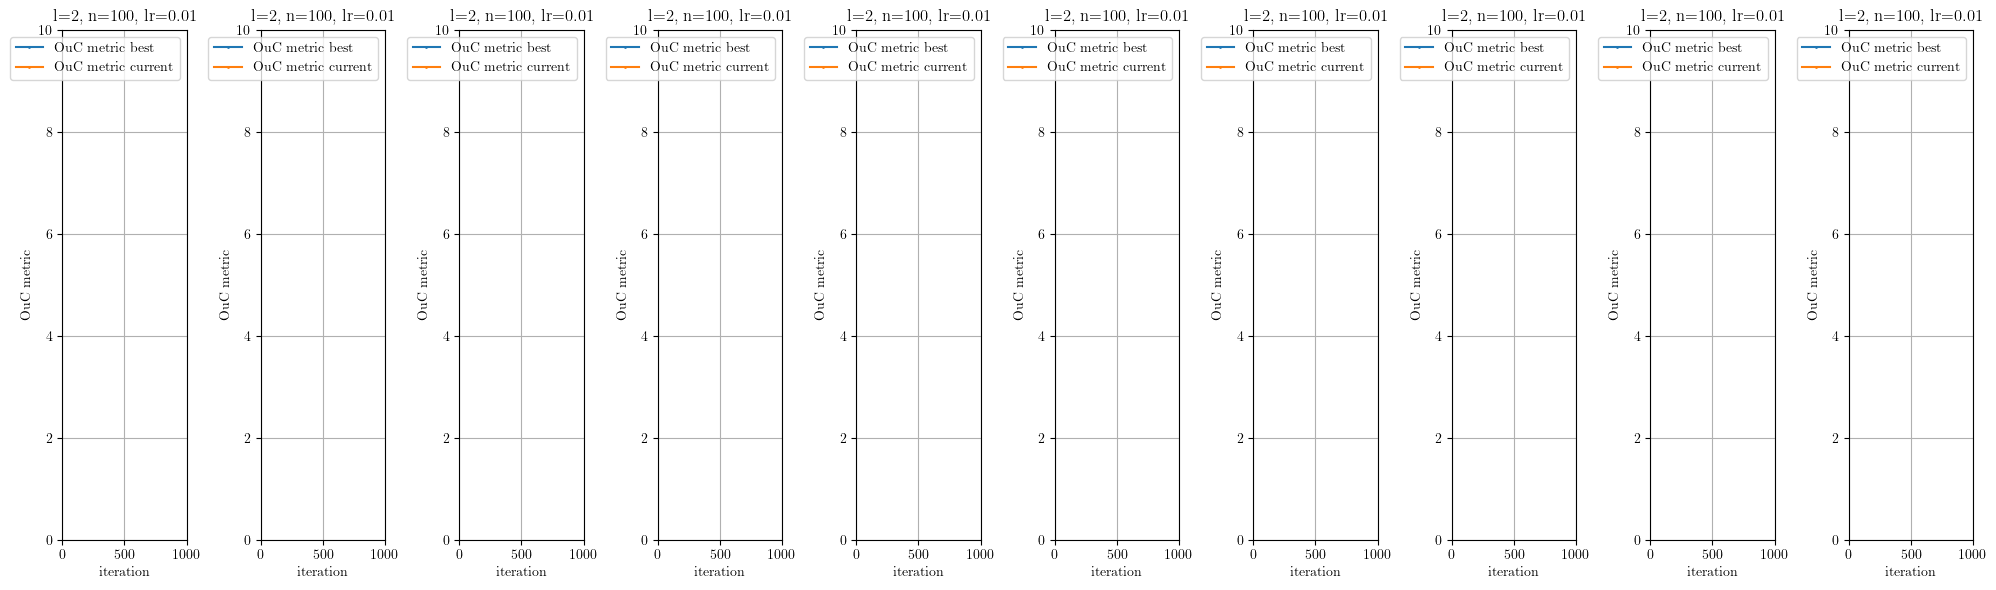

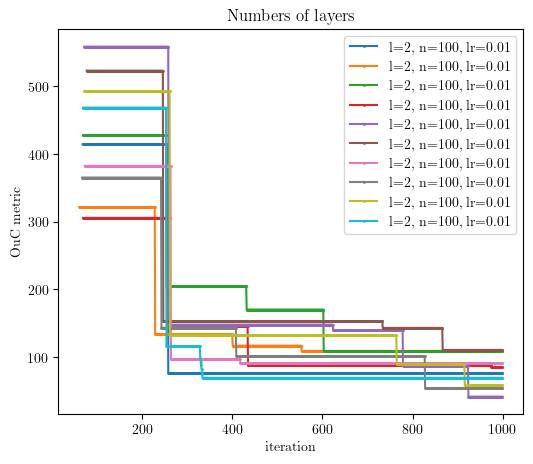

In [46]:
WEIGTHING = 8
CONSTRAINT_WEIGHT = 10.0
res_learning_rate = try_lr([0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01], 2, 100)
ratio_mean = 0
error_mean = 0
for r in res_learning_rate:
    ratio_mean += r['ratio']
    error_mean += r['mse']
ratio_mean /= len(res_learning_rate)
error_mean /= len(res_learning_rate)
hyperparameter_combinations.append({'WEIGHTING': WEIGTHING, 'CONSTRAINT_WEIGHT': CONSTRAINT_WEIGHT, 'ratio_mean': ratio_mean, 'error_mean': error_mean})
plot_results(res_learning_rate, y_max=10)
plot_result_confrontation(res_learning_rate)

/tmp/ipykernel_430497/2445299378.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  penalty_mask = torch.tensor(g_values > epsilon, dtype=torch.float).cuda()
/tmp/ipykernel_430497/2445299378.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  logarithmic_penalty = torch.tensor(penalty_mask * (FIXED_PENALTY + PENALTY_SCALE * torch.log(g_values + 1.0))).cuda()


LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 84.82362 MSE solution: 0.3752527236807135 ratio: 0.172 time: 96.23005747795105
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 139.2281 MSE solution: 7.0502310323006485 ratio: 0.151 time: 92.75985884666443
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 75.52876 MSE solution: 0.41530325818778396 ratio: 0.123 time: 99.070241689682
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 83.60642 MSE solution: 2.6465674196344886 ratio: 0.135 time: 92.15962815284729
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 41.40882 MSE solution: 0.8968336322072902 ratio: 0.164 time: 95.46943092346191
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 92.1499 MSE solution: 2.300779659558426 ratio: 0.18 time: 98.13723397254944
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 83.818405 MSE solution: 2.0318179190275063 ratio: 0.143 time: 97.47717452049255
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 86.71685 MSE solution: 2.3733127903150653 ratio: 0.193 time: 96.72810077667236
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 90

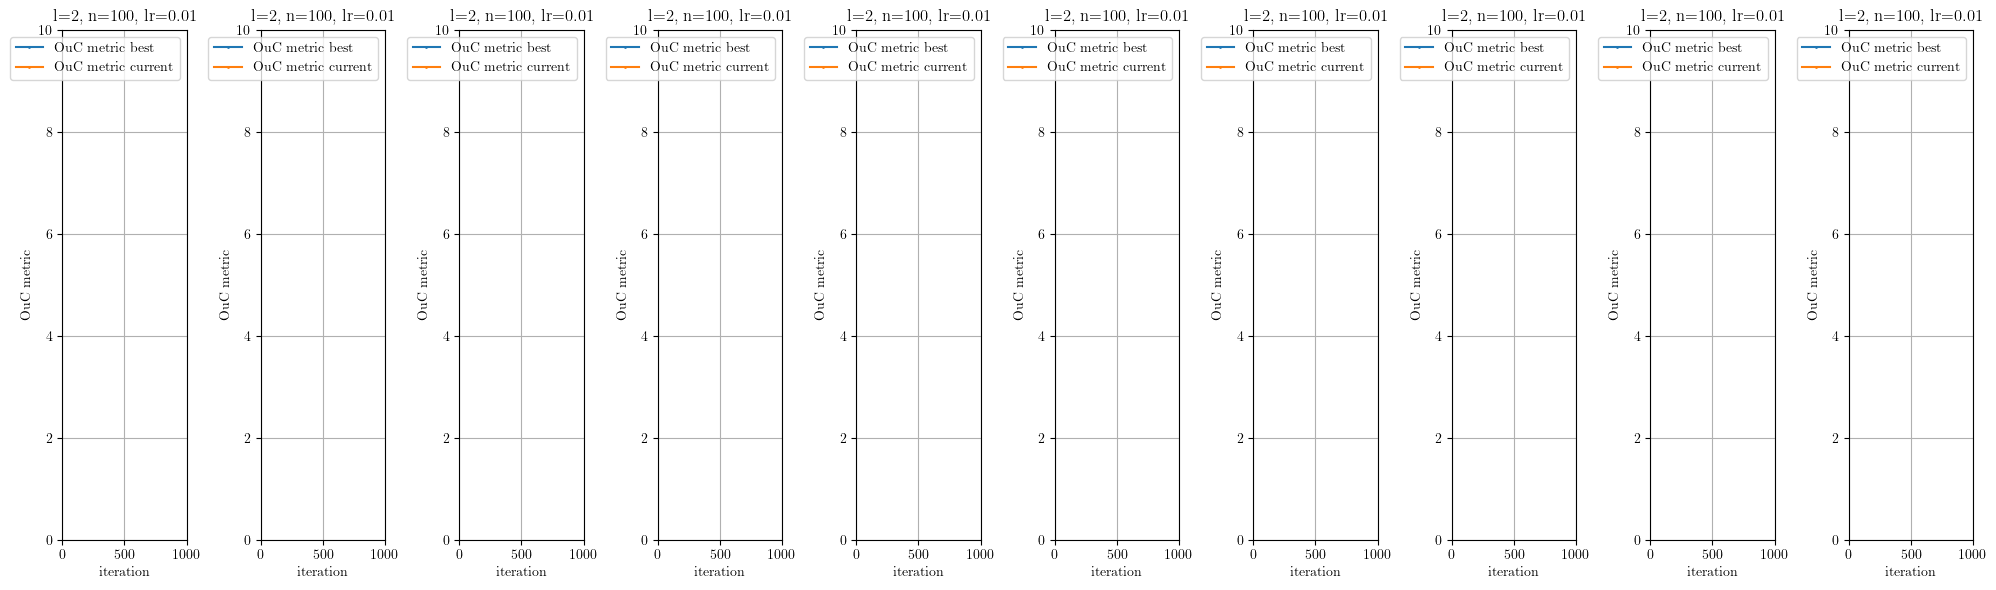

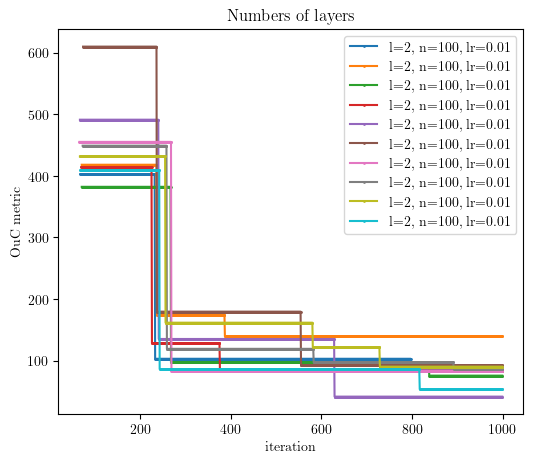

In [47]:
WEIGTHING = 8
CONSTRAINT_WEIGHT = 20.0
res_learning_rate = try_lr([0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01], 2, 100)
ratio_mean = 0
error_mean = 0
for r in res_learning_rate:
    ratio_mean += r['ratio']
    error_mean += r['mse']
ratio_mean /= len(res_learning_rate)
error_mean /= len(res_learning_rate)
hyperparameter_combinations.append({'WEIGHTING': WEIGTHING, 'CONSTRAINT_WEIGHT': CONSTRAINT_WEIGHT, 'ratio_mean': ratio_mean, 'error_mean': error_mean})
plot_results(res_learning_rate, y_max=10)
plot_result_confrontation(res_learning_rate)

/tmp/ipykernel_430497/2445299378.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  penalty_mask = torch.tensor(g_values > epsilon, dtype=torch.float).cuda()
/tmp/ipykernel_430497/2445299378.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  logarithmic_penalty = torch.tensor(penalty_mask * (FIXED_PENALTY + PENALTY_SCALE * torch.log(g_values + 1.0))).cuda()


LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 107.605 MSE solution: 0.41031567396295127 ratio: 0.111 time: 95.73301553726196
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 81.836334 MSE solution: 0.6951397303293603 ratio: 0.143 time: 94.71811389923096
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 84.92485 MSE solution: 1.053057944442252 ratio: 0.164 time: 97.34947085380554
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 61.38253 MSE solution: 1.1790575475028056 ratio: 0.143 time: 95.51900291442871
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 83.194565 MSE solution: 0.18021757470385666 ratio: 0.136 time: 98.11476731300354
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 31.169119 MSE solution: 0.9089758591926186 ratio: 0.158 time: 95.52826356887817
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 59.854572 MSE solution: 0.6663312612071023 ratio: 0.136 time: 100.60629510879517
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 59.31722 MSE solution: 0.6519906465132624 ratio: 0.14 time: 95.39159226417542
LAYERS: 2 NEURONS: 100 LR: 0.01 epsi

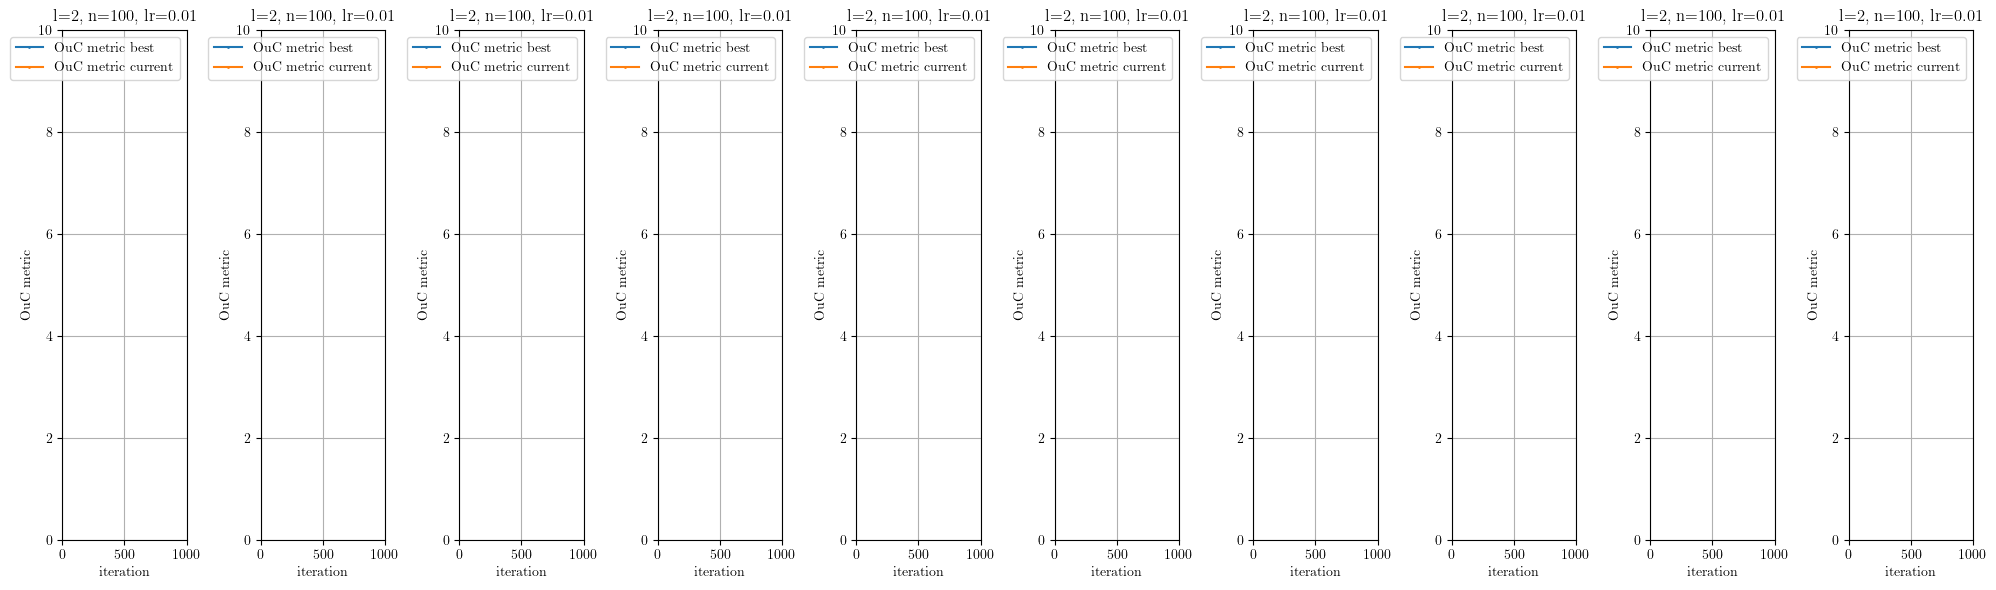

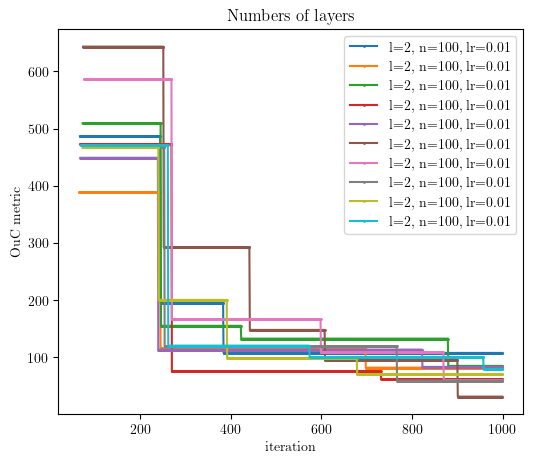

In [48]:
WEIGTHING = 8
CONSTRAINT_WEIGHT = 50.0
res_learning_rate = try_lr([0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01], 2, 100)
ratio_mean = 0
error_mean = 0
for r in res_learning_rate:
    ratio_mean += r['ratio']
    error_mean += r['mse']
ratio_mean /= len(res_learning_rate)
error_mean /= len(res_learning_rate)
hyperparameter_combinations.append({'WEIGHTING': WEIGTHING, 'CONSTRAINT_WEIGHT': CONSTRAINT_WEIGHT, 'ratio_mean': ratio_mean, 'error_mean': error_mean})
plot_results(res_learning_rate, y_max=10)
plot_result_confrontation(res_learning_rate)

/tmp/ipykernel_430497/2445299378.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  penalty_mask = torch.tensor(g_values > epsilon, dtype=torch.float).cuda()
/tmp/ipykernel_430497/2445299378.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  logarithmic_penalty = torch.tensor(penalty_mask * (FIXED_PENALTY + PENALTY_SCALE * torch.log(g_values + 1.0))).cuda()


LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 71.22279 MSE solution: 1.1482909870574047 ratio: 0.131 time: 93.7462203502655
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 63.296875 MSE solution: 0.7503738833323014 ratio: 0.188 time: 93.4484634399414
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 68.16443 MSE solution: 0.2658263650509384 ratio: 0.128 time: 97.77199459075928
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 93.69536 MSE solution: 0.2589888456139992 ratio: 0.145 time: 97.27020812034607
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 88.96135 MSE solution: 1.6663143995142784 ratio: 0.142 time: 93.15812683105469
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 101.42856 MSE solution: 2.8153050920381975 ratio: 0.153 time: 99.18302869796753
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 50.508816 MSE solution: 1.2532660400004314 ratio: 0.207 time: 95.97966885566711
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 64.54866 MSE solution: 0.6627017216393442 ratio: 0.073 time: 96.39586329460144
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon

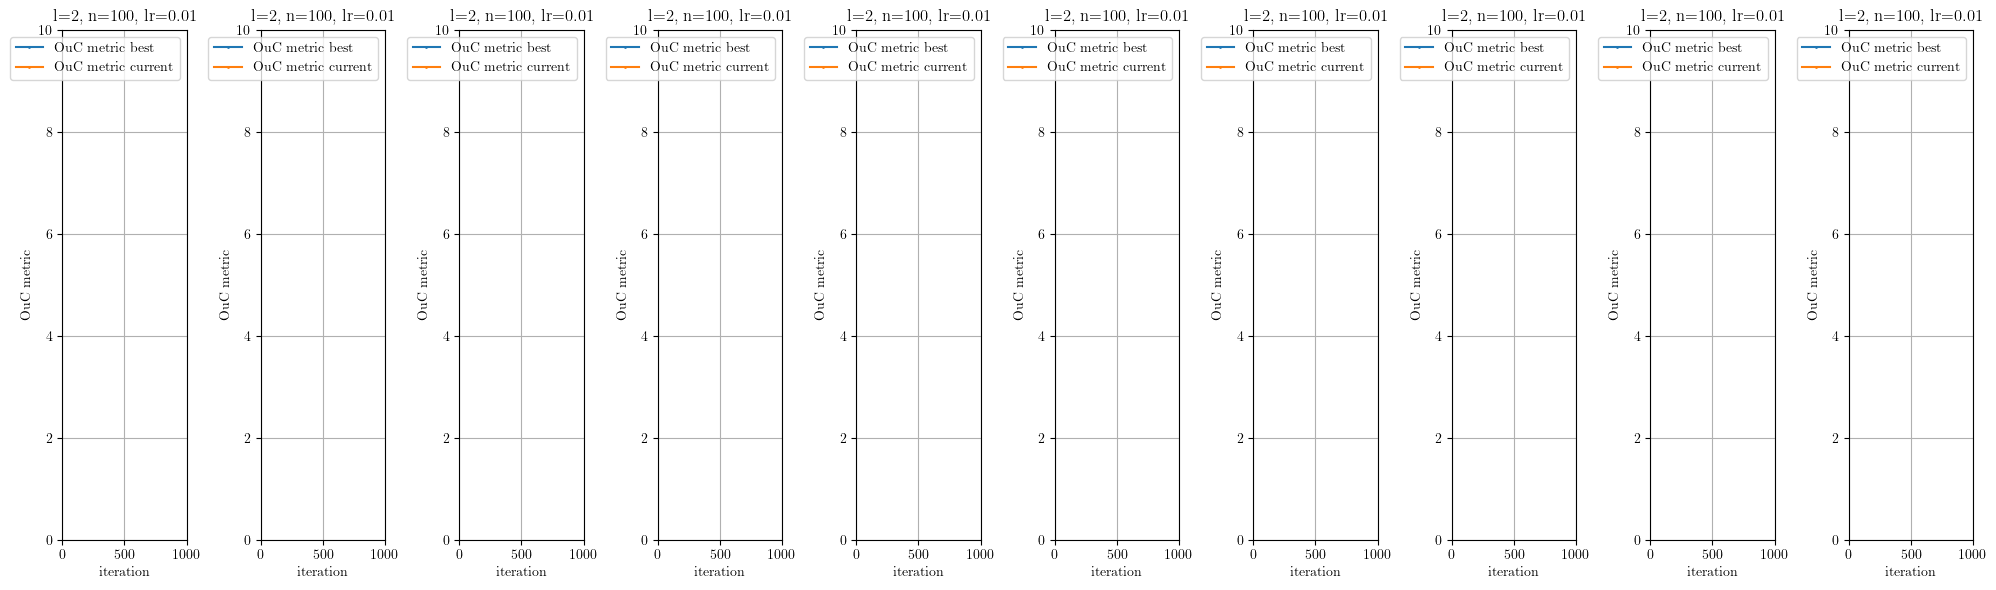

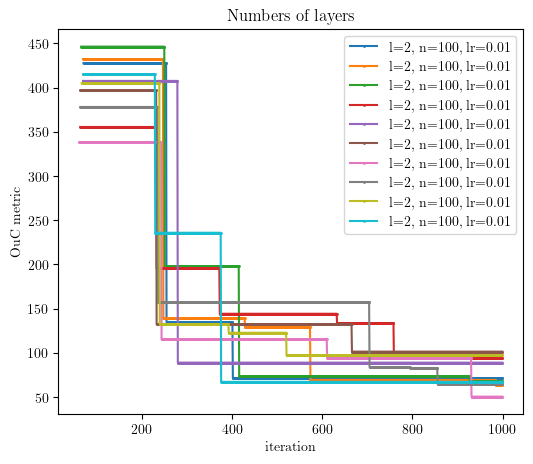

In [49]:
WEIGTHING = 8
CONSTRAINT_WEIGHT = 100.0
res_learning_rate = try_lr([0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01], 2, 100)
ratio_mean = 0
error_mean = 0
for r in res_learning_rate:
    ratio_mean += r['ratio']
    error_mean += r['mse']
ratio_mean /= len(res_learning_rate)
error_mean /= len(res_learning_rate)
hyperparameter_combinations.append({'WEIGHTING': WEIGTHING, 'CONSTRAINT_WEIGHT': CONSTRAINT_WEIGHT, 'ratio_mean': ratio_mean, 'error_mean': error_mean})
plot_results(res_learning_rate, y_max=10)
plot_result_confrontation(res_learning_rate)

/tmp/ipykernel_430497/2445299378.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  penalty_mask = torch.tensor(g_values > epsilon, dtype=torch.float).cuda()
/tmp/ipykernel_430497/2445299378.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  logarithmic_penalty = torch.tensor(penalty_mask * (FIXED_PENALTY + PENALTY_SCALE * torch.log(g_values + 1.0))).cuda()


LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 49.393562 MSE solution: 1.0796758522695538 ratio: 0.127 time: 91.21797966957092
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 57.845284 MSE solution: 0.20692066839443027 ratio: 0.087 time: 95.15881848335266
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 116.80388 MSE solution: 0.2100617780467556 ratio: 0.144 time: 93.29832053184509
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 59.29979 MSE solution: 0.7753862603238068 ratio: 0.155 time: 96.38659954071045
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 105.59576 MSE solution: 3.070584361713402 ratio: 0.164 time: 98.58754324913025
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 84.76961 MSE solution: 0.8652646775957605 ratio: 0.181 time: 96.07862424850464
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 99.26751 MSE solution: 2.2155188099039096 ratio: 0.148 time: 89.3278374671936
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 99.622734 MSE solution: 1.1209493070996726 ratio: 0.166 time: 89.93090152740479
LAYERS: 2 NEURONS: 100 LR: 0.01 epsi

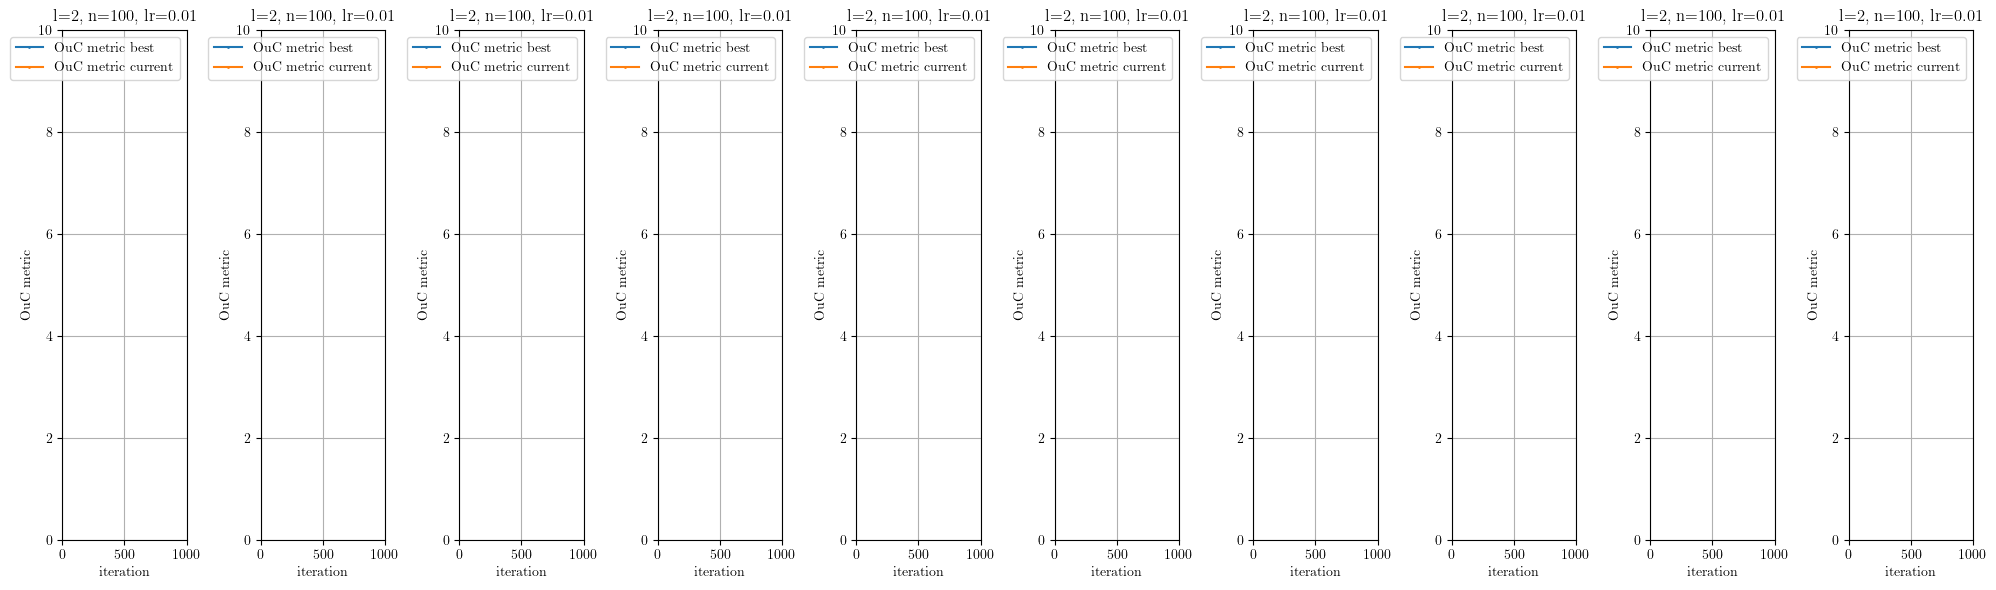

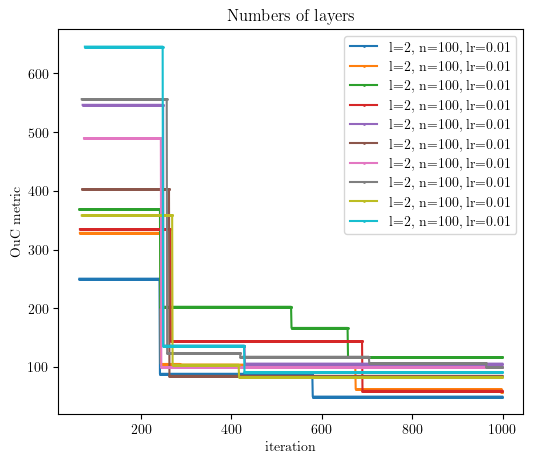

In [50]:
WEIGTHING = 8
CONSTRAINT_WEIGHT = 200.0
res_learning_rate = try_lr([0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01], 2, 100)
ratio_mean = 0
error_mean = 0
for r in res_learning_rate:
    ratio_mean += r['ratio']
    error_mean += r['mse']
ratio_mean /= len(res_learning_rate)
error_mean /= len(res_learning_rate)
hyperparameter_combinations.append({'WEIGHTING': WEIGTHING, 'CONSTRAINT_WEIGHT': CONSTRAINT_WEIGHT, 'ratio_mean': ratio_mean, 'error_mean': error_mean})
plot_results(res_learning_rate, y_max=10)
plot_result_confrontation(res_learning_rate)

/tmp/ipykernel_430497/2445299378.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  penalty_mask = torch.tensor(g_values > epsilon, dtype=torch.float).cuda()
/tmp/ipykernel_430497/2445299378.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  logarithmic_penalty = torch.tensor(penalty_mask * (FIXED_PENALTY + PENALTY_SCALE * torch.log(g_values + 1.0))).cuda()


LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 58.79363 MSE solution: 5.243130613241472 ratio: 0.172 time: 92.76997518539429
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 50.373302 MSE solution: 0.5872834060561775 ratio: 0.194 time: 95.6974265575409
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 94.61697 MSE solution: 0.22707625385117938 ratio: 0.125 time: 94.66986155509949
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 68.818985 MSE solution: 3.668851244383344 ratio: 0.177 time: 104.59369349479675
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 68.9168 MSE solution: 2.54606924864633 ratio: 0.099 time: 101.25396418571472
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 112.82049 MSE solution: 0.622958615708534 ratio: 0.157 time: 94.16185998916626
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 105.01136 MSE solution: 1.5937809027731735 ratio: 0.168 time: 103.96514201164246
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 97.47887 MSE solution: 2.5754500433217133 ratio: 0.157 time: 99.95942950248718
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon

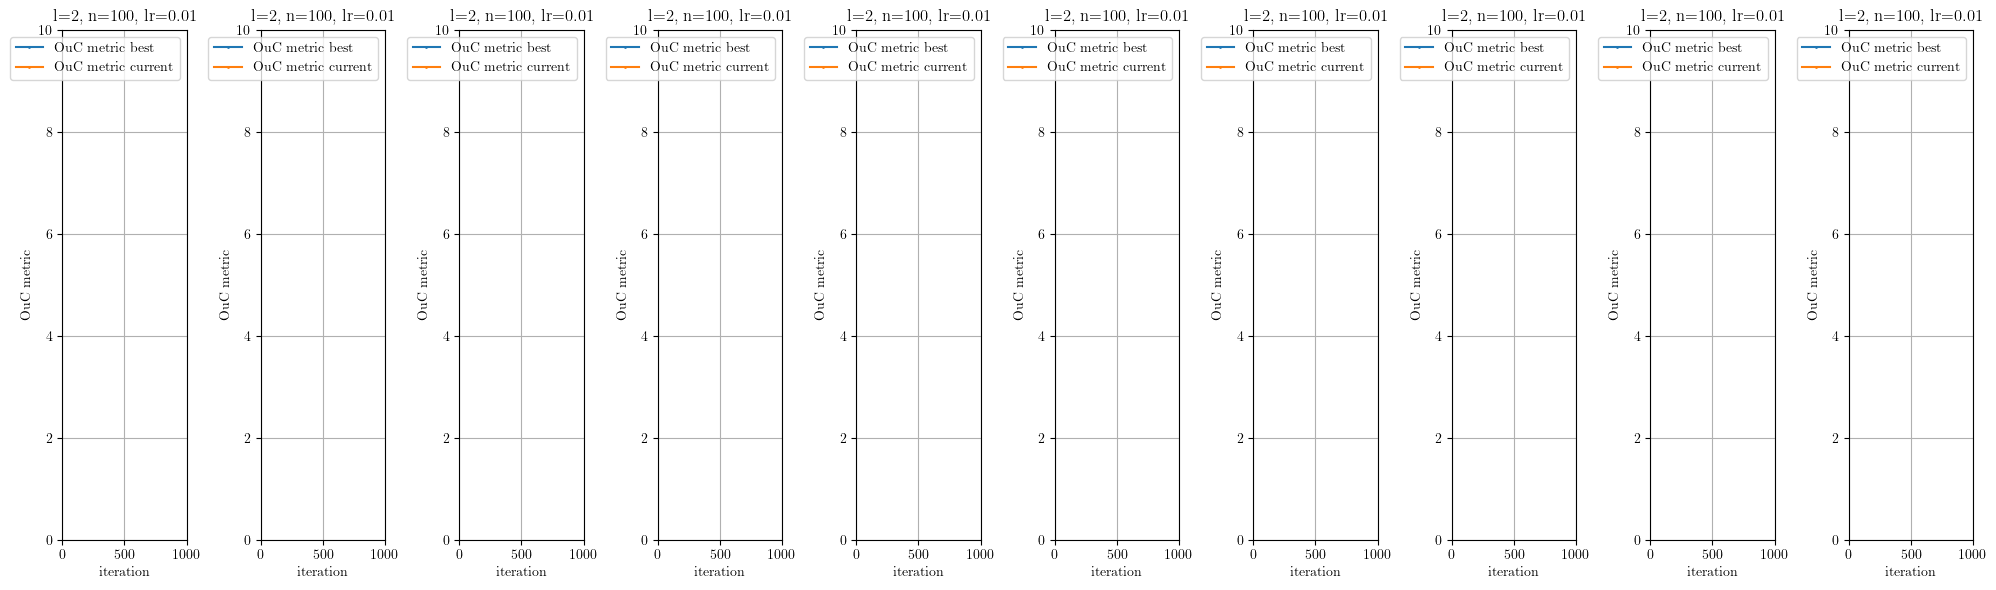

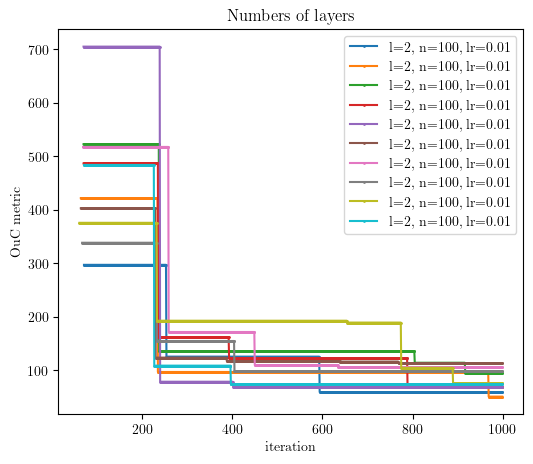

In [51]:
WEIGTHING = 8
CONSTRAINT_WEIGHT = 500.0
res_learning_rate = try_lr([0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01], 2, 100)
ratio_mean = 0
error_mean = 0
for r in res_learning_rate:
    ratio_mean += r['ratio']
    error_mean += r['mse']
ratio_mean /= len(res_learning_rate)
error_mean /= len(res_learning_rate)
hyperparameter_combinations.append({'WEIGHTING': WEIGTHING, 'CONSTRAINT_WEIGHT': CONSTRAINT_WEIGHT, 'ratio_mean': ratio_mean, 'error_mean': error_mean})
plot_results(res_learning_rate, y_max=10)
plot_result_confrontation(res_learning_rate)

In [52]:
import plotly.express as px
import pandas as pd

# Convert the list of hyperparameter combinations into a DataFrame
df = pd.DataFrame(hyperparameter_combinations)

# Create an interactive scatter plot with ratio_mean on x-axis and error_mean on y-axis
fig = px.scatter(df, 
                 x='error_mean', 
                 y='ratio_mean', 
                 hover_data=['WEIGHTING', 'CONSTRAINT_WEIGHT'],
                 labels={
                     'ratio_mean': 'Ratio Mean',
                     'error_mean': 'Error Mean'
                 },
                 title='Hyperparameter Tuning: Ratio Mean vs. Error Mean')

# Show the interactive plot
fig.show()

In [53]:
from IPython.display import display
display(df.sort_values('error_mean', ascending=True).style.set_table_attributes('class="table table-hover"'))